In [33]:
import numpy as np
import pandas as pd
import pymatgen.core as mg
from math import gcd
import statistics
from statistics import mean
from statistics import mode
import statistics as stat
import matplotlib.pyplot as plt

from pymatgen.ext.matproj import MPRester

from tabulate import tabulate


In [2]:
metals = ['Li','Be','Na','Mg','Al','K','Ca','Sc','Ti','V','Cr','Mn','Fe','Co','Ni','Cu','Zn','Ga','Rb','Sr','Y','Zr',
         'Nb','Mo','Ru','Rh','Pd','Ag','Cd','In','Sn','Cs','Ba','Hf','Ta','W','Re','Os','Ir','Pt','Au','Hg',
         'Tl','Pb','Bi','La','Ce','Pr','Nd',
          'Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb','Lu','Th']
#length is 60
print(len(metals))


60
45


In [3]:
#edited list(FROM BINARY CALCULATION):
pnoxides = ['Li2O','Na2O','Al2O3','K2O','CaO','V2O5','Cr2O3','Mn2O3','BeO','MgO','Sc2O3','TiO2','Fe2O3','Co3O4','NiO','CuO','ZnO','Ga2O3','Rb2O','SrO','Y2O3',
            'ZrO2', 'Nb2O5','MoO3','RuO2','Rh2O3','PdO','AgO','CdO','In2O3','SnO2','Cs2O','BaO','HfO2','Ta2O5','WO3','Re2O7','OsO2','IrO2','PtO','Au2O3','HgO'
            ,'Tl2O3','PbO2','Bi2O3','La2O3','CeO2','Pr6O11','Nd2O3','Sm2O3','Eu2O3','Gd2O3','Tb4O6','Dy2O3','Ho2O3','Er2O3','Tm2O3','Yb2O3','Lu2O3','ThO2'
            ,'UO2']

In [36]:
#initialize MPRester

with MPRester('te6LPIwzrup9SZsT') as mpr: 
    
    cff = ((mpr.query('mp-1216634',['unit_cell_formula']))[0])['unit_cell_formula']

In [39]:
#Get alloy or reactant coefficients, given alloy 'AB' material id

#ternary compound coefficients function 
    #pf = pretty formula (see Materials Project Legacy API documentation)
    #cf = chemical formula
    #RAc = reactant A coefficient
    #RBc = reactant B coefficient
    
    #rAc and rBc are the coefficients of the reactants from the unit cell formula
    #used to calculate RAc and RBc.


def tccf(pf):
    cf = ((mpr.query(pf,['unit_cell_formula']))[0])['unit_cell_formula']

    rAc = int(list(cf.values())[0])

    rBc = int(list(cf.values())[1])
    
    rCc = int(list(cf.values())[2])


    RAc = rAc/gcd(rAc,rBc,rCc)

    RBc = rBc/gcd(rAc,rBc,rCc)
    
    RCc = rCc/gcd(rAc,rBc,rCc)

    return RAc, RBc,RCc

#Retrieve coefficients

#RAc = list(bccf(id))[0] 

#RBc = list(bccf(id))[1] 

#RCc = list(bccf(id))[2] 




In [40]:
#Binary compound coefficients function 

def bccf(pf):
    cf = ((mpr.query(pf,['unit_cell_formula']))[0])['unit_cell_formula']

    rAc = int(list(cf.values())[0])

    rBc = int(list(cf.values())[1])

    RAc = rAc/gcd(rAc,rBc)

    RBc = rBc/gcd(rAc,rBc)

    return RAc, RBc

#Retrieve coefficients

#RAc = list(bccf(id))[0] 

#RBc = list(bccf(id))[1] 


In [41]:
#Alloy constituent names used to search for constituent oxides

def names(id):
    cf = ((mpr.query(id,['unit_cell_formula']))[0])['unit_cell_formula']
    A = (list(cf.keys())[0])
    B = (list(cf.keys())[1])
    C = (list(cf.keys())[2])
    return A,B,C

#A = list(names(id))[0] 

#B = list(names(id))[1] 

#C = list(names(id))[1] 

In [8]:
#oxide metal and oxegyn coefficients given oxide

#PAc = product A oxide metal coefficient given oxide materials id

#PBc = product B oxide metal coefficient given oxide materials id

#PAOc = product A oxide oxegyn coefficient given oxide materials id

#PAOc = product B oxide oxegyn coefficient given oxide materials id

#now take oxide and reactant coefficients to calculate reaction coefficients

#cMA = coefficient matrix A

#cMB = coefficient matrix B

#cL = coefficient list

   

def metric(alloy):
    N = names(alloy)
    A = N[0]
    B = N[1]
    C = N[2]
    
    def findox(AorB):
        for item in pnoxides:
            if len(AorB) == 2: 
                if item[0]+item[1] == AorB:
                    AorBox = item
                    return AorBox
            elif len(AorB) == 1: 
                if item[0] == AorB:
                    AorBox = item
                    return AorBox
            
                
    Pa = findox(A)
    PA = list(bccf(Pa))
    
    PAc = PA[0]
    PAOc = PA[1]
    
    Pb = findox(B)
    PB = list(bccf(Pb))
    
    PBc = PB[0]
    PBOc = PB[1] 
    
    Pc = findox(C)
    PC = list(bccf(Pc))
    
    PCc = PC[0]
    PCOc = PC[1] 
    
    Rcoeffs = tccf(alloy)
    
    RAc = Rcoeffs[0]
    RBc = Rcoeffs[1]
    RCc = Rcoeffs[2]
    
    
    cMA = np.zeros((4,4))
    cMB = np.zeros((4,1))

    cMA[0][0] = RAc
    cMA[0][1] = -1*PAc

    cMA[1][0] = RBc
    cMA[1][2] = -1*PBc
    
    cMA[2][0] = RCc
    cMA[2][3] = -1*PCc
    
    cMA[3][1] = PAOc
    cMA[3][2] = PBOc
    cMA[3][3] = PCOc
    
    cMB[3][0] = 2
    
    cL = np.linalg.solve(cMA,cMB)
    
    x = cL[0][0]
    y = cL[1][0]
    z = cL[2][0]
    w = cL[3][0]
    
    alloyid = mpr.query(alloy, ['materials_id'])
    
    
    def metricpart(Pa,Pb,Pc,alloy,x,y,z,w,PAOc,PBOc,PCOc,PAc,PBc,PCc):
            natomsA = PAOc + PAc
            natomsB = PBOc + PBc
            natomsC = PCOc + PCc
    
            eAlloy = mpr.query(criteria={'pretty_formula': alloy},properties = ['formation_energy_per_atom'])[0]['formation_energy_per_atom']*(RAc+RBc+RCc)
            eA = mpr.query(criteria={'pretty_formula': Pa},properties = ['formation_energy_per_atom'])[0]['formation_energy_per_atom']*natomsA
            eB = mpr.query(criteria={'pretty_formula': Pb},properties = ['formation_energy_per_atom'])[0]['formation_energy_per_atom']*natomsB
            eC = mpr.query(criteria={'pretty_formula': Pc},properties = ['formation_energy_per_atom'])[0]['formation_energy_per_atom']*natomsC

    
            Eref = y*eA + z*eB+w*eC
            Erxn5 = Eref - x*eAlloy 
    
            metric = Erxn5/Eref
        
            return metric
    
    m = metricpart(Pa,Pb,Pc,alloy,x,y,z,w,PAOc,PBOc,PCOc,PAc,PBc,PCc)
    return m
    
    

In [ ]:
##Create a list of ternary alloys by combining each metal with next two following metals until the end of the list
##is reached and adding all existing variants of the resulting alloy to the list. 

#alloys = []

#b = 0
#while b < 11:
#    item = metals[b]
#    b += 1
#    counter = metals.index(item)
#    counter_2 = metals.index(item) +1
#    if metals.index(item) < 57:
#            for j in range(0,57 - metals.index(item)):
#                counter += 1
#                counter_2 +=1
            
#                for g in range(counter_2,58 - metals.index(item)):
                
#                    data3 = mpr.query(criteria={"elements": {"$all": [item, metals[counter],metals[g] ]},'nelements':3},
#                            properties=['theoretical','pretty_formula'])
#                    if len(data3) !=0:
#                        for i in data3:
#                            if i['theoretical'] == False:
#                                alloys.append(i['pretty_formula'] )
                           
#                            elif len(data3) == 0:
#                                pass
     
#print(alloys)

In [9]:
alloys = ['Na2Li5Sn4', 'NaLi5Sn4', 'Ba19Na29Li13', 'Na2LiAu3', 'LiMg2Ga', 'Li2MgIn', 'LiMgIr', 'LiMg2Tl', 'Li2MgTl', 'Li2MgPb', 'LiMgBi', 'LiCaAl3', 'Li2AlRh', 'LiAl2Rh', 'Li2AlPd', 'LiAl2Pd', 'LiAlAg2', 'Li2AlAg', 'LiAl2Ir', 'LiAl2Pt', 'Li2AlPt', 'K2LiSn4', 'LiCaSn', 'Li5Ca7Sn11', 'Li6Ca17Hg9', 'LiCaPb', 'LiCaBi', 'LiNi2Sn', 'Li13(Ga7Cu2)3', 'Li2CuSn2', 'Li2CuSn', 'LiCu2Sn', 'Li2ZnSn', 'Li3(ZnSn2)2', 'LiYGa4', 'LiGa2Ru', 'Li2GaRh', 'LiGa2Rh', 'LiGa2Pd', 'Li2GaPd', 'LiGa2Ir', 'Li2GaIr', 'Li2GaIr', 'Li2GaPt', 'LiGa2Pt', 'Li2GaAu', 'Rb2LiSn4', 'Sr17(Li2Hg3)3', 'SrLiBi', 'Li2Y5In9', 'Li3YBi2', 'LiIn2Ru', 'LiSn4Ru', 'Li2InRh', 'LiIn2Rh', 'LiSn4Rh', 'LiSn5Rh3', 'Li2InPd', 'LiIn2Pd', 'LiSnPd2', 'LiTlPd2', 'LiPd2Pb', 'Li2InAg', 'LiInAg2', 'Li2AgSn', 'Li17(AgSn2)3', 'LiAg2Sn', 'Li2AgSn', 'Li2AgSn2', 'Li2AgPb', 'Li2AgBi', 'Li2CdSn', 'Li2CdPb', 'Li2CdPb', 'LiInSn', 'LiIn2Ir', 'Li2InIr', 'Li2InIr', 'Li2InPt', 'LiIn2Pt', 'Li2InAu', 'Ba3(LiSn2)4', 'LiSn4Ir', 'LiSn4Au3', 'Li2Sn2Au', 'LiSnAu', 'Li2SnAu', 'LiLaSn2', 'LiCeSn2', 'LiCeSn', 'LiCeSn', 'LiPrSn', 'LiPrSn', 'LiPrSn2', 'LiNdSn', 'LiNdSn2', 'LiNdSn', 'LiSmSn', 'LiSmSn2', 'Li6Eu5Sn9', 'LiGdSn', 'LiTb5Sn3', 'LiTbSn2', 'LiDySn', 'LiDySn2', 'LiHoSn', 'LiHoSn2', 'LiErSn', 'LiErSn2', 'LiTmSn', 'LiTmSn2', 'Ba3(LiBi)4', 'Li2TlAu', 'Li2PbAu', 'Li2BiAu', 'LiYbPb', 'LiLaBi2', 'Li3LaBi2', 'Li3CeBi2', 'Li3PrBi2', 'Li3SmBi2', 'Li7(Eu2Bi3)2', 'LiEuBi', 'Li3GdBi2', 'LiYbBi', 'LiYbBi', 'Ta6Be15Cu8', 'LaBeCu12', 'Na2MgSn', 'Na2MgPb', 'K(NaIn3)3', 'K3(Na13In24)2', 'K29NaHg48', 'Na4CaSn6', 'Na10CaSn12', 'NaMnBi', 'Na6ZnSn2', 'Na17In12Ga29', 'Na10(Ga2Sn)3', 'Na(GaAu2)2', 'Na2SrSn4', 'Na10SrSn12', 'Na3In2Ag', 'Na2CdSn', 'Na6Cd16Au7', 'Na2CdPb', 'Na2In5Au6', 'NaIn2Au', 'Na3In2Au', 'Na8In6Au11', 'Na3InBi2', 'NaSnAu', 'Na2Sn3Au', 'Na5TlSn3', 'Na10EuSn12', 'Na10YbSn12', 'Cs3NaPb4', 'BaNaBi', 'Na4TlAu', 'Na2BiAu', 'Na2HgPb', 'Ca4MgAl3', 'Mg3(TiAl9)2', 'Mg3(Al9V)2', 'Mg3(Al9Cr)2', 'Mg3(MnAl9)2', 'MgAl2Cu', 'Mg2Al5Cu6', 'Mg11(Al2Cu)6', 'YMgAl', 'Mg3(Al9Mo)2', 'Mg3(TaAl9)2', 'Mg3(Al9W)2', 'La6Mg22Al', 'K3(Mg10In7)2', 'K3Mg18Sn11', 'K2Mg5Sn3', 'K3Mg18Pb11', 'KMgBi', 'Ca4Mg4Fe3', 'CaMgNi4', 'CaMg2Ni9', 'CaMgPd', 'Ca2MgPd2', 'CaMgSn', 'Ca2MgPt2', 'CaMgPb', 'Ca(MgBi)2', 'Mg(ScGa)2', 'MgSc3Ru2', 'MgSc2Ru', 'Mg3TiNi2', 'Mg3MnNi2', 'EuMg2Fe', 'Mg3Ga7Co2', 'La4MgCo', 'Pr4MgCo', 'Nd4Mg3Co2', 'Sm4Mg3Co2', 'TbMgCo4', 'Tb4Mg3Co2', 'YMgNi4', 'MgInNi2', 'MgNi2Sn', 'MgNiBi', 'La2MgNi2', 'LaMgNi4', 'La2MgNi2', 'La23Mg4Ni7', 'LaMg2Ni9', 'LaMg2Ni', 'CeMgNi4', 'Ce2MgNi2', 'Ce2MgNi2', 'CeMg2Ni9', 'PrMg2Ni9', 'Pr23Mg4Ni7', 'Pr2MgNi2', 'PrMgNi4', 'NdMgNi4', 'NdMg2Ni9', 'Nd2MgNi2', 'SmMg2Ni9', 'EuMgNi', 'GdMg2Ni9', 'GdMgNi4', 'TbMgNi', 'Tb2Mg3Ni2', 'Mg2Ga5Cu6', 'YMg2Cu9', 'Y5Mg8Cu5', 'YMgCu4', 'Y5Mg16Cu5', 'YMg4Cu', 'Y2MgCu2', 'YMgCu', 'Y5Mg13Cu5', 'MgInCu4', 'MgCuSn', 'MgCuSn', 'MgCu4Sn', 'MgCuBi', 'LaMg2Cu9', 'La2MgCu2', 'LaMg4Cu', 'LaMgCu2', 'CeMg2Cu9', 'CeMg2Cu', 'Ce2MgCu2', 'CeMgCu2', 'PrMg2Cu9', 'Nd2MgCu2', 'NdMg2Cu9', 'NdMgCu4', 'SmMg2Cu9', 'EuMg2Cu9', 'TbMg2Cu9', 'TbMg4Cu', 'DyMg2Cu9', 'HoMg2Cu9', 'YMgZn', 'MgZnAg2', 'CeMgZn2', 'Ce20Mg19Zn81', 'Sm3Mg13Zn30', 'Ho8Mg12Zn61', 'YMgGa', 'MgGaAu', 'MgGaAu2', 'LaMgGa', 'CeMgGa', 'PrMgGa', 'NdMgGa', 'SmMgGa', 'GdMgGa', 'TmMgGa', 'SrMg2Pd', 'SrMgIn3', 'SrMgSn', 'SrMgPt', 'Sr(MgBi)2', 'YMgPd', 'YMgAg', 'YMgIn', 'YMgTl', 'MgSn4Ru', 'La4MgRu', 'Ce4MgRu', 'Pr23Mg4Ru7', 'Pr4MgRu', 'Nd4MgRu', 'Er2Mg2Ru', 'Er2Mg3Ru', 'LaMgRh', 'La23Mg4Rh7', 'PrMgRh', 'Nd23Mg4Rh7', 'Sm4MgRh', 'Gd4MgRh', 'Dy4MgRh', 'LaMg2Pd', 'LaMgPd', 'CeMgPd', 'PrMgPd', 'SmMgPd', 'EuMgPd', 'GdMgPd', 'Tb2MgPd2', 'DyMgPd', 'ErMgPd', 'MgCdAg2', 'MgInAg2', 'LaMgAg', 'CeMg2Ag', 'CeMgAg', 'PrMg2Ag', 'PrMgAg', 'NdMg2Ag', 'SmMg2Ag', 'SmMgAg', 'GdMg2Ag', 'DyMgAg', 'ErMgAg', 'SmMgIn', 'GdMgIn', 'DyMgIn', 'HoMgIn', 'TmMgIn', 'Ba(MgSn)2', 'BaMgSn', 'MgSnAu', 'Ce6Mg23Sn', 'CeMgSn', 'PrMgSn', 'PrMgSn', 'NdMgSn', 'EuMgSn', 'TbMgSn', 'DyMgSn', 'HoMgSn', 'ErMgSn', 'TmMgSn', 'BaMgPb', 'Ba(MgPb)2', 'Ba(MgBi)2', 'La4MgIr', 'Nd4MgIr', 'Tb4MgIr', 'CeMgPt', 'PrMgPt', 'Nd23Mg4Pt7', 'NdMgPt', 'SmMgPt', 'GdMgPt', 'GdMgAu', 'LaMgTl', 'CeMgTl', 'SmMgTl', 'La3MgBi5', 'Sm(MgBi)2', 'Eu(MgBi)2', 'Ca(Al10Cr)2', 'Ca(Al5Cr)2', 'Ca(MnAl2)4', 'CaAl9Co2', 'Ca(Al4Co)2', 'CaAl9Ni', 'Ca3Al7Cu2', 'Ca(Al2Cu)4', 'Ca(AlZn)2', 'Ca(AlGa)2', 'CaAlPd', 'Ca2AlPd2', 'Ca3Al7Ag2', 'Ca3AlCd17', 'Ca2AlPt2', 'CaAlPt', 'CaAlAu', 'Ca5(AlBi3)2', 'Sc(MnAl2)4', 'Sc(Al2Fe)4', 'ScAl2Ni', 'ScAlNi2', 'Sc6Al16Ni7', 'ScAlCu2', 'Sc6Al16Ru7', 'Sc2Al3Ru', 'Sc6Al16Rh7', 'Sc6Al16Pd7', 'ScAlPd2', 'ScAlAg2', 'Sc6Al16Os7', 'Sc6Al16Ir7', 'ScAlAu2', 'ScAlAu', 'TiAlFe2', 'TiAlCo2', 'Ti6Al16Co7', 'TiAlNi2', 'Ti6Al16Ni7', 'TiAlCu2', 'Zr2TiAl', 'Ti6Al16Ru7', 'Ti6Al16Rh7', 'Ti6Al16Pd7', 'Ti6Al16Os7', 'Ti6Al16Ir7', 'TiAlPt', 'Ti6Al16Pt7', 'TiAlAu2', 'TiAlAu', 'La(TiAl10)2', 'Ce(TiAl10)2', 'Pr(TiAl10)2', 'Dy6Ti4Al43', 'Mn2AlV', 'AlVFe2', 'AlVCo2', 'AlVNi2', 'La(Al10V)2', 'Ce(Al10V)2', 'Pr(Al10V)2', 'Sm(Al10V)2', 'Eu(Al10V)2', 'AlCrFe2', 'AlCrCo2', 'AlCrNi2', 'AlCrCu2', 'Y6Al43Cr4', 'Y(Al2Cr)4', 'Y(Al10Cr)2', 'La(Al10Cr)2', 'Ce(Al10Cr)2', 'Pr(Al10Cr)2', 'Nd6Al43Cr4', 'Nd(Al10Cr)2', 'Sm(Al10Cr)2', 'Sm6Al43Cr4', 'Gd(Al10Cr)2', 'Gd(Al2Cr)4', 'Tb6Al43Cr4', 'Dy(Al2Cr)4', 'Dy6Al43Cr4', 'Ho6Al43Cr4', 'Er6Al43Cr4', 'Er(Al10Cr)2', 'MnAlFe2', 'Mn2AlCo', 'MnAlCo2', 'Mn6Al31Ni2', 'MnAlNi2', 'MnAlCu2', 'Y(MnAl2)4', 'MnAlRh2', 'MnAlPd2', 'MnAlPt', 'MnAlPt2', 'MnAlAu2', 'Ce(MnAl2)4', 'Sm(MnAl2)4', 'Eu2Mn5Al12', 'AlFeCo2', 'AlFe2Ni', 'Al7FeCu2', 'Y2Al3Fe14', 'Y(Al2Fe)4', 'Y(Al5Fe)2', 'Zr6Al2Fe', 'AlFe2Mo', 'BaAl9Fe2', 'La(Al2Fe)4', 'Ce(Al4Fe)2', 'Ce(Al5Fe)2', 'Ce(Al2Fe)4', 'Pr2Al2Fe15', 'Pr(Al2Fe)4', 'Nd2Al2Fe15', 'Sm2Al2Fe15', 'Eu(Al2Fe)4', 'Eu(Al4Fe)2', 'Tb(Al2Fe)4', 'Tb(Al5Fe)2', 'Dy2Al2Fe15', 'Dy2Al5Fe12', 'Dy(Al2Fe)4', 'Dy2Al3Fe14', 'Ho(Al2Fe)4', 'Er(Al2Fe)4', 'Er2Al3Fe14', 'Al7CoCu2', 'SrAl9Co2', 'Y2Al2Co15', 'Y2Al3Co14', 'YAl2Co', 'Y2(Al3Co)3', 'Zr6Al2Co', 'ZrAlCo2', 'Zr6Al16Co7', 'NbAlCo2', 'HfAlCo2', 'Hf6Al16Co7', 'TaAlCo2', 'LaAl4Co', 'CeAl4Co', 'Ce(Al10Co)2', 'Ce2Al2Co15', 'CeAlCo', 'Pr2Al3Co14', 'Pr2AlCo2', 'Pr2Al2Co15', 'Pr(Al4Co)2', 'Pr2AlCo2', 'Pr7Al7Co6', 'PrAl4Co', 'Pr2Al19Co6', 'Nd2AlCo2', 'Nd7Al7Co6', 'Nd2(Al3Co)3', 'NdAl4Co', 'Nd(Al4Co)2', 'EuAl9Co2', 'Gd2AlCo2', 'Tb2AlCo2', 'Dy2AlCo2', 'Er2Al3Co', 'SrAl9Ni2', 'YAlNi', 'YAl3Ni', 'Y3(AlNi3)2', 'YAl2Ni', 'YAl3Ni2', 'Y4Al23Ni6', 'YAl4Ni', 'ZrAlNi2', 'Zr5AlNi4', 'ZrAl5Ni2', 'Zr6Al16Ni7', 'ZrAlNi', 'NbAlNi2', 'BaAl9Ni2', 'HfAlNi', 'HfAlNi2', 'TaAlNi2', 'La5Al3Ni2', 'LaAl5Ni2', 'CeAl5Ni2', 'CeAlNi', 'CeAl4Ni', 'CeAl3Ni2', 'Ce4Al23Ni6', 'PrAl5Ni2', 'PrAl3Ni2', 'PrAl4Ni', 'PrAlNi', 'Pr2AlNi2', 'PrAl2Ni3', 'Nd2AlNi2', 'NdAl3Ni2', 'NdAlNi', 'SmAl4Ni', 'Sm3(AlNi3)2', 'Sm3AlNi8', 'Sm4Al23Ni6', 'GdAl4Ni', 'GdAlNi', 'Gd3(AlNi3)2', 'GdAl2Ni', 'Gd(Al3Ni)3', 'Gd2AlNi2', 'TbAlNi', 'Tb3(AlNi3)2', 'TbAl2Ni', 'Tb2AlNi2', 'TbAl4Ni', 'Tb3AlNi8', 'DyAlNi', 'Dy3(AlNi3)2', 'Dy2AlNi2', 'Dy3AlNi8', 'DyAl4Ni', 'DyAl2Ni', 'HoAl2Ni', 'Ho3AlNi8', 'HoAlNi', 'Ho2AlNi2', 'Ho3(AlNi3)2', 'HoAl4Ni', 'ErAl4Ni', 'ErAl2Ni', 'Er3(AlNi3)2', 'ErAlNi', 'Er(Al3Ni)3', 'Er2AlNi2', 'Er3AlNi8', 'ErAl3Ni2', 'YAlCu', 'Y(Al2Cu)4', 'Zr6Al7Cu16', 'ZrAlCu2', 'HfAlCu2', 'Al(CuRe)2', 'Al2CuIr', 'AlCuPt2', 'LaAl3Cu', 'CeAlCu', 'Ce(Al2Cu)4', 'CeAl3Cu', 'PrAl3Cu', 'Pr(Al2Cu)4', 'PrAlCu', 'NdAlCu', 'NdAl3Cu', 'Nd(Al2Cu)4', 'NdAl2Cu9', 'SmAlCu', 'Sm(Al2Cu)4', 'Eu(Al2Cu)4', 'GdAlCu', 'Gd(Al2Cu)4', 'GdAl3Cu', 'Tb(Al2Cu)4', 'TbAlCu', 'Dy6Al7Cu16', 'Dy(Al2Cu)4', 'DyAlCu', 'HoAlCu', 'Ho(Al2Cu)4', 'Ho6Al7Cu16', 'Er6Al7Cu16', 'Er(Al2Cu)4', 'ErAlCu', 'YAlZn', 'La(AlZn)2', 'Ce(AlZn)2', 'Pr(AlZn)2', 'Sm(AlZn)2', 'GdAlZn', 'DyAlZn', 'ErAlZn', 'Ba3Al3Ga2', 'La(AlGa)2', 'Ce(AlGa)2', 'Pr(AlGa)2', 'Nd(AlGa)2', 'Eu(AlGa)2', 'Sr2Al5Pd4', 'Sr11Al4In3', 'Sr11Al4Sn3', 'Sr3(AlSn)2', 'SrAl2Au3', 'Sr(AlAu)2', 'Sr(AlPb)2', 'YAl2Pd5', 'YAlPd', 'YAlPd2', 'YAlPd', 'Y6Al43W4', 'YAlPt', 'YAlAu', 'YEr4Al15', 'Zr6Al16Ru7', 'Zr6Al16Rh7', 'Zr6Al16Pd7', 'ZrAlPd2', 'Zr5AlSn3', 'Zr6Al16Ir7', 'ZrAlPt', 'ZrAlPt', 'ZrAlPt2', 'Zr6Al16Pt7', 'Zr3AlAu2', 'Zr5AlPb3', 'Tb4ZrAl15', 'NbAlRu2', 'Nd6Al43Mo4', 'Sm6Al43Mo4', 'Tb6Al43Mo4', 'Dy6Al43Mo4', 'Er(Al2Mo)2', 'Er6Al43Mo4', 'Ce5Al2Ru3', 'Ce3(Al3Ru)4', 'CeAlRu', 'Ce2(Al5Ru)3', 'Ce(Al5Ru)2', 'Ce2AlRu2', 'Pr(Al5Ru)2', 'Pr5Al2Ru3', 'Gd(Al5Ru)2', 'Tb3(Al3Ru)4', 'Dy3(Al3Ru)4', 'Hf6Al16Rh7', 'CeAlRh', 'HfAlPd2', 'Hf6Al16Pd7', 'La(AlPd)2', 'LaAl3Pd2', 'CeAl3Pd2', 'CeAlPd', 'CeAlPd', 'Ce(AlPd)2', 'CeAlPd2', 'PrAlPd', 'PrAlPd2', 'NdAl3Pd2', 'NdAlPd', 'NdAlPd2', 'SmAlPd', 'SmAl3Pd2', 'GdAl3Pd2', 'GdAlPd', 'TbAlPd', 'TbAlPd', 'DyAlPd', 'HoAlPd', 'ErAlPd', 'ErAlPd', 'LaAl2Ag3', 'PrAl2Ag', 'Gd3Al7Ag2', 'Ba3(AlSn)2', 'Ba5Al5Sn', 'Ba3(AlPt)4', 'Ba5Al5Pb', 'Hf6Al16Os7', 'HfAlPt2', 'HfAlPt', 'HfAlPt', 'Hf6Al2Pt', 'Hf6Al16Pt7', 'HfAlAu2', 'Hf3AlAu2', 'Tb4HfAl15', 'Gd6Ta4Al43', 'Nd6Al43W4', 'Sm6Al43W4', 'Dy6Al43W4', 'Ho6Al43W4', 'Er6Al43W4', 'CeAlIr', 'Gd2(Al3Ir)3', 'LaAlPt', 'Ce2Al16Pt9', 'CeAlPt', 'Ce3(Al3Pt2)2', 'CeAl2Pt', 'CeAl2Pt3', 'CeAl5Pt3', 'PrAlPt', 'NdAlPt', 'SmAlPt', 'TbAlPt', 'DyAlPt', 'HoAlPt', 'ErAlPt', 'Er4(Al8Pt3)3', 'LaAl3Au', 'LaAlAu', 'CeAlAu', 'CeAl7Au3', 'Ce(AlAu)2', 'CeAlAu', 'CeAl3Au', 'PrAl7Au3', 'Pr(AlAu)2', 'PrAlAu', 'NdAlAu', 'NdAl7Au3', 'Nd(AlAu)2', 'SmAl7Au3', 'Sm(AlAu)2', 'SmAlAu', 'Eu(AlAu)2', 'Eu2(AlAu2)3', 'EuAlAu', 'GdAl7Au3', 'TbAlAu', 'Tb(AlAu)2', 'TbAl7Au3', 'DyAlAu', 'DyAl7Au3', 'HoAlAu', 'HoAl7Au3', 'ErAlAu', 'ErAl7Au3', 'GdEr4Al15', 'KMnBi', 'KIn9Co2', 'KIn9Ni2', 'K34(Zn4In17)5', 'K8Tl10Zn', 'K4GaAu8', 'K2RbPt', 'K2SrIn7', 'K2CdSn', 'K14(Tl7Cd3)3', 'K2CdPb', 'K6CdPb8', 'K(InAu2)2', 'K3InAu5', 'K(In3Au2)2', 'K5InPb8', 'K11(In2Bi3)3', 'K23(Sn3Au4)3', 'K12Sn4Au21', 'K(SnAu)3', 'K3Sn4Au', 'K(SnAu2)2', 'K(Sn3Au2)2', 'K2SnBi', 'K5SnBi3', 'CsK2Pt', 'Cs5(KPb6)3', 'K3TlAu5', 'K3PbAu5', 'K2BiAu', 'CaMnSn', 'Ca5MnPb3', 'Ca(MnBi)2', 'Ca21(Mn2Bi9)2', 'Ca9Mn4Bi9', 'CaMnBi2', 'Ca5FePb3', 'Ca3Co4Sn13', 'Ca21(Zn18Ni)2', 'CaZn3Ni2', 'CaGa3Ni2', 'CaGa2Ni', 'Ca3(GaNi)4', 'Ca3(InNi2)4', 'CaIn4Ni', 'CaIn2Ni', 'Ca7Ni4Sn13', 'Ca(Ni2Sn)2', 'Ca2GaCu2', 'Ca5CdCu2', 'CaInCu4', 'CaIn2Cu', 'Ca(CuSn)2', 'CaCuSn', 'Ca3(Cu2Sn)4', 'CaCu9Sn4', 'Ca6Cu2Sn7', 'CaCuBi', 'Ca2(ZnSn2)3', 'CaZnSn', 'CaZnSn', 'CaZnPb', 'Ca9Zn4Bi9', 'Ca3Ga3Rh2', 'Ca3(GaPd)2', 'Ca2GaPd2', 'CaGaSn', 'Ca3Ga3Ir2', 'CaGaPt', 'Ca3(GaPt)2', 'Ca2GaPt2', 'CaGaAu', 'CaGaAu3', 'SrCaSn', 'SrCaPb', 'CaIn4Rh', 'CaInRh', 'Ca3Sn13Rh4', 'CaSn2Rh', 'Ca2AgPd2', 'CaCd2Pd', 'CaCdPd', 'Ca2CdPd2', 'CaInPd', 'CaIn2Pd', 'Ca2InPd2', 'CaIn4Pd', 'CaSn2Pd', 'CaSnPd', 'CaPdPb', 'Ca3(Bi2Pd)4', 'CaAgBi', 'CaAgBi', 'CaCdSn', 'CaCdPt', 'Ca2CdPt2', 'Ca3(Cd2Pt)4', 'Ca(CdAu2)2', 'CaCdAu', 'CaCdPb', 'Ca9Cd4Bi9', 'CaIn2Ir', 'CaIn4Ir', 'CaInPt', 'Ca2InPt2', 'CaIn2Pt', 'Ca2In4Au3', 'CaIn2Au', 'CaInAu', 'Ca4In3Au10', 'Ca3InAu3', 'BaCaSn', 'BaCaSn3', 'CaSn2Ir', 'Ca3Sn13Ir4', 'Ca2Sn5Pt3', 'CaSnPt', 'CaSnAu', 'CaSnAu', 'CaSnHg', 'CaSnHg', 'BaCaPb', 'Ca2PbAu2', 'CaBiAu', 'CaBiAu', 'CaHgPb', 'Sc(TiGa2)2', 'Sc(VGa2)2', 'Sc3(MnGa3)2', 'Sc(MnSn)6', 'Sc3(Ga3Fe)2', 'Sc(GaFe)6', 'Sc(FeSn)6', 'Sc5(In2Co)2', 'Sc5(CoSn3)6', 'ScCo2Sn', 'ScCoSn', 'ScGaNi2', 'ScGa2Ni', 'ScCdNi4', 'Sc2InNi2', 'ScInNi2', 'Sc5(In2Ni)2', 'Sc2Ni2Sn', 'ScNiSn', 'ScNiSn', 'ScNi2Sn', 'ScNi4Sn', 'ScNi4Au', 'ScNiBi', 'ScGaCu2', 'ScInCu2', 'Sc2InCu2', 'ScInCu4', 'ScCu4Sn', 'ScZnPd', 'ScZnPt', 'Sc(Ga5Mo)8', 'Sc6Ga16Ru7', 'Sc6Ga16Rh7', 'ScGaPd2', 'ScGaPd', 'Sc6Ga16Os7', 'Sc6Ga16Ir7', 'ScGaPt', 'Sc5(In2Rh)2', 'ScInPd2', 'ScSnPd', 'ScSnPd2', 'ScInAg2', 'ScInPt2', 'ScInPt', 'ScInAu2', 'ScSnPt', 'ScSnPt', 'ScSnPt', 'ScSnPt2', 'ScSnAu', 'Sc2SnAu2', 'La3ScBi5', 'Ti4MnBi2', 'TiGaFe2', 'TiFe2Sn', 'TiFeSn', 'Ti4FeBi2', 'TiGaCo2', 'Ti6Ga16Co7', 'TiCoSn', 'TiCo2Sn', 'Ti4CoBi2', 'TiCuNi2', 'TiGaNi2', 'TiGaNi', 'Ti4Ga3Ni2', 'Ti6Ga16Ni7', 'ZrTi2Ni9', 'Ti2InNi2', 'TiInNi2', 'TiNiSn', 'TiNiSn', 'TiNiSn', 'TiNi2Sn', 'Ti4NiBi2', 'TiInCu2', 'TiCuSn', 'TiCuHg2', 'Y(TiGa2)2', 'Zr3Ti2Ga3', 'Zr(TiGa2)2', 'Ti6Ga16Ru7', 'Ti6Ga16Rh7', 'TiGaRh', 'Ti6Ga16Os7', 'Ti6Ga16Ir7', 'Ti6Ga16Pt7', 'TiGaPt', 'Ti3In3Rh2', 'TiAgHg2', 'TiCdHg2', 'TiInAu2', 'TiSnPt', 'Mn2VGa', 'VGaFe2', 'VFe2Sn', 'VGaCo2', 'VCo2Sn', 'VGaNi2', 'VNi2Sn', 'V2Ga8Cu3', 'Zr(VGa2)2', 'Zr3(VGa2)2', 'V2GaSn2', 'Hf(VGa2)2', 'Hf3(VGa3)2', 'Hf3(VGa2)2', 'Y(VSn)6', 'Zr2V3Ru', 'VSnRh2', 'VSnRh2', 'CrGaFe2', 'Sm2Cr2Fe15', 'CrGaCo2', 'CrInCo2', 'CrCoPt2', 'Zn89(Cr2Au5)2', 'Zr3(CrGa3)2', 'Hf3(CrGa2)2', 'Hf3(CrGa3)2', 'HfCrGa2', 'CrSnRh2', 'Cr2InPd2', 'La5CrPb3', 'Y6Mn14Fe9', 'Y(Mn2Fe)4', 'MnGaCo2', 'MnGa2Co', 'Mn2GaCo', 'Mn2InCo', 'Mn2CoSn', 'MnCo2Sn', 'Pr2Mn12Co5', 'MnGaNi2', 'MnGaNi2', 'MnGaNi2', 'MnGaNi2', 'YMnNi4', 'MnInNi2', 'MnNi2Sn', 'Mn5(NiBi2)2', 'LaMn3Ni2', 'CeMnNi4', 'Nd6Mn16Ni7', 'MnInCu2', 'MnCu4Sn', 'MnCu2Sn', 'Mn3(CuBi)4', 'Mn8Zn14Ga27', 'Zr3(MnGa3)2', 'HfMnGa2', 'Hf3(MnGa3)2', 'MnGaPt', 'MnGaPt', 'RbMnBi', 'SrMnSn', 'SrMnBi2', 'Sr14MnBi11', 'Y(MnSn)6', 'YMnSn2', 'Y3MnAu5', 'Zr(MnSn)6', 'Mn2SnRu', 'MnSnRh2', 'MnRh2Pb', 'MnInPd2', 'MnSnPd2', 'Ba(MnSn)2', 'Hf(MnSn)6', 'Mn2SnW', 'MnSnIr', 'MnSnPt', 'MnSnPt', 'MnSnAu', 'Pr(MnSn)6', 'Pr3(MnSn)4', 'Nd(MnSn)6', 'CsMnBi', 'BaMnBi2', 'Ba(MnBi)2', 'La5MnPb3', 'La3MnBi5', 'Ce3MnBi5', 'Pr3MnBi5', 'Nd3MnBi5']

In [10]:
##Calculate metrics of alloys and disregard alloys that return errors during calculation.

#alloy_m = []

#for item in alloys:
#    try:
#        am = []
#        m = metric(item)
#        am.append(item)
#        am.append(m)
#        alloy_m.append(am)
#        print(am)
#    except: 
#        pass

In [19]:
alloys_with_metrics = [['Na2Li5Sn4', 0.9340034219300541], ['NaLi5Sn4', 0.9340136020101998], ['Ba19Na29Li13', 0.9943792172472191], ['Na2LiAu3', 0.7574837317714246], ['LiMg2Ga', 0.9756779296007395], ['Li2MgIn', 0.9525386431300685], ['LiMgIr', 1.0559522622039295], ['LiMg2Tl', 0.9883035981259], ['Li2MgTl', 0.9434070927036398], ['Li2MgPb', 0.9362603488987743], ['LiMgBi', 0.9045448512364781], ['LiCaAl3', 1.0296310257157746], ['Li2AlRh', 0.8779595538516357], ['LiAl2Rh', 0.8655385448733618], ['Li2AlPd', 0.8647976508214401], ['LiAl2Pd', 0.8767135732721978], ['LiAlAg2', 0.9137177608126892], ['Li2AlAg', 0.9326370473352537], ['LiAl2Ir', 0.8675358359382193], ['LiAl2Pt', 0.8377740387983066], ['Li2AlPt', 0.8177673490686704], ['K2LiSn4', 0.9307153920085003], ['LiCaSn', 0.8878151696018262], ['Li5Ca7Sn11', 0.9061804079838195], ['Li6Ca17Hg9', 0.9179290401693851], ['LiCaPb', 0.8917620884113596], ['LiCaBi', 0.8028629177266332], ['LiNi2Sn', 0.9133331463907018], ['Li13(Ga7Cu2)3', 0.9311661512169893], ['Li2CuSn2', 0.9154279313747435], ['Li2CuSn', 0.898348078029283], ['LiCu2Sn', 0.9320754410592164], ['Li2ZnSn', 0.9263161438060676], ['Li3(ZnSn2)2', 0.9384898900769147], ['LiYGa4', 0.9149784301703429], ['LiGa2Ru', 0.9247185707933508], ['Li2GaRh', 0.8576010813136457], ['LiGa2Rh', 0.8631168496354319], ['LiGa2Pd', 0.8668880640908347], ['Li2GaPd', 0.835486235335616], ['LiGa2Ir', 0.8845097082085986], ['Li2GaIr', 0.9400253053108905], ['Li2GaIr', 0.9400253053108905], ['Li2GaPt', 0.7953662118407869], ['LiGa2Pt', 0.8395791199693987], ['Li2GaAu', 0.8424245551535148], ['Rb2LiSn4', 0.9275060736964306], ['Sr17(Li2Hg3)3', 0.9195326827592727], ['SrLiBi', 0.7875872191000328], ['Li2Y5In9', 0.9265270033893525], ['Li3YBi2', 0.8353772363232183], ['LiIn2Ru', 0.9660242847110503], ['LiSn4Ru', 0.9458983946406392], ['Li2InRh', 0.8848227526270351], ['LiIn2Rh', 0.8897392564331629], ['LiSn4Rh', 0.9198984389459055], ['LiSn5Rh3', 0.8794846502731635], ['Li2InPd', 0.8451761459181624], ['LiIn2Pd', 0.8774354623651981], ['LiSnPd2', 0.7751032963465104], ['LiTlPd2', 0.8200488921484619], ['LiPd2Pb', 0.8290690899501457], ['Li2InAg', 0.8984388656746874], ['LiInAg2', 0.899661929860274], ['Li2AgSn', 0.8749765409033466], ['Li17(AgSn2)3', 0.8914468165826678], ['LiAg2Sn', 0.8966007208083442], ['Li2AgSn', 0.8749765409033466], ['Li2AgSn2', 0.91006971585693], ['Li2AgPb', 0.899687099359532], ['Li2AgBi', 0.8452308331517779], ['Li2CdSn', 0.9090319047810728], ['Li2CdPb', 0.9120380471720976], ['Li2CdPb', 0.9120380471720976], ['LiInSn', 0.9554151652130837], ['LiIn2Ir', 0.9224584068197], ['Li2InIr', 0.9186315307617892], ['Li2InIr', 0.9186315307617892], ['Li2InPt', 0.816688439563872], ['LiIn2Pt', 0.8618261081127697], ['Li2InAu', 0.8459417466879242], ['Ba3(LiSn2)4', 0.8930184864822726], ['LiSn4Ir', 0.9335507186323019], ['LiSn4Au3', 0.9197296770504225], ['Li2Sn2Au', 0.8789021037467676], ['LiSnAu', 0.8694762209570589], ['Li2SnAu', 0.8348268003712336], ['LiLaSn2', 0.892842193149339], ['LiCeSn2', 0.9204796082763598], ['LiCeSn', 0.9454056245321497], ['LiCeSn', 0.9454056245321497], ['LiPrSn', 0.8879998923641841], ['LiPrSn', 0.8879998923641841], ['LiPrSn2', 0.9000644990722281], ['LiNdSn', 0.8682144260703749], ['LiNdSn2', 0.8905218753654949], ['LiNdSn', 0.8682144260703749], ['LiSmSn', 0.8906925765238679], ['LiSmSn2', 0.911485371471578], ['Li6Eu5Sn9', 0.9028121758094054], ['LiGdSn', 0.8852900101904074], ['LiDySn', 0.8942122062319455], ['LiDySn2', 0.9268691191207066], ['LiHoSn', 0.8928798419673418], ['LiHoSn2', 0.9318797713481219], ['LiErSn', 0.8980954097275266], ['LiErSn2', 0.9355218162698977], ['LiTmSn', 0.8992744553103724], ['LiTmSn2', 0.9402834096505776], ['Ba3(LiBi)4', 0.7863019305391588], ['Li2TlAu', 0.8460573806031536], ['Li2PbAu', 0.8504903931273179], ['Li2BiAu', 0.8266544466702207], ['LiYbPb', 0.8949752558186106], ['LiLaBi2', 0.833562828811211], ['Li3LaBi2', 0.818121978046764], ['Li3CeBi2', 0.8485620339409919], ['Li3PrBi2', 0.8240344553726027], ['Li3SmBi2', 0.831367404268846], ['Li7(Eu2Bi3)2', 0.8250455858450295], ['LiEuBi', 0.824722205025341], ['Li3GdBi2', 0.824677744848602], ['LiYbBi', 0.8108109927075529], ['LiYbBi', 0.8108109927075529], ['Ta6Be15Cu8', 0.9630204382284009], ['LaBeCu12', 0.9520596366690729], ['Na2MgSn', 0.9472092115992451], ['Na2MgPb', 0.9612138420995342], ['K(NaIn3)3', 0.9673312470386882], ['K3(Na13In24)2', 0.9614793347692053], ['K29NaHg48', 0.8291667590906934], ['Na4CaSn6', 0.9295024018572855], ['Na10CaSn12', 0.9328719388317613], ['NaMnBi', 1.1293691769796566], ['Na6ZnSn2', 0.9436584515933648], ['Na17In12Ga29', 0.9693960437964172], ['Na10(Ga2Sn)3', 0.9455704757372165], ['Na(GaAu2)2', 0.8889956718145654], ['Na2SrSn4', 0.9212478022349277], ['Na10SrSn12', 0.9321031226105362], ['Na3In2Ag', 0.94681196311135], ['Na2CdSn', 0.9312222689529068], ['Na6Cd16Au7', 0.8984415664733909], ['Na2CdPb', 0.9418070332098326], ['Na2In5Au6', 0.9005843263161922], ['NaIn2Au', 0.9125352998118373], ['Na3In2Au', 0.9172813290889936], ['Na8In6Au11', 0.8582790148137529], ['Na3InBi2', 0.8964434966467506], ['NaSnAu', 0.8743644921587482], ['Na2Sn3Au', 0.9230689861198971], ['Na5TlSn3', 0.9401485233299832], ['Na10EuSn12', 0.9313888774855732], ['Na10YbSn12', 0.9322424532589624], ['Cs3NaPb4', 0.9095671954969837], ['BaNaBi', 0.7778810508693164], ['Na4TlAu', 0.9078381866843418], ['Na2BiAu', 0.8142473884677375], ['Na2HgPb', 0.9207343218302358], ['Ca4MgAl3', 0.9689254782723203], ['Mg3(TiAl9)2', 0.9798678051750209], ['Mg3(Al9V)2', 0.9819291914052416], ['Mg3(Al9Cr)2', 0.9867652067379971], ['Mg3(MnAl9)2', 0.9861713204656277], ['MgAl2Cu', 0.9690996027574884], ['Mg2Al5Cu6', 0.9484671143357954], ['Mg11(Al2Cu)6', 0.9815485753073486], ['YMgAl', 0.9583012945232874], ['Mg3(Al9Mo)2', 0.9803386955887928], ['Mg3(TaAl9)2', 0.9849160879644209], ['Mg3(Al9W)2', 0.9870797163230837], ['La6Mg22Al', 0.988085528368], ['K3(Mg10In7)2', 0.982357622720515], ['K3Mg18Sn11', 0.967962433607226], ['K2Mg5Sn3', 0.9589243905302618], ['K3Mg18Pb11', 0.98594314414104], ['KMgBi', 0.8658623529570778], ['Ca4Mg4Fe3', 1.0669158264172587], ['CaMgNi4', 0.9435246305798662], ['CaMg2Ni9', 0.9507743003911809], ['CaMgPd', 0.8682159765870894], ['Ca2MgPd2', 0.8480731131154667], ['CaMgSn', 0.950135256220813], ['Ca2MgPt2', 0.7931113837534443], ['CaMgPb', 0.9192863076454956], ['Ca(MgBi)2', 0.8888945865357197], ['Mg(ScGa)2', 0.9313113494643628], ['MgSc3Ru2', 0.9351156912495566], ['MgSc2Ru', 0.959221110164394], ['Mg3TiNi2', 0.9524328745538716], ['Mg3MnNi2', 0.9948626752068691], ['EuMg2Fe', 1.0633070715577186], ['Mg3Ga7Co2', 0.9539211096658886], ['La4MgCo', 0.9856731235646338], ['Pr4MgCo', 0.9891834811563567], ['Nd4Mg3Co2', 0.9809786530471496], ['Sm4Mg3Co2', 0.981642066409583], ['YMgNi4', 0.9042491515095036], ['MgInNi2', 0.9544697844901531], ['MgNi2Sn', 0.9348273733284079], ['MgNiBi', 0.9522701493653365], ['La2MgNi2', 0.9472950702944366], ['LaMgNi4', 0.926532774508048], ['La2MgNi2', 0.9472950702944366], ['La23Mg4Ni7', 0.9766484353421945], ['LaMg2Ni9', 0.9269866302820899], ['LaMg2Ni', 0.9580841857613102], ['CeMgNi4', 0.90875776885164], ['Ce2MgNi2', 0.9526792045483631], ['Ce2MgNi2', 0.9526792045483631], ['CeMg2Ni9', 0.9191179947521791], ['PrMg2Ni9', 0.9284990644552189], ['Pr23Mg4Ni7', 0.9790072520173958], ['Pr2MgNi2', 0.9509893148849176], ['PrMgNi4', 0.9261520716138215], ['NdMgNi4', 0.9068128786626466], ['NdMg2Ni9', 0.9206379527902504], ['Nd2MgNi2', 0.9355251189410625], ['SmMg2Ni9', 0.922853891738906], ['EuMgNi', 0.9946965261305803], ['GdMg2Ni9', 1.0561470441458929], ['GdMgNi4', 0.9010774907569399], ['Mg2Ga5Cu6', 0.950094027824725], ['YMg2Cu9', 0.9386545127013041], ['Y5Mg8Cu5', 0.9668890117710794], ['YMgCu4', 0.934293832984356], ['Y5Mg16Cu5', 0.9836658769989332], ['YMg4Cu', 0.9786658480111681], ['Y2MgCu2', 0.9582876587144324], ['YMgCu', 1.0927688967567206], ['Y5Mg13Cu5', 0.9712425693494174], ['MgInCu4', 0.959950899295811], ['MgCuSn', 1.0250033171929578], ['MgCuSn', 1.0250033171929578], ['MgCu4Sn', 0.9600310160976284], ['MgCuBi', 0.9760551509413594], ['LaMg2Cu9', 0.9410583751876156], ['La2MgCu2', 0.965008682332611], ['LaMg4Cu', 0.9773080962453163], ['LaMgCu2', 0.9597274957700888], ['CeMg2Cu9', 0.9562309534275862], ['CeMg2Cu', 1.0293661119513533], ['Ce2MgCu2', 0.9842043838291772], ['CeMgCu2', 0.9759637313578269], ['PrMg2Cu9', 0.9417022682724806], ['Nd2MgCu2', 0.9554689883713128], ['NdMg2Cu9', 0.9350885038744982], ['NdMgCu4', 0.9355468078170991], ['SmMg2Cu9', 0.9391439278091877], ['EuMg2Cu9', 0.9495008280311769], ['DyMg2Cu9', 0.9390071273098923], ['HoMg2Cu9', 0.9375766602483047], ['YMgZn', 0.9538119207362731], ['MgZnAg2', 0.9335741106068092], ['CeMgZn2', 0.957466326328142], ['Ce20Mg19Zn81', 0.948104927551086], ['Sm3Mg13Zn30', 0.9570612403667902], ['Ho8Mg12Zn61', 0.9614960024375118], ['YMgGa', 0.9280872232573673], ['MgGaAu', 0.8980690777852615], ['MgGaAu2', 1.1763453144990554], ['LaMgGa', 0.9318665335613382], ['CeMgGa', 0.9526383156058382], ['PrMgGa', 0.9305757326843302], ['NdMgGa', 0.9195188766313521], ['SmMgGa', 0.930330849854303], ['GdMgGa', 0.9271518823263626], ['TmMgGa', 0.934734294341409], ['SrMg2Pd', 0.9062885632403698], ['SrMgIn3', 0.9459223201032334], ['SrMgSn', 0.9034950955487266], ['SrMgPt', 0.8288731765044117], ['Sr(MgBi)2', 0.876929773817506], ['YMgPd', 0.8804365716944748], ['YMgAg', 0.9458020903945856], ['YMgIn', 0.9406313542084307], ['YMgTl', 0.9435246891117269], ['MgSn4Ru', 0.9602868196109547], ['La4MgRu', 0.9730605752963615], ['Ce4MgRu', 0.9891142667946559], ['Pr23Mg4Ru7', 0.9789835301432394], ['Pr4MgRu', 0.9785982408330147], ['Nd4MgRu', 0.9700963179144356], ['Er2Mg2Ru', 0.9589636750044026], ['Er2Mg3Ru', 0.9663413864625975], ['LaMgRh', 0.893983021080974], ['La23Mg4Rh7', 0.9463407501642711], ['PrMgRh', 0.8977628048649968], ['Nd23Mg4Rh7', 0.9308747393844153], ['Sm4MgRh', 0.9529642852606127], ['Gd4MgRh', 0.9464955339093886], ['Dy4MgRh', 0.9494649396854241], ['LaMg2Pd', 0.9070935789060794], ['LaMgPd', 0.8850589943505053], ['CeMgPd', 0.9127107852056268], ['PrMgPd', 0.8850826105860764], ['SmMgPd', 0.8838224497100575], ['EuMgPd', 0.8838609311476855], ['GdMgPd', 0.8745818445959157], ['DyMgPd', 0.8815532175094476], ['ErMgPd', 0.8824814928128765], ['MgCdAg2', 0.9296507991145371], ['MgInAg2', 0.9558813051912276], ['LaMgAg', 0.9484652144156561], ['CeMg2Ag', 1.0064753065788272], ['CeMgAg', 0.9776618897269327], ['PrMg2Ag', 0.9866740842360779], ['PrMgAg', 0.9500326412786455], ['NdMg2Ag', 0.9854709454142848], ['SmMg2Ag', 0.9928107131748276], ['SmMgAg', 0.9502343194214905], ['GdMg2Ag', 1.2262371832604302], ['DyMgAg', 0.950042681558411], ['ErMgAg', 0.9514936576813101], ['SmMgIn', 0.9409710880482687], ['GdMgIn', 0.939468099571433], ['DyMgIn', 0.9448803092931785], ['HoMgIn', 0.9450838739110238], ['TmMgIn', 0.9501142517016524], ['Ba(MgSn)2', 0.9154372125991619], ['BaMgSn', 0.9902682193313302], ['MgSnAu', 0.8950626890677987], ['Ce6Mg23Sn', 0.9935596197378339], ['CeMgSn', 0.9396982833191629], ['PrMgSn', 0.9146534744202657], ['PrMgSn', 0.9146534744202657], ['NdMgSn', 0.8998286134125725], ['EuMgSn', 0.9121034660227266], ['DyMgSn', 0.9212020658779863], ['HoMgSn', 0.9214157192904583], ['ErMgSn', 0.9258736097953502], ['TmMgSn', 0.9279874485962961], ['BaMgPb', 0.9983274945892598], ['Ba(MgPb)2', 0.9248484730918987], ['Ba(MgBi)2', 0.8685848366077576], ['La4MgIr', 0.9515474950536926], ['Nd4MgIr', 0.9383916543244055], ['CeMgPt', 0.8654237427098771], ['PrMgPt', 0.8392985546684929], ['Nd23Mg4Pt7', 0.9011132073221316], ['NdMgPt', 0.8054697647646359], ['SmMgPt', 0.8375365497820098], ['GdMgPt', 0.8229699620064012], ['GdMgAu', 0.8774043782535557], ['LaMgTl', 0.9843860827965031], ['CeMgTl', 0.9684786296675892], ['SmMgTl', 0.9433021625963626], ['La3MgBi5', 0.8645924817818341], ['Sm(MgBi)2', 0.9236437926805591], ['Eu(MgBi)2', 0.8915660891186626], ['Ca(Al10Cr)2', 0.985020801381283], ['Ca(Al5Cr)2', 0.9762485968459982], ['Ca(MnAl2)4', 0.9653709197452679], ['CaAl9Co2', 0.9466138192398509], ['Ca(Al4Co)2', 0.9400696204006971], ['CaAl9Ni', 0.9672639568663688], ['Ca3Al7Cu2', 0.9498764780690071], ['Ca(Al2Cu)4', 0.9553258966802168], ['Ca(AlZn)2', 0.9502287815226828], ['Ca(AlGa)2', 0.9485005049597895], ['CaAlPd', 0.8626399091039176], ['Ca2AlPd2', 0.838440869299331], ['Ca3Al7Ag2', 0.9512020649357641], ['Ca3AlCd17', 0.9448766408925274], ['Ca2AlPt2', 0.7839356399834541], ['CaAlPt', 0.8149534970853418], ['CaAlAu', 0.867230282897116], ['Ca5(AlBi3)2', 0.8799061134068683], ['Sc(MnAl2)4', 0.9528263723899224], ['Sc(Al2Fe)4', 0.9388876270337633], ['ScAl2Ni', 0.9062582832548894], ['ScAlNi2', 0.8861981045467096], ['Sc6Al16Ni7', 0.9130378412162371], ['ScAlCu2', 0.9198408444627938], ['Sc6Al16Ru7', 0.9104539511115055], ['Sc2Al3Ru', 0.9186481044865438], ['Sc6Al16Rh7', 0.8801958266016944], ['Sc6Al16Pd7', 0.8932925418028844], ['ScAlPd2', 0.8195466776381881], ['ScAlAg2', 0.9280061399956683], ['Sc6Al16Os7', 0.9187646354603005], ['Sc6Al16Ir7', 0.8792671014443402], ['ScAlAu2', 0.860639477670445], ['ScAlAu', 0.8803540434549131], ['TiAlFe2', 0.940034277556095], ['TiAlCo2', 0.8981756587025778], ['Ti6Al16Co7', 0.9301166619689925], ['TiAlNi2', 0.889369253349728], ['Ti6Al16Ni7', 0.9203575882058772], ['TiAlCu2', 0.9639790997852461], ['Zr2TiAl', 0.9843660898954848], ['Ti6Al16Ru7', 0.928775320526338], ['Ti6Al16Rh7', 0.8946088271370507], ['Ti6Al16Pd7', 0.9081136040282447], ['Ti6Al16Os7', 0.938176061606942], ['Ti6Al16Ir7', 0.8957671085627404], ['TiAlPt', 0.8596751558023124], ['Ti6Al16Pt7', 0.8823395026782954], ['TiAlAu2', 0.9148711894948446], ['TiAlAu', 0.9236490903594817], ['La(TiAl10)2', 0.9704968422525435], ['Ce(TiAl10)2', 0.9691765984055732], ['Pr(TiAl10)2', 0.9723523554750181], ['Dy6Ti4Al43', 0.9596408474545743], ['Mn2AlV', 0.9452032480235373], ['AlVFe2', 0.9750873438441808], ['AlVCo2', 0.915430368550605], ['AlVNi2', 0.9170682924897364], ['La(Al10V)2', 0.973320371467207], ['Ce(Al10V)2', 0.9720086791875606], ['Pr(Al10V)2', 0.9751664633709555], ['Sm(Al10V)2', 0.9750622658546407], ['Eu(Al10V)2', 0.9697051215407304], ['AlCrFe2', 0.9691199568824432], ['AlCrCo2', 0.9487749242294434], ['AlCrNi2', 0.9397988020540595], ['AlCrCu2', 0.9999758418444775], ['Y6Al43Cr4', 0.9661601876598622], ['Y(Al2Cr)4', 0.9705342748035112], ['Y(Al10Cr)2', 0.9821055130292585], ['La(Al10Cr)2', 0.9801528229337517], ['Ce(Al10Cr)2', 0.9785076482334881], ['Pr(Al10Cr)2', 0.981825464860641], ['Nd6Al43Cr4', 0.966155689758843], ['Nd(Al10Cr)2', 1.0197825356917836], ['Sm(Al10Cr)2', 0.9816156784689063], ['Sm6Al43Cr4', 0.9675712678954936], ['Gd(Al10Cr)2', 1.0075355808367843], ['Gd(Al2Cr)4', 0.9712081969327925], ['Dy(Al2Cr)4', 0.9709420822101015], ['Dy6Al43Cr4', 0.9664525997662585], ['Ho6Al43Cr4', 0.9664697919816038], ['Er6Al43Cr4', 0.9672024855380691], ['Er(Al10Cr)2', 0.9826581468239702], ['MnAlFe2', 0.9639083884468654], ['Mn2AlCo', 0.9569792613673582], ['MnAlCo2', 0.921062373804408], ['Mn6Al31Ni2', 0.9696383005422264], ['MnAlNi2', 0.9036551781143568], ['MnAlCu2', 0.9657203518176698], ['Y(MnAl2)4', 0.9519174228918035], ['MnAlRh2', 0.832543970666185], ['MnAlPd2', 0.848969132073888], ['MnAlPt', 0.9406568767461254], ['MnAlPt2', 0.9341237905984819], ['MnAlAu2', 0.9333836400936907], ['Ce(MnAl2)4', 0.9593291882790272], ['Sm(MnAl2)4', 0.9564461874468586], ['Eu2Mn5Al12', 0.9635444678835585], ['AlFeCo2', 0.9191966468304628], ['AlFe2Ni', 0.9795850384153416], ['Al7FeCu2', 0.9588738845043241], ['Y2Al3Fe14', 1.0203400797418862], ['Y(Al2Fe)4', 0.93783605844879], ['Y(Al5Fe)2', 0.9528454156776788], ['Zr6Al2Fe', 0.9690963794115354], ['AlFe2Mo', 0.9676688092235657], ['BaAl9Fe2', 0.9559234818179326], ['La(Al2Fe)4', 0.9437322931613459], ['Ce(Al4Fe)2', 0.9451522223868531], ['Ce(Al5Fe)2', 0.953630842423569], ['Ce(Al2Fe)4', 0.9417533739903456], ['Pr2Al2Fe15', 0.9952252360760372], ['Pr(Al2Fe)4', 0.9424104950662644], ['Nd2Al2Fe15', 0.9923940754471572], ['Sm2Al2Fe15', 0.98833421962798], ['Eu(Al2Fe)4', 0.9477300799303948], ['Eu(Al4Fe)2', 0.9479878158171701], ['Dy2Al2Fe15', 0.9829178730527139], ['Dy2Al5Fe12', 0.9624683313090158], ['Dy(Al2Fe)4', 0.9381530526187978], ['Dy2Al3Fe14', 0.9784649822547086], ['Ho(Al2Fe)4', 0.9377770473291558], ['Er(Al2Fe)4', 0.9382552924827497], ['Er2Al3Fe14', 0.9795268174398533], ['Al7CoCu2', 0.9552177624532505], ['SrAl9Co2', 0.9428829263901395], ['Y2Al2Co15', 0.9905082007279532], ['Y2Al3Co14', 0.9754618385265926], ['YAl2Co', 0.9250487781348327], ['Y2(Al3Co)3', 0.9219427439448085], ['Zr6Al2Co', 0.9645679333052335], ['ZrAlCo2', 0.9183753456170718], ['Zr6Al16Co7', 0.9235493172483286], ['NbAlCo2', 0.9401791684918129], ['HfAlCo2', 0.9082943421404204], ['Hf6Al16Co7', 0.9272269891120632], ['TaAlCo2', 0.9292236012416836], ['LaAl4Co', 0.9307507218301042], ['CeAl4Co', 0.9372619311314008], ['Ce(Al10Co)2', 0.9778692437354298], ['Ce2Al2Co15', 0.9625315215056135], ['CeAlCo', 0.948475832718655], ['Pr2Al3Co14', 0.9684647538292858], ['Pr2AlCo2', 0.9638827196497775], ['Pr2Al2Co15', 0.9738826986592898], ['Pr(Al4Co)2', 0.9360030159780907], ['Pr2AlCo2', 0.9638827196497775], ['Pr7Al7Co6', 0.9484705894367537], ['PrAl4Co', 0.9316628929505899], ['Pr2Al19Co6', 0.9312156084736996], ['Nd2AlCo2', 0.9534347004124877], ['Nd7Al7Co6', 0.9366707427740096], ['Nd2(Al3Co)3', 0.923390435837912], ['NdAl4Co', 0.926378933021739], ['Nd(Al4Co)2', 0.9333527397039999], ['EuAl9Co2', 0.9437412865168539], ['Gd2AlCo2', 0.9428812123809704], ['Dy2AlCo2', 0.9421934573204718], ['Er2Al3Co', 0.9378318445597561], ['SrAl9Ni2', 0.9490202253088912], ['YAlNi', 0.90946836016189], ['YAl3Ni', 0.9168438661105703], ['Y3(AlNi3)2', 0.8949737735238766], ['YAl2Ni', 0.9074789509917939], ['YAl3Ni2', 0.8959192907411375], ['Y4Al23Ni6', 0.927795944650683], ['YAl4Ni', 0.9241724776904499], ['ZrAlNi2', 0.8982612226305925], ['Zr5AlNi4', 0.9420769663867898], ['ZrAl5Ni2', 0.9152279454785349], ['Zr6Al16Ni7', 0.9120022421528529], ['ZrAlNi', 0.9097922827506602], ['NbAlNi2', 0.924573550191836], ['BaAl9Ni2', 0.947317092334785], ['HfAlNi', 0.9095079668318236], ['HfAlNi2', 0.8917740404281844], ['TaAlNi2', 0.9215936082735098], ['La5Al3Ni2', 0.9479827211934094], ['LaAl5Ni2', 0.9102178428952711], ['CeAl5Ni2', 0.9164036606800688], ['CeAlNi', 0.9208203932622331], ['CeAl4Ni', 0.9297340556869984], ['CeAl3Ni2', 0.9081261104582034], ['Ce4Al23Ni6', 0.9319013468858], ['PrAl5Ni2', 0.9117581108092149], ['PrAl3Ni2', 0.9039359670263065], ['PrAl4Ni', 0.925375057332243], ['PrAlNi', 0.9241512272751771], ['Pr2AlNi2', 0.9365354381181508], ['PrAl2Ni3', 0.8995996277942562], ['Nd2AlNi2', 0.9135220542634634], ['NdAl3Ni2', 0.8947975671651338], ['NdAlNi', 0.9082748982494359], ['SmAl4Ni', 0.9240754886425907], ['Sm3(AlNi3)2', 0.9053104756787869], ['Sm3AlNi8', 0.9066200936680355], ['Sm4Al23Ni6', 0.9276799760388704], ['GdAl4Ni', 0.92226064418131], ['GdAlNi', 0.9071962566508557], ['Gd3(AlNi3)2', 0.892931963157244], ['GdAl2Ni', 0.9081197121444179], ['Gd(Al3Ni)3', 0.9219829695156466], ['Gd2AlNi2', 1.1219900605997635], ['DyAlNi', 0.9090341641517464], ['Dy3(AlNi3)2', 0.893525983459548], ['Dy2AlNi2', 0.9153115226017512], ['Dy3AlNi8', 0.8894058406181923], ['DyAl4Ni', 0.9249164393078739], ['DyAl2Ni', 0.9092686559569516], ['HoAl2Ni', 0.9066288463463158], ['Ho3AlNi8', 0.8949924810948126], ['HoAlNi', 0.9055424054816079], ['Ho2AlNi2', 0.9105169566359713], ['Ho3(AlNi3)2', 0.8887581520094174], ['HoAl4Ni', 0.9247784190140513], ['ErAl4Ni', 0.9268104387128862], ['ErAl2Ni', 0.9084285913319755], ['Er3(AlNi3)2', 0.8906581828151532], ['ErAlNi', 0.9219370222951728], ['Er(Al3Ni)3', 0.9232040453139936], ['Er2AlNi2', 0.9119127213455667], ['Er3AlNi8', 0.8965145340354265], ['ErAl3Ni2', 0.8968985742357592], ['YAlCu', 1.0187330827607324], ['Y(Al2Cu)4', 0.9491373923598109], ['Zr6Al7Cu16', 0.9297234750590336], ['ZrAlCu2', 0.9360229037115033], ['HfAlCu2', 0.9410211709240834], ['Al(CuRe)2', 1.0654348213463842], ['Al2CuIr', 0.8686607102644543], ['AlCuPt2', 0.7628316264622054], ['LaAl3Cu', 0.9319745800832446], ['CeAlCu', 0.9535473079915661], ['Ce(Al2Cu)4', 0.9509172407672161], ['CeAl3Cu', 0.9437315070103268], ['PrAl3Cu', 0.9320432212569724], ['Pr(Al2Cu)4', 0.9486546220129008], ['PrAlCu', 1.0476546769858643], ['NdAlCu', 0.9283358432483229], ['NdAl3Cu', 0.9263552112373374], ['Nd(Al2Cu)4', 0.9463905069932692], ['NdAl2Cu9', 0.9322210889571875], ['SmAlCu', 0.9355842782347604], ['Sm(Al2Cu)4', 0.9481538633988147], ['Eu(Al2Cu)4', 0.9511191229918551], ['GdAlCu', 0.9280291628658683], ['Gd(Al2Cu)4', 0.9486492294954967], ['GdAl3Cu', 0.9341932799516469], ['Dy6Al7Cu16', 0.9221430059817224], ['Dy(Al2Cu)4', 0.9493447761593453], ['DyAlCu', 0.9295723337467062], ['HoAlCu', 0.9272158696389308], ['Ho(Al2Cu)4', 0.9503475676740112], ['Ho6Al7Cu16', 0.9195249266511858], ['Er6Al7Cu16', 0.9212613163196406], ['Er(Al2Cu)4', 0.9512384051264118], ['ErAlCu', 0.9289674523353938], ['YAlZn', 0.9327264529766809], ['La(AlZn)2', 0.9299037607217242], ['Ce(AlZn)2', 0.9451685227195198], ['Pr(AlZn)2', 0.930483139282939], ['Sm(AlZn)2', 0.9333166711223151], ['GdAlZn', 0.9324698439965291], ['DyAlZn', 0.9357246415913091], ['ErAlZn', 0.9373335436108194], ['Ba3Al3Ga2', 0.9474774823878176], ['La(AlGa)2', 0.9329733154896057], ['Ce(AlGa)2', 0.9446476716888802], ['Pr(AlGa)2', 0.937650160550822], ['Nd(AlGa)2', 0.93387081512396], ['Eu(AlGa)2', 0.9407499712611576], ['Sr2Al5Pd4', 0.8609073400621383], ['Sr11Al4In3', 0.9587746531115292], ['Sr11Al4Sn3', 0.9367731405759661], ['Sr3(AlSn)2', 0.921785021465456], ['SrAl2Au3', 0.8493086451231259], ['Sr(AlAu)2', 0.8692772451655956], ['Sr(AlPb)2', 0.9891435081841425], ['YAl2Pd5', 0.7765209230912259], ['YAlPd', 0.8634831977650926], ['YAlPd2', 1.2571555255054832], ['YAlPd', 0.8634831977650926], ['Y6Al43W4', 0.9664340732951474], ['YAlPt', 0.8186067786717722], ['YAlAu', 0.8719165754273224], ['YEr4Al15', 0.951050155558585], ['Zr6Al16Ru7', 0.9171069442263735], ['Zr6Al16Rh7', 0.885328232851729], ['Zr6Al16Pd7', 0.8945773866470996], ['ZrAlPd2', 0.8573438666358455], ['Zr5AlSn3', 0.9329128844185023], ['Zr6Al16Ir7', 0.8856899682518988], ['ZrAlPt', 0.8482089826243047], ['ZrAlPt', 0.8482089826243047], ['ZrAlPt2', 0.9291774671843963], ['Zr6Al16Pt7', 0.870231710799358], ['Zr3AlAu2', 0.9362580229009759], ['Zr5AlPb3', 0.9583490065509993], ['NbAlRu2', 0.9045742340906461], ['Nd6Al43Mo4', 0.9592625689554718], ['Sm6Al43Mo4', 0.9612968756279427], ['Dy6Al43Mo4', 0.960578803961975], ['Er(Al2Mo)2', 0.9504751845796099], ['Er6Al43Mo4', 0.9615358086260086], ['Ce5Al2Ru3', 0.9454072095129804], ['Ce3(Al3Ru)4', 0.9168729900549877], ['CeAlRu', 0.9235779739026782], ['Ce2(Al5Ru)3', 0.9316781252857885], ['Ce(Al5Ru)2', 0.9332464126551444], ['Ce2AlRu2', 0.9344038296688983], ['Pr(Al5Ru)2', 0.9316256038106949], ['Pr5Al2Ru3', 0.9505627678666682], ['Gd(Al5Ru)2', 0.9304463707059166], ['Dy3(Al3Ru)4', 0.9117520616100823], ['Hf6Al16Rh7', 0.8898922607017745], ['CeAlRh', 0.8807690453278839], ['HfAlPd2', 0.8529370266279944], ['Hf6Al16Pd7', 0.9013734433979731], ['La(AlPd)2', 0.8496686958380727], ['LaAl3Pd2', 0.8622999224263161], ['CeAl3Pd2', 0.8732472679376109], ['CeAlPd', 0.8886287807554305], ['CeAlPd', 0.8886287807554305], ['Ce(AlPd)2', 0.8684407205756896], ['CeAlPd2', 0.8541456882396696], ['PrAlPd', 0.8743612524233211], ['PrAlPd2', 0.8294677462311593], ['NdAl3Pd2', 0.849081630201119], ['NdAlPd', 0.8505179274335439], ['NdAlPd2', 0.8011771196469106], ['SmAlPd', 0.8697394526524398], ['SmAl3Pd2', 0.8609672309764768], ['GdAl3Pd2', 0.858324206359533], ['GdAlPd', 0.8592784651962198], ['DyAlPd', 0.8644571256680212], ['HoAlPd', 0.8604226780270553], ['ErAlPd', 0.8646488741741821], ['ErAlPd', 0.8646488741741821], ['LaAl2Ag3', 0.9236126679938388], ['PrAl2Ag', 0.9343301679639696], ['Gd3Al7Ag2', 0.9324355282238895], ['Ba3(AlSn)2', 0.9183440948820107], ['Ba5Al5Sn', 0.9481864877323286], ['Ba3(AlPt)4', 0.8236245577413656], ['Ba5Al5Pb', 0.9494530246379889], ['Hf6Al16Os7', 0.9316116262223029], ['HfAlPt2', 0.8129906134891011], ['HfAlPt', 0.8479134049874105], ['HfAlPt', 0.8479134049874105], ['Hf6Al2Pt', 0.9500021348654538], ['Hf6Al16Pt7', 0.877123311428047], ['HfAlAu2', 0.9082992798360567], ['Hf3AlAu2', 0.9435531532317978], ['Gd6Ta4Al43', 0.965824817899659], ['Nd6Al43W4', 0.9656968910530166], ['Sm6Al43W4', 0.9674150933717757], ['Dy6Al43W4', 0.9667119440323164], ['Ho6Al43W4', 0.9668696674130158], ['Er6Al43W4', 0.9676232138393605], ['CeAlIr', 0.8990794007935411], ['Gd2(Al3Ir)3', 0.9825461991379282], ['LaAlPt', 0.8328999094178292], ['Ce2Al16Pt9', 0.8339636752590904], ['CeAlPt', 0.8524223654811424], ['Ce3(Al3Pt2)2', 0.827242908032013], ['CeAl2Pt', 0.8795539222708475], ['CeAl2Pt3', 0.8011965712388125], ['CeAl5Pt3', 0.8352968455835301], ['PrAlPt', 0.832028240282395], ['NdAlPt', 0.7993315014554829], ['SmAlPt', 0.8267199615916044], ['DyAlPt', 0.8193588707820296], ['HoAlPt', 0.8135951426702203], ['ErAlPt', 0.819276487010441], ['Er4(Al8Pt3)3', 0.8633053309280717], ['LaAl3Au', 0.906065071581034], ['LaAlAu', 0.883484795060999], ['CeAlAu', 0.9112560962497507], ['CeAl7Au3', 0.924810078295535], ['Ce(AlAu)2', 0.8834642838313875], ['CeAlAu', 0.9112560962497507], ['CeAl3Au', 0.9222805553381783], ['PrAl7Au3', 0.9175972999240709], ['Pr(AlAu)2', 0.8645172141964419], ['PrAlAu', 0.8814280369715718], ['NdAlAu', 0.859047946501374], ['NdAl7Au3', 0.9139277975235796], ['Nd(AlAu)2', 0.8506014100856758], ['SmAl7Au3', 0.9177254276778771], ['Sm(AlAu)2', 0.8690578781250058], ['SmAlAu', 0.8787447873352245], ['Eu(AlAu)2', 0.872678593665895], ['Eu2(AlAu2)3', 0.8456071167224279], ['EuAlAu', 0.8836525021020104], ['GdAl7Au3', 0.9170101376379286], ['DyAlAu', 0.8752732727164124], ['DyAl7Au3', 0.9194628632614257], ['HoAlAu', 0.872200556283805], ['HoAl7Au3', 0.9196621625391156], ['ErAlAu', 0.8771525864099877], ['ErAl7Au3', 0.9212548608254763], ['GdEr4Al15', 0.9777000995574395], ['KMnBi', 0.9999664835348749], ['KIn9Co2', 0.9869976868603221], ['KIn9Ni2', 0.9754028800248353], ['K34(Zn4In17)5', 0.9681531299818198], ['K8Tl10Zn', 0.943151736089973], ['K4GaAu8', 0.8004726699396949], ['K2RbPt', 1.1004712944663655], ['K2SrIn7', 0.9490047544046435], ['K2CdSn', 0.9233735928644988], ['K14(Tl7Cd3)3', 0.9502161466721615], ['K2CdPb', 0.9269694552207067], ['K6CdPb8', 0.946255649696464], ['K(InAu2)2', 0.8835744703757485], ['K3InAu5', 0.818015543625637], ['K(In3Au2)2', 0.9206881252085506], ['K5InPb8', 0.9299088327455356], ['K11(In2Bi3)3', 0.8821831745838031], ['K23(Sn3Au4)3', 0.8658488288409721], ['K12Sn4Au21', 0.8116236514692694], ['K(SnAu)3', 0.9076604129426866], ['K3Sn4Au', 0.9058604033231361], ['K(SnAu2)2', 0.8999069501932428], ['K(Sn3Au2)2', 0.9319444525996118], ['K2SnBi', 0.8843793153573525], ['K5SnBi3', 0.8582186735286275], ['CsK2Pt', 1.0980449571506563], ['Cs5(KPb6)3', 0.9425826896646712], ['K3TlAu5', 0.8099375451647387], ['K3PbAu5', 0.8041812700642244], ['K2BiAu', 0.766671244597875], ['CaMnSn', 0.9535822510328306], ['Ca5MnPb3', 0.9426116203042051], ['Ca(MnBi)2', 1.1614942202362628], ['Ca21(Mn2Bi9)2', 0.8494098783641677], ['Ca9Mn4Bi9', 0.8855274251871158], ['CaMnBi2', 0.9340522856187179], ['Ca5FePb3', 0.9717259079074667], ['Ca3Co4Sn13', 0.943144531970476], ['Ca21(Zn18Ni)2', 0.9350531228076286], ['CaZn3Ni2', 0.9074088255151501], ['CaGa3Ni2', 0.8946804703936374], ['CaGa2Ni', 0.8976505065133699], ['Ca3(GaNi)4', 0.893058769664814], ['Ca3(InNi2)4', 0.9308773689487805], ['CaIn4Ni', 0.9419611263939859], ['CaIn2Ni', 0.9217212480995367], ['Ca7Ni4Sn13', 0.9052298459355622], ['Ca(Ni2Sn)2', 0.9055778233425699], ['Ca2GaCu2', 0.9300863897279336], ['Ca5CdCu2', 0.9598802939292124], ['CaInCu4', 0.9403353841988631], ['CaIn2Cu', 0.9310216830138839], ['Ca(CuSn)2', 0.9208811064232271], ['CaCuSn', 0.8993276974284362], ['Ca3(Cu2Sn)4', 0.921447764262687], ['CaCu9Sn4', 0.9596416681846297], ['Ca6Cu2Sn7', 0.8978962406410479], ['CaCuBi', 0.8667594056698281], ['Ca2(ZnSn2)3', 0.9503725723845043], ['CaZnSn', 0.8978172473057878], ['CaZnSn', 0.8978172473057878], ['CaZnPb', 0.9248279990725952], ['Ca9Zn4Bi9', 0.8475901539343079], ['Ca3Ga3Rh2', 0.8718073384029255], ['Ca3(GaPd)2', 0.8520631822231599], ['Ca2GaPd2', 0.8195325234890155], ['CaGaSn', 0.9140877934685593], ['Ca3Ga3Ir2', 0.8823642479347787], ['CaGaPt', 0.7922687946496481], ['Ca3(GaPt)2', 0.8181544953931841], ['Ca2GaPt2', 0.7681312719041252], ['CaGaAu', 0.8388819612345698], ['CaGaAu3', 0.8144328755451533], ['SrCaSn', 0.9898720966443032], ['SrCaPb', 0.891054181244319], ['CaIn4Rh', 0.916369630870226], ['CaInRh', 0.8779301645614348], ['Ca3Sn13Rh4', 0.8964204369131575], ['CaSn2Rh', 0.864093289613021], ['Ca2AgPd2', 0.8131592119428824], ['CaCd2Pd', 0.8483764619495748], ['CaCdPd', 0.8317122935057942], ['Ca2CdPd2', 0.8235193595641387], ['CaInPd', 0.8396100655503815], ['CaIn2Pd', 0.8640866999021266], ['Ca2InPd2', 0.8281215402329639], ['CaIn4Pd', 0.9097088182340017], ['CaSn2Pd', 0.8596210726977177], ['CaSnPd', 0.8215259287773365], ['CaPdPb', 0.8396822116675703], ['Ca3(Bi2Pd)4', 0.8307557223527113], ['CaAgBi', 0.83530559794731], ['CaAgBi', 0.83530559794731], ['CaCdSn', 0.9158623606987989], ['CaCdPt', 0.7912178857473989], ['Ca2CdPt2', 0.7722163120180864], ['Ca3(Cd2Pt)4', 0.8364443556931239], ['Ca(CdAu2)2', 0.8095356104148015], ['CaCdAu', 0.8192429793249284], ['CaCdPb', 0.908126966630521], ['Ca9Cd4Bi9', 0.8434966410560972], ['CaIn2Ir', 0.9098110613886442], ['CaIn4Ir', 0.932418710429424], ['CaInPt', 0.8054850208947739], ['Ca2InPt2', 0.7828015950886599], ['CaIn2Pt', 0.8444935089587923], ['Ca2In4Au3', 0.8726208336499917], ['CaIn2Au', 0.8818462187082852], ['CaInAu', 0.8416073039277105], ['Ca4In3Au10', 0.803538613063243], ['Ca3InAu3', 0.8114891282600932], ['BaCaSn', 0.8842505009306704], ['BaCaSn3', 0.892840089048716], ['CaSn2Ir', 0.886714453605581], ['Ca3Sn13Ir4', 0.9137958378886577], ['Ca2Sn5Pt3', 0.8350777119038246], ['CaSnPt', 0.7915066657227755], ['CaSnAu', 0.8343349119479393], ['CaSnAu', 0.8343349119479393], ['CaSnHg', 0.8983060937082292], ['CaSnHg', 0.8983060937082292], ['BaCaPb', 0.8869058365417675], ['Ca2PbAu2', 0.8143766766359907], ['CaBiAu', 0.801235440553513], ['CaBiAu', 0.801235440553513], ['CaHgPb', 0.906781959140522], ['Sc(TiGa2)2', 0.9317206722710176], ['Sc(VGa2)2', 0.9356183128686119], ['Sc3(MnGa3)2', 0.9377047732148869], ['Sc(MnSn)6', 0.9746410121770669], ['Sc3(Ga3Fe)2', 0.9309654146093926], ['Sc(GaFe)6', 0.9387609899595073], ['Sc(FeSn)6', 0.9794866806116209], ['Sc5(In2Co)2', 0.9344185067042624], ['Sc5(CoSn3)6', 0.9438170040991483], ['ScCo2Sn', 0.9233417786070756], ['ScCoSn', 0.9213962419619737], ['ScGaNi2', 0.8837625728389624], ['ScGa2Ni', 0.8883900678361633], ['ScCdNi4', 0.895742994970826], ['Sc2InNi2', 0.9090850694411443], ['ScInNi2', 0.9064362222453705], ['Sc5(In2Ni)2', 0.9461335126357422], ['Sc2Ni2Sn', 0.8954333149763495], ['ScNiSn', 0.889894951537628], ['ScNiSn', 0.889894951537628], ['ScNi2Sn', 0.8864864278498904], ['ScNi4Sn', 0.8950714316448688], ['ScNi4Au', 0.8762560347281344], ['ScNiBi', 0.8705663687559725], ['ScGaCu2', 0.9160856651644137], ['ScInCu2', 0.9287426625673021], ['Sc2InCu2', 0.9327541808147533], ['ScInCu4', 0.9229098058365712], ['ScCu4Sn', 0.940430970102106], ['ScZnPd', 0.8527791626532731], ['ScZnPt', 0.8029910425925034], ['Sc(Ga5Mo)8', 0.9732377239927941], ['Sc6Ga16Ru7', 0.9157423083474536], ['Sc6Ga16Rh7', 0.8782157123433479], ['ScGaPd2', 0.8125141741584493], ['ScGaPd', 0.8540938477882217], ['Sc6Ga16Os7', 0.9363028626637155], ['Sc6Ga16Ir7', 0.8905276598988043], ['ScGaPt', 0.8105726382221494], ['Sc5(In2Rh)2', 0.8989672974887374], ['ScInPd2', 0.8319149115159588], ['ScSnPd', 0.8489563759677671], ['ScSnPd2', 0.810362407765476], ['ScInAg2', 0.9188894085093265], ['ScInPt2', 0.7884325701981741], ['ScInPt', 0.8306517224809173], ['ScInAu2', 0.8540038265579948], ['ScSnPt', 0.8182481424032887], ['ScSnPt', 0.8182481424032887], ['ScSnPt', 0.8182481424032887], ['ScSnPt2', 0.799044744328772], ['ScSnAu', 0.8615813957206591], ['Sc2SnAu2', 0.8604868684641195], ['La3ScBi5', 0.8458731856269807], ['Ti4MnBi2', 0.963170265796035], ['TiGaFe2', 0.9400901950608194], ['TiFe2Sn', 0.9544212985055249], ['TiFeSn', 1.0727887498534117], ['Ti4FeBi2', 0.9599365195774765], ['TiGaCo2', 0.9045351945832549], ['Ti6Ga16Co7', 0.9372247851452412], ['TiCoSn', 1.0462237512881174], ['TiCo2Sn', 0.961448638539996], ['Ti4CoBi2', 0.9560303355082761], ['TiCuNi2', 0.9149515544017375], ['TiGaNi2', 0.8923656677849301], ['TiGaNi', 0.9085602665390718], ['Ti4Ga3Ni2', 0.9352705609466444], ['Ti6Ga16Ni7', 0.9267769948937006], ['ZrTi2Ni9', 0.8918671303741106], ['Ti2InNi2', 0.9320043512136305], ['TiInNi2', 0.9324327954376805], ['TiNiSn', 1.0274509336079884], ['TiNiSn', 1.0274509336079884], ['TiNiSn', 1.0274509336079884], ['TiNi2Sn', 0.9129862184799507], ['Ti4NiBi2', 0.9593157850706753], ['TiInCu2', 0.9757613723368852], ['TiCuSn', 0.9604547819259793], ['TiCuHg2', 1.0520556702666108], ['Y(TiGa2)2', 0.9283736473408901], ['Zr3Ti2Ga3', 0.9429572674087453], ['Zr(TiGa2)2', 0.9331744604799044], ['Ti6Ga16Ru7', 0.940508968355027], ['Ti6Ga16Rh7', 0.9035259190079398], ['TiGaRh', 0.970614832502198], ['Ti6Ga16Os7', 0.9629462954964607], ['Ti6Ga16Ir7', 0.9167856575233552], ['Ti6Ga16Pt7', 0.9021715520365938], ['TiGaPt', 0.8575428145151057], ['Ti3In3Rh2', 0.9256400367132476], ['TiAgHg2', 1.032186631588716], ['TiCdHg2', 1.0128941578607324], ['TiInAu2', 0.9351451173722608], ['TiSnPt', 0.8542585573597768], ['Mn2VGa', 0.9557020163125683], ['VGaFe2', 0.9399586439194353], ['VFe2Sn', 0.9995266324703193], ['VGaCo2', 0.9297724388248158], ['VCo2Sn', 0.9783839217108224], ['VGaNi2', 0.9283810638487383], ['VNi2Sn', 0.9701604089404032], ['V2Ga8Cu3', 0.9569487174732068], ['Zr(VGa2)2', 0.9392910821361835], ['Zr3(VGa2)2', 0.9388875991343913], ['V2GaSn2', 0.9772848876350055], ['Hf(VGa2)2', 0.9469883279388109], ['Hf3(VGa3)2', 0.9427824057966246], ['Hf3(VGa2)2', 0.9457662500447666], ['Y(VSn)6', 0.961524197093416], ['Zr2V3Ru', 0.965826574711178], ['VSnRh2', 0.9087450236855876], ['VSnRh2', 0.9087450236855876], ['CrGaFe2', 1.0163881165904982], ['Sm2Cr2Fe15', 1.0440783812768184], ['CrGaCo2', 0.9718946488204578], ['CrInCo2', 1.048793157119595], ['CrCoPt2', 0.9482887173422273], ['Zn89(Cr2Au5)2', 0.9808465423998507], ['Zr3(CrGa3)2', 0.9419894186561873], ['Hf3(CrGa2)2', 0.9526175268979092], ['Hf3(CrGa3)2', 0.9502275587537907], ['HfCrGa2', 0.9571118066561451], ['CrSnRh2', 0.9223813040481975], ['Cr2InPd2', 1.0398395117877757], ['La5CrPb3', 0.9567715489503469], ['Y6Mn14Fe9', 1.0126753350633524], ['Y(Mn2Fe)4', 1.0002372685897671], ['MnGaCo2', 0.9406734468215412], ['MnGa2Co', 0.9791444415166182], ['Mn2GaCo', 0.9979877471794956], ['Mn2InCo', 1.0482634606872814], ['Mn2CoSn', 1.0266816685707016], ['MnCo2Sn', 0.9692054440851012], ['Pr2Mn12Co5', 1.0175761324024701], ['MnGaNi2', 0.9259714655348487], ['MnGaNi2', 0.9259714655348487], ['MnGaNi2', 0.9259714655348487], ['MnGaNi2', 0.9259714655348487], ['YMnNi4', 0.9299821102983633], ['MnInNi2', 0.9748573344890458], ['MnNi2Sn', 0.9507009883957632], ['Mn5(NiBi2)2', 1.0449719971870233], ['LaMn3Ni2', 0.9958849108138025], ['CeMnNi4', 0.9332215245002043], ['Nd6Mn16Ni7', 1.0092545760019038], ['MnInCu2', 1.0251334557885665], ['MnCu4Sn', 1.0183073267020581], ['MnCu2Sn', 1.025261384188621], ['Mn3(CuBi)4', 1.0637930177960306], ['Mn8Zn14Ga27', 0.9753359615912737], ['Zr3(MnGa3)2', 0.9400512445548376], ['HfMnGa2', 0.94667984819002], ['Hf3(MnGa3)2', 0.949751931120633], ['MnGaPt', 0.9877655475468076], ['MnGaPt', 0.9877655475468076], ['RbMnBi', 1.0077148888337082], ['SrMnSn', 0.956099071515926], ['SrMnBi2', 0.9139651859469782], ['Sr14MnBi11', 0.8112925991963581], ['Y(MnSn)6', 0.9722668281860699], ['YMnSn2', 0.9623377089421824], ['Y3MnAu5', 0.8744304767523731], ['Zr(MnSn)6', 0.9793593829601163], ['Mn2SnRu', 1.0158750736394957], ['MnSnRh2', 0.8724643457918276], ['MnRh2Pb', 0.9611734979625884], ['MnInPd2', 0.8757710295973273], ['MnSnPd2', 0.874503615257463], ['Ba(MnSn)2', 0.9737329106193087], ['Hf(MnSn)6', 0.9857324056941413], ['Mn2SnW', 1.0273777198699743], ['MnSnIr', 1.1746272014123016], ['MnSnPt', 0.9097680713305957], ['MnSnPt', 0.9097680713305957], ['MnSnAu', 1.1872202096168385], ['Pr(MnSn)6', 0.9768854602469825], ['Pr3(MnSn)4', 0.9528767103283751], ['Nd(MnSn)6', 0.9740026273146909], ['CsMnBi', 1.0114373850216056], ['BaMnBi2', 1.0141753829439897], ['Ba(MnBi)2', 0.9493420182110963], ['La5MnPb3', 0.9588651563413374], ['La3MnBi5', 0.9086073616449745], ['Ce3MnBi5', 0.912877038773464], ['Pr3MnBi5', 0.9236140632619512], ['Nd3MnBi5', 0.9090329788747169]]

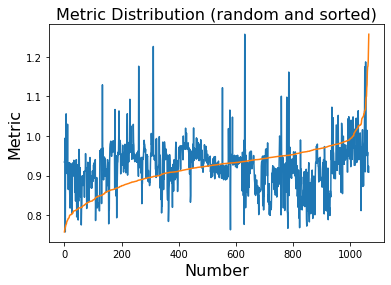

In [20]:
#list below is alloy_m without alloy labels
metrics_for_distribution_graph = [0.9340034219300541, 0.9340136020101998, 0.9943792172472191, 0.7574837317714246, 0.9756779296007395, 0.9525386431300685, 1.0559522622039295, 0.9883035981259, 0.9434070927036398, 0.9362603488987743, 0.9045448512364781, 1.0296310257157746, 0.8779595538516357, 0.8655385448733618, 0.8647976508214401, 0.8767135732721978, 0.9137177608126892, 0.9326370473352537, 0.8675358359382193, 0.8377740387983066, 0.8177673490686704, 0.9307153920085003, 0.8878151696018262, 0.9061804079838195, 0.9179290401693851, 0.8917620884113596, 0.8028629177266332, 0.9133331463907018, 0.9311661512169893, 0.9154279313747435, 0.898348078029283, 0.9320754410592164, 0.9263161438060676, 0.9384898900769147, 0.9149784301703429, 0.9247185707933508, 0.8576010813136457, 0.8631168496354319, 0.8668880640908347, 0.835486235335616, 0.8845097082085986, 0.9400253053108905, 0.9400253053108905, 0.7953662118407869, 0.8395791199693987, 0.8424245551535148, 0.9275060736964306, 0.9195326827592727, 0.7875872191000328, 0.9265270033893525, 0.8353772363232183, 0.9660242847110503, 0.9458983946406392, 0.8848227526270351, 0.8897392564331629, 0.9198984389459055, 0.8794846502731635, 0.8451761459181624, 0.8774354623651981, 0.7751032963465104, 0.8200488921484619, 0.8290690899501457, 0.8984388656746874, 0.899661929860274, 0.8749765409033466, 0.8914468165826678, 0.8966007208083442, 0.8749765409033466, 0.91006971585693, 0.899687099359532, 0.8452308331517779, 0.9090319047810728, 0.9120380471720976, 0.9120380471720976, 0.9554151652130837, 0.9224584068197, 0.9186315307617892, 0.9186315307617892, 0.816688439563872, 0.8618261081127697, 0.8459417466879242, 0.8930184864822726, 0.9335507186323019, 0.9197296770504225, 0.8789021037467676, 0.8694762209570589, 0.8348268003712336, 0.892842193149339, 0.9204796082763598, 0.9454056245321497, 0.9454056245321497, 0.8879998923641841, 0.8879998923641841, 0.9000644990722281, 0.8682144260703749, 0.8905218753654949, 0.8682144260703749, 0.8906925765238679, 0.911485371471578, 0.9028121758094054, 0.8852900101904074, 0.8942122062319455, 0.9268691191207066, 0.8928798419673418, 0.9318797713481219, 0.8980954097275266, 0.9355218162698977, 0.8992744553103724, 0.9402834096505776, 0.7863019305391588, 0.8460573806031536, 0.8504903931273179, 0.8266544466702207, 0.8949752558186106, 0.833562828811211, 0.818121978046764, 0.8485620339409919, 0.8240344553726027, 0.831367404268846, 0.8250455858450295, 0.824722205025341, 0.824677744848602, 0.8108109927075529, 0.8108109927075529, 0.9630204382284009, 0.9520596366690729, 0.9472092115992451, 0.9612138420995342, 0.9673312470386882, 0.9614793347692053, 0.8291667590906934, 0.9295024018572855, 0.9328719388317613, 1.1293691769796566, 0.9436584515933648, 0.9693960437964172, 0.9455704757372165, 0.8889956718145654, 0.9212478022349277, 0.9321031226105362, 0.94681196311135, 0.9312222689529068, 0.8984415664733909, 0.9418070332098326, 0.9005843263161922, 0.9125352998118373, 0.9172813290889936, 0.8582790148137529, 0.8964434966467506, 0.8743644921587482, 0.9230689861198971, 0.9401485233299832, 0.9313888774855732, 0.9322424532589624, 0.9095671954969837, 0.7778810508693164, 0.9078381866843418, 0.8142473884677375, 0.9207343218302358, 0.9689254782723203, 0.9798678051750209, 0.9819291914052416, 0.9867652067379971, 0.9861713204656277, 0.9690996027574884, 0.9484671143357954, 0.9815485753073486, 0.9583012945232874, 0.9803386955887928, 0.9849160879644209, 0.9870797163230837, 0.988085528368, 0.982357622720515, 0.967962433607226, 0.9589243905302618, 0.98594314414104, 0.8658623529570778, 1.0669158264172587, 0.9435246305798662, 0.9507743003911809, 0.8682159765870894, 0.8480731131154667, 0.950135256220813, 0.7931113837534443, 0.9192863076454956, 0.8888945865357197, 0.9313113494643628, 0.9351156912495566, 0.959221110164394, 0.9524328745538716, 0.9948626752068691, 1.0633070715577186, 0.9539211096658886, 0.9856731235646338, 0.9891834811563567, 0.9809786530471496, 0.981642066409583, 0.9042491515095036, 0.9544697844901531, 0.9348273733284079, 0.9522701493653365, 0.9472950702944366, 0.926532774508048, 0.9472950702944366, 0.9766484353421945, 0.9269866302820899, 0.9580841857613102, 0.90875776885164, 0.9526792045483631, 0.9526792045483631, 0.9191179947521791, 0.9284990644552189, 0.9790072520173958, 0.9509893148849176, 0.9261520716138215, 0.9068128786626466, 0.9206379527902504, 0.9355251189410625, 0.922853891738906, 0.9946965261305803, 1.0561470441458929, 0.9010774907569399, 0.950094027824725, 0.9386545127013041, 0.9668890117710794, 0.934293832984356, 0.9836658769989332, 0.9786658480111681, 0.9582876587144324, 1.0927688967567206, 0.9712425693494174, 0.959950899295811, 1.0250033171929578, 1.0250033171929578, 0.9600310160976284, 0.9760551509413594, 0.9410583751876156, 0.965008682332611, 0.9773080962453163, 0.9597274957700888, 0.9562309534275862, 1.0293661119513533, 0.9842043838291772, 0.9759637313578269, 0.9417022682724806, 0.9554689883713128, 0.9350885038744982, 0.9355468078170991, 0.9391439278091877, 0.9495008280311769, 0.9390071273098923, 0.9375766602483047, 0.9538119207362731, 0.9335741106068092, 0.957466326328142, 0.948104927551086, 0.9570612403667902, 0.9614960024375118, 0.9280872232573673, 0.8980690777852615, 1.1763453144990554, 0.9318665335613382, 0.9526383156058382, 0.9305757326843302, 0.9195188766313521, 0.930330849854303, 0.9271518823263626, 0.934734294341409, 0.9062885632403698, 0.9459223201032334, 0.9034950955487266, 0.8288731765044117, 0.876929773817506, 0.8804365716944748, 0.9458020903945856, 0.9406313542084307, 0.9435246891117269, 0.9602868196109547, 0.9730605752963615, 0.9891142667946559, 0.9789835301432394, 0.9785982408330147, 0.9700963179144356, 0.9589636750044026, 0.9663413864625975, 0.893983021080974, 0.9463407501642711, 0.8977628048649968, 0.9308747393844153, 0.9529642852606127, 0.9464955339093886, 0.9494649396854241, 0.9070935789060794, 0.8850589943505053, 0.9127107852056268, 0.8850826105860764, 0.8838224497100575, 0.8838609311476855, 0.8745818445959157, 0.8815532175094476, 0.8824814928128765, 0.9296507991145371, 0.9558813051912276, 0.9484652144156561, 1.0064753065788272, 0.9776618897269327, 0.9866740842360779, 0.9500326412786455, 0.9854709454142848, 0.9928107131748276, 0.9502343194214905, 1.2262371832604302, 0.950042681558411, 0.9514936576813101, 0.9409710880482687, 0.939468099571433, 0.9448803092931785, 0.9450838739110238, 0.9501142517016524, 0.9154372125991619, 0.9902682193313302, 0.8950626890677987, 0.9935596197378339, 0.9396982833191629, 0.9146534744202657, 0.9146534744202657, 0.8998286134125725, 0.9121034660227266, 0.9212020658779863, 0.9214157192904583, 0.9258736097953502, 0.9279874485962961, 0.9983274945892598, 0.9248484730918987, 0.8685848366077576, 0.9515474950536926, 0.9383916543244055, 0.8654237427098771, 0.8392985546684929, 0.9011132073221316, 0.8054697647646359, 0.8375365497820098, 0.8229699620064012, 0.8774043782535557, 0.9843860827965031, 0.9684786296675892, 0.9433021625963626, 0.8645924817818341, 0.9236437926805591, 0.8915660891186626, 0.985020801381283, 0.9762485968459982, 0.9653709197452679, 0.9466138192398509, 0.9400696204006971, 0.9672639568663688, 0.9498764780690071, 0.9553258966802168, 0.9502287815226828, 0.9485005049597895, 0.8626399091039176, 0.838440869299331, 0.9512020649357641, 0.9448766408925274, 0.7839356399834541, 0.8149534970853418, 0.867230282897116, 0.8799061134068683, 0.9528263723899224, 0.9388876270337633, 0.9062582832548894, 0.8861981045467096, 0.9130378412162371, 0.9198408444627938, 0.9104539511115055, 0.9186481044865438, 0.8801958266016944, 0.8932925418028844, 0.8195466776381881, 0.9280061399956683, 0.9187646354603005, 0.8792671014443402, 0.860639477670445, 0.8803540434549131, 0.940034277556095, 0.8981756587025778, 0.9301166619689925, 0.889369253349728, 0.9203575882058772, 0.9639790997852461, 0.9843660898954848, 0.928775320526338, 0.8946088271370507, 0.9081136040282447, 0.938176061606942, 0.8957671085627404, 0.8596751558023124, 0.8823395026782954, 0.9148711894948446, 0.9236490903594817, 0.9704968422525435, 0.9691765984055732, 0.9723523554750181, 0.9596408474545743, 0.9452032480235373, 0.9750873438441808, 0.915430368550605, 0.9170682924897364, 0.973320371467207, 0.9720086791875606, 0.9751664633709555, 0.9750622658546407, 0.9697051215407304, 0.9691199568824432, 0.9487749242294434, 0.9397988020540595, 0.9999758418444775, 0.9661601876598622, 0.9705342748035112, 0.9821055130292585, 0.9801528229337517, 0.9785076482334881, 0.981825464860641, 0.966155689758843, 1.0197825356917836, 0.9816156784689063, 0.9675712678954936, 1.0075355808367843, 0.9712081969327925, 0.9709420822101015, 0.9664525997662585, 0.9664697919816038, 0.9672024855380691, 0.9826581468239702, 0.9639083884468654, 0.9569792613673582, 0.921062373804408, 0.9696383005422264, 0.9036551781143568, 0.9657203518176698, 0.9519174228918035, 0.832543970666185, 0.848969132073888, 0.9406568767461254, 0.9341237905984819, 0.9333836400936907, 0.9593291882790272, 0.9564461874468586, 0.9635444678835585, 0.9191966468304628, 0.9795850384153416, 0.9588738845043241, 1.0203400797418862, 0.93783605844879, 0.9528454156776788, 0.9690963794115354, 0.9676688092235657, 0.9559234818179326, 0.9437322931613459, 0.9451522223868531, 0.953630842423569, 0.9417533739903456, 0.9952252360760372, 0.9424104950662644, 0.9923940754471572, 0.98833421962798, 0.9477300799303948, 0.9479878158171701, 0.9829178730527139, 0.9624683313090158, 0.9381530526187978, 0.9784649822547086, 0.9377770473291558, 0.9382552924827497, 0.9795268174398533, 0.9552177624532505, 0.9428829263901395, 0.9905082007279532, 0.9754618385265926, 0.9250487781348327, 0.9219427439448085, 0.9645679333052335, 0.9183753456170718, 0.9235493172483286, 0.9401791684918129, 0.9082943421404204, 0.9272269891120632, 0.9292236012416836, 0.9307507218301042, 0.9372619311314008, 0.9778692437354298, 0.9625315215056135, 0.948475832718655, 0.9684647538292858, 0.9638827196497775, 0.9738826986592898, 0.9360030159780907, 0.9638827196497775, 0.9484705894367537, 0.9316628929505899, 0.9312156084736996, 0.9534347004124877, 0.9366707427740096, 0.923390435837912, 0.926378933021739, 0.9333527397039999, 0.9437412865168539, 0.9428812123809704, 0.9421934573204718, 0.9378318445597561, 0.9490202253088912, 0.90946836016189, 0.9168438661105703, 0.8949737735238766, 0.9074789509917939, 0.8959192907411375, 0.927795944650683, 0.9241724776904499, 0.8982612226305925, 0.9420769663867898, 0.9152279454785349, 0.9120022421528529, 0.9097922827506602, 0.924573550191836, 0.947317092334785, 0.9095079668318236, 0.8917740404281844, 0.9215936082735098, 0.9479827211934094, 0.9102178428952711, 0.9164036606800688, 0.9208203932622331, 0.9297340556869984, 0.9081261104582034, 0.9319013468858, 0.9117581108092149, 0.9039359670263065, 0.925375057332243, 0.9241512272751771, 0.9365354381181508, 0.8995996277942562, 0.9135220542634634, 0.8947975671651338, 0.9082748982494359, 0.9240754886425907, 0.9053104756787869, 0.9066200936680355, 0.9276799760388704, 0.92226064418131, 0.9071962566508557, 0.892931963157244, 0.9081197121444179, 0.9219829695156466, 1.1219900605997635, 0.9090341641517464, 0.893525983459548, 0.9153115226017512, 0.8894058406181923, 0.9249164393078739, 0.9092686559569516, 0.9066288463463158, 0.8949924810948126, 0.9055424054816079, 0.9105169566359713, 0.8887581520094174, 0.9247784190140513, 0.9268104387128862, 0.9084285913319755, 0.8906581828151532, 0.9219370222951728, 0.9232040453139936, 0.9119127213455667, 0.8965145340354265, 0.8968985742357592, 1.0187330827607324, 0.9491373923598109, 0.9297234750590336, 0.9360229037115033, 0.9410211709240834, 1.0654348213463842, 0.8686607102644543, 0.7628316264622054, 0.9319745800832446, 0.9535473079915661, 0.9509172407672161, 0.9437315070103268, 0.9320432212569724, 0.9486546220129008, 1.0476546769858643, 0.9283358432483229, 0.9263552112373374, 0.9463905069932692, 0.9322210889571875, 0.9355842782347604, 0.9481538633988147, 0.9511191229918551, 0.9280291628658683, 0.9486492294954967, 0.9341932799516469, 0.9221430059817224, 0.9493447761593453, 0.9295723337467062, 0.9272158696389308, 0.9503475676740112, 0.9195249266511858, 0.9212613163196406, 0.9512384051264118, 0.9289674523353938, 0.9327264529766809, 0.9299037607217242, 0.9451685227195198, 0.930483139282939, 0.9333166711223151, 0.9324698439965291, 0.9357246415913091, 0.9373335436108194, 0.9474774823878176, 0.9329733154896057, 0.9446476716888802, 0.937650160550822, 0.93387081512396, 0.9407499712611576, 0.8609073400621383, 0.9587746531115292, 0.9367731405759661, 0.921785021465456, 0.8493086451231259, 0.8692772451655956, 0.9891435081841425, 0.7765209230912259, 0.8634831977650926, 1.2571555255054832, 0.8634831977650926, 0.9664340732951474, 0.8186067786717722, 0.8719165754273224, 0.951050155558585, 0.9171069442263735, 0.885328232851729, 0.8945773866470996, 0.8573438666358455, 0.9329128844185023, 0.8856899682518988, 0.8482089826243047, 0.8482089826243047, 0.9291774671843963, 0.870231710799358, 0.9362580229009759, 0.9583490065509993, 0.9045742340906461, 0.9592625689554718, 0.9612968756279427, 0.960578803961975, 0.9504751845796099, 0.9615358086260086, 0.9454072095129804, 0.9168729900549877, 0.9235779739026782, 0.9316781252857885, 0.9332464126551444, 0.9344038296688983, 0.9316256038106949, 0.9505627678666682, 0.9304463707059166, 0.9117520616100823, 0.8898922607017745, 0.8807690453278839, 0.8529370266279944, 0.9013734433979731, 0.8496686958380727, 0.8622999224263161, 0.8732472679376109, 0.8886287807554305, 0.8886287807554305, 0.8684407205756896, 0.8541456882396696, 0.8743612524233211, 0.8294677462311593, 0.849081630201119, 0.8505179274335439, 0.8011771196469106, 0.8697394526524398, 0.8609672309764768, 0.858324206359533, 0.8592784651962198, 0.8644571256680212, 0.8604226780270553, 0.8646488741741821, 0.8646488741741821, 0.9236126679938388, 0.9343301679639696, 0.9324355282238895, 0.9183440948820107, 0.9481864877323286, 0.8236245577413656, 0.9494530246379889, 0.9316116262223029, 0.8129906134891011, 0.8479134049874105, 0.8479134049874105, 0.9500021348654538, 0.877123311428047, 0.9082992798360567, 0.9435531532317978, 0.965824817899659, 0.9656968910530166, 0.9674150933717757, 0.9667119440323164, 0.9668696674130158, 0.9676232138393605, 0.8990794007935411, 0.9825461991379282, 0.8328999094178292, 0.8339636752590904, 0.8524223654811424, 0.827242908032013, 0.8795539222708475, 0.8011965712388125, 0.8352968455835301, 0.832028240282395, 0.7993315014554829, 0.8267199615916044, 0.8193588707820296, 0.8135951426702203, 0.819276487010441, 0.8633053309280717, 0.906065071581034, 0.883484795060999, 0.9112560962497507, 0.924810078295535, 0.8834642838313875, 0.9112560962497507, 0.9222805553381783, 0.9175972999240709, 0.8645172141964419, 0.8814280369715718, 0.859047946501374, 0.9139277975235796, 0.8506014100856758, 0.9177254276778771, 0.8690578781250058, 0.8787447873352245, 0.872678593665895, 0.8456071167224279, 0.8836525021020104, 0.9170101376379286, 0.8752732727164124, 0.9194628632614257, 0.872200556283805, 0.9196621625391156, 0.8771525864099877, 0.9212548608254763, 0.9777000995574395, 0.9999664835348749, 0.9869976868603221, 0.9754028800248353, 0.9681531299818198, 0.943151736089973, 0.8004726699396949, 1.1004712944663655, 0.9490047544046435, 0.9233735928644988, 0.9502161466721615, 0.9269694552207067, 0.946255649696464, 0.8835744703757485, 0.818015543625637, 0.9206881252085506, 0.9299088327455356, 0.8821831745838031, 0.8658488288409721, 0.8116236514692694, 0.9076604129426866, 0.9058604033231361, 0.8999069501932428, 0.9319444525996118, 0.8843793153573525, 0.8582186735286275, 1.0980449571506563, 0.9425826896646712, 0.8099375451647387, 0.8041812700642244, 0.766671244597875, 0.9535822510328306, 0.9426116203042051, 1.1614942202362628, 0.8494098783641677, 0.8855274251871158, 0.9340522856187179, 0.9717259079074667, 0.943144531970476, 0.9350531228076286, 0.9074088255151501, 0.8946804703936374, 0.8976505065133699, 0.893058769664814, 0.9308773689487805, 0.9419611263939859, 0.9217212480995367, 0.9052298459355622, 0.9055778233425699, 0.9300863897279336, 0.9598802939292124, 0.9403353841988631, 0.9310216830138839, 0.9208811064232271, 0.8993276974284362, 0.921447764262687, 0.9596416681846297, 0.8978962406410479, 0.8667594056698281, 0.9503725723845043, 0.8978172473057878, 0.8978172473057878, 0.9248279990725952, 0.8475901539343079, 0.8718073384029255, 0.8520631822231599, 0.8195325234890155, 0.9140877934685593, 0.8823642479347787, 0.7922687946496481, 0.8181544953931841, 0.7681312719041252, 0.8388819612345698, 0.8144328755451533, 0.9898720966443032, 0.891054181244319, 0.916369630870226, 0.8779301645614348, 0.8964204369131575, 0.864093289613021, 0.8131592119428824, 0.8483764619495748, 0.8317122935057942, 0.8235193595641387, 0.8396100655503815, 0.8640866999021266, 0.8281215402329639, 0.9097088182340017, 0.8596210726977177, 0.8215259287773365, 0.8396822116675703, 0.8307557223527113, 0.83530559794731, 0.83530559794731, 0.9158623606987989, 0.7912178857473989, 0.7722163120180864, 0.8364443556931239, 0.8095356104148015, 0.8192429793249284, 0.908126966630521, 0.8434966410560972, 0.9098110613886442, 0.932418710429424, 0.8054850208947739, 0.7828015950886599, 0.8444935089587923, 0.8726208336499917, 0.8818462187082852, 0.8416073039277105, 0.803538613063243, 0.8114891282600932, 0.8842505009306704, 0.892840089048716, 0.886714453605581, 0.9137958378886577, 0.8350777119038246, 0.7915066657227755, 0.8343349119479393, 0.8343349119479393, 0.8983060937082292, 0.8983060937082292, 0.8869058365417675, 0.8143766766359907, 0.801235440553513, 0.801235440553513, 0.906781959140522, 0.9317206722710176, 0.9356183128686119, 0.9377047732148869, 0.9746410121770669, 0.9309654146093926, 0.9387609899595073, 0.9794866806116209, 0.9344185067042624, 0.9438170040991483, 0.9233417786070756, 0.9213962419619737, 0.8837625728389624, 0.8883900678361633, 0.895742994970826, 0.9090850694411443, 0.9064362222453705, 0.9461335126357422, 0.8954333149763495, 0.889894951537628, 0.889894951537628, 0.8864864278498904, 0.8950714316448688, 0.8762560347281344, 0.8705663687559725, 0.9160856651644137, 0.9287426625673021, 0.9327541808147533, 0.9229098058365712, 0.940430970102106, 0.8527791626532731, 0.8029910425925034, 0.9732377239927941, 0.9157423083474536, 0.8782157123433479, 0.8125141741584493, 0.8540938477882217, 0.9363028626637155, 0.8905276598988043, 0.8105726382221494, 0.8989672974887374, 0.8319149115159588, 0.8489563759677671, 0.810362407765476, 0.9188894085093265, 0.7884325701981741, 0.8306517224809173, 0.8540038265579948, 0.8182481424032887, 0.8182481424032887, 0.8182481424032887, 0.799044744328772, 0.8615813957206591, 0.8604868684641195, 0.8458731856269807, 0.963170265796035, 0.9400901950608194, 0.9544212985055249, 1.0727887498534117, 0.9599365195774765, 0.9045351945832549, 0.9372247851452412, 1.0462237512881174, 0.961448638539996, 0.9560303355082761, 0.9149515544017375, 0.8923656677849301, 0.9085602665390718, 0.9352705609466444, 0.9267769948937006, 0.8918671303741106, 0.9320043512136305, 0.9324327954376805, 1.0274509336079884, 1.0274509336079884, 1.0274509336079884, 0.9129862184799507, 0.9593157850706753, 0.9757613723368852, 0.9604547819259793, 1.0520556702666108, 0.9283736473408901, 0.9429572674087453, 0.9331744604799044, 0.940508968355027, 0.9035259190079398, 0.970614832502198, 0.9629462954964607, 0.9167856575233552, 0.9021715520365938, 0.8575428145151057, 0.9256400367132476, 1.032186631588716, 1.0128941578607324, 0.9351451173722608, 0.8542585573597768, 0.9557020163125683, 0.9399586439194353, 0.9995266324703193, 0.9297724388248158, 0.9783839217108224, 0.9283810638487383, 0.9701604089404032, 0.9569487174732068, 0.9392910821361835, 0.9388875991343913, 0.9772848876350055, 0.9469883279388109, 0.9427824057966246, 0.9457662500447666, 0.961524197093416, 0.965826574711178, 0.9087450236855876, 0.9087450236855876, 1.0163881165904982, 1.0440783812768184, 0.9718946488204578, 1.048793157119595, 0.9482887173422273, 0.9808465423998507, 0.9419894186561873, 0.9526175268979092, 0.9502275587537907, 0.9571118066561451, 0.9223813040481975, 1.0398395117877757, 0.9567715489503469, 1.0126753350633524, 1.0002372685897671, 0.9406734468215412, 0.9791444415166182, 0.9979877471794956, 1.0482634606872814, 1.0266816685707016, 0.9692054440851012, 1.0175761324024701, 0.9259714655348487, 0.9259714655348487, 0.9259714655348487, 0.9259714655348487, 0.9299821102983633, 0.9748573344890458, 0.9507009883957632, 1.0449719971870233, 0.9958849108138025, 0.9332215245002043, 1.0092545760019038, 1.0251334557885665, 1.0183073267020581, 1.025261384188621, 1.0637930177960306, 0.9753359615912737, 0.9400512445548376, 0.94667984819002, 0.949751931120633, 0.9877655475468076, 0.9877655475468076, 1.0077148888337082, 0.956099071515926, 0.9139651859469782, 0.8112925991963581, 0.9722668281860699, 0.9623377089421824, 0.8744304767523731, 0.9793593829601163, 1.0158750736394957, 0.8724643457918276, 0.9611734979625884, 0.8757710295973273, 0.874503615257463, 0.9737329106193087, 0.9857324056941413, 1.0273777198699743, 1.1746272014123016, 0.9097680713305957, 0.9097680713305957, 1.1872202096168385, 0.9768854602469825, 0.9528767103283751, 0.9740026273146909, 1.0114373850216056, 1.0141753829439897, 0.9493420182110963, 0.9588651563413374, 0.9086073616449745, 0.912877038773464, 0.9236140632619512, 0.9090329788747169]
x = []
for item in range(0,1066):
    x.append(item)
    
plt.xlabel('Number',fontsize = 16)

plt.ylabel('Metric',fontsize = 16)

plt.plot(x,metrics_for_distribution_graph)

sorted_distribution = np.sort(metrics_for_distribution_graph)
plt.xlabel('Number',fontsize = 16)

plt.ylabel('Metric',fontsize = 16)
plt.title('Metric Distribution (random and sorted)',fontsize = 16)

plt.plot(x,sorted_distribution)

In [26]:
bottom_ten = []
for item in range(0,10):
    bottom_ten.append(sorted_distribution[item])

bottom_ten_alloys = []    
for item in alloys_with_metrics:
    for j in bottom_ten:
        if item[1] == j:
            bottom_ten_alloys.append(item)
    else:
        pass
bottom_ten_alloys = [['Name', 'Metric Value'],['Na2LiAu3', 0.7574837317714246], ['LiSnPd2', 0.7751032963465104], ['BaNaBi', 0.7778810508693164], ['Ca2AlPt2', 0.7839356399834541], ['AlCuPt2', 0.7628316264622054], ['YAl2Pd5', 0.7765209230912259], ['K2BiAu', 0.766671244597875], ['Ca2GaPt2', 0.7681312719041252], ['Ca2CdPt2', 0.7722163120180864], ['Ca2InPt2', 0.7828015950886599]]
print(tabulate(bottom_ten_alloys))


sorted_distribution = sorted(sorted_distribution,reverse = True)

top_ten = []
for item in range(0,10):
    top_ten.append(sorted_distribution[item])

top_ten_alloys = []    
for item in alloys_with_metrics:
    for j in top_ten:
        if item[1] == j:
            top_ten_alloys.append(item)
    else:
        pass
    
top_ten_alloys = [['Name', 'Metric Value'],['NaMnBi', 1.1293691769796566], ['MgGaAu2', 1.1763453144990554], ['GdMg2Ag', 1.2262371832604302], ['Gd2AlNi2', 1.1219900605997635], ['YAlPd2', 1.2571555255054832], ['K2RbPt', 1.1004712944663655], ['CsK2Pt', 1.0980449571506563], ['Ca(MnBi)2', 1.1614942202362628], ['MnSnIr', 1.1746272014123016], ['MnSnAu', 1.1872202096168385]]
print(tabulate(top_ten_alloys))






--------  ------------------
Name      Metric Value
Na2LiAu3  0.7574837317714246
LiSnPd2   0.7751032963465104
BaNaBi    0.7778810508693164
Ca2AlPt2  0.7839356399834541
AlCuPt2   0.7628316264622054
YAl2Pd5   0.7765209230912259
K2BiAu    0.766671244597875
Ca2GaPt2  0.7681312719041252
Ca2CdPt2  0.7722163120180864
Ca2InPt2  0.7828015950886599
--------  ------------------
---------  ------------------
Name       Metric Value
NaMnBi     1.1293691769796566
MgGaAu2    1.1763453144990554
GdMg2Ag    1.2262371832604302
Gd2AlNi2   1.1219900605997635
YAlPd2     1.2571555255054832
K2RbPt     1.1004712944663655
CsK2Pt     1.0980449571506563
Ca(MnBi)2  1.1614942202362628
MnSnIr     1.1746272014123016
MnSnAu     1.1872202096168385
---------  ------------------


In [27]:
st = stat.pstdev(sorted_distribution)
print(st)

meann = stat.mean(sorted_distribution)
print(meann)

mode = stat.mode(sorted_distribution)
print(mode)


0.05847506832620991
0.9214579223690366
0.9259714655348487


In [11]:
#DATAFRAME FOR MODEL CREATION

In [43]:
# Atomic property list for each element from "metals" in the metric calculation programs. Lists associated with
#properties seen below in the program. Sourced from github table referenced in paper. 
atomic_property_list = [[92.906372, 5017.0, 8.57, 2750.0, 41, 'Nb', 88.516, 1.6, 640], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [87.621, 1650.0, 2.64, 1050.0, 38, 'Sr', 5.023, 0.95, 403], [164.930332, 2873.0, 8.79, 1734.0, 67, 'Ho', 32.61, 1.23, 573], [9.01218315, 2742.0, 1.85, 1560.0, 4, 'Be', -48.0, 1.57, 899], [168.934222, 2223.0, 9.32, 1818.0, 69, 'Tm', 99.0, 1.25, 589], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719], [88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870], [40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [238.028913, 4404.0, 19.1, 1405.3, 92, 'U', 50.94, 1.38, 899], [151.9641, 1802.0, 5.264, 1099.0, 63, 'Eu', 11.2, 1.2, 544], [50.94151, 3680.0, 6.0, 2183.0, 23, 'V', 50.911, 1.63, 650], [144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [173.0451, 1469.0, 6.9, 1097.0, 70, 'Yb', -1.93, 1.1, 596], [140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652], [157.253, 3273.0, 7.9, 1585.0, 64, 'Gd', 13.22, 1.2, 547], [183.841, 6203.0, 19.25, 3695.0, 74, 'W', 78.76, 2.36, 761], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710], [132.905451966, 944.0, 1.93, 301.7, 55, 'Cs', 45.505, 0.79, 708], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [180.947882, 5731.0, 16.69, 3290.0, 73, 'Ta', 31.0, 1.5, 658], [178.492, 4876.0, 13.31, 2506.0, 72, 'Hf', 17.18, 1.3, 523], [91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [95.951, 4912.0, 10.28, 2896.0, 42, 'Mo', 72.1, 2.16, 652], [162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [232.03774, 5061.0, 11.724, 2023.0, 90, 'Th', 112.72, 1.3, 703], [174.96681, 3675.0, 9.841, 1925.0, 71, 'Lu', 33.4, 1.27, 603], [39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745], [204.38, 1746.0, 11.85, 577.0, 81, 'Tl', 36.4, 1.62, 1007], [190.233, 5285.0, 22.59, 3306.0, 76, 'Os', 103.99, 2.2, 760], [137.3277, 2118.0, 3.51, 1000.0, 56, 'Ba', 13.954, 0.89, 375], [22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760], [44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762], [186.2071, 5869.0, 21.02, 3459.0, 75, 'Re', 5.8273, 1.9, 770], [101.072, 4423.0, 12.45, 2607.0, 44, 'Ru', 100.96, 2.2, 684], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [65.382, 1180.0, 7.14, 692.68, 30, 'Zn', -58.0, 1.65, 906], [85.46783, 961.0, 1.532, 312.45, 37, 'Rb', 46.884, 0.82, 762], [112.4144, 1040.0, 8.65, 594.22, 48, 'Cd', -68.0, 1.69, 731], [138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [158.925352, 3396.0, 8.23, 1629.0, 65, 'Tb', 112.4, 1.1, 593], [167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [192.2173, 4403.0, 22.56, 2719.0, 77, 'Ir', 150.94, 2.2, 840], [200.5923, 629.88, 13.534, 234.321, 80, 'Hg', -48.0, 2.0, 890], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]]

In [45]:
##Create list of atomic properties of constituents of each alloy and assemble them into an list to be converted into
##a pandas dataframe to be fed into the ML model. 

#labeled_dataframe = []

#for item in alloys_with_metrics: 
#    weights = tccf(item[0])
#    i = item[0]
#    ii = list(names(i))
#    constituent_properties = [0,0,0]
#    full_properties = []
#    for j in atomic_property_list:
#        if j[5] == ii[0]:
#            constituent_properties[0] = j
#        elif j[5] == ii[1]:

#            constituent_properties[1] = j
#        elif j[5] == ii[2]:

#            constituent_properties[2] = j       
#        else: 
#            pass
#    full_properties.append(i)
#    full_properties.append(constituent_properties) 
#    full_properties.append(item[1])
#    labeled_dataframe.append(full_properties)            

In [46]:
labeled_dataframe = [['Na2Li5Sn4', [[22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9340034219300541], ['NaLi5Sn4', [[22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9340136020101998], ['Ba19Na29Li13', [[137.3277, 2118.0, 3.51, 1000.0, 56, 'Ba', 13.954, 0.89, 375], [22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520]], 0.9943792172472191], ['Na2LiAu3', [[22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.7574837317714246], ['LiMg2Ga', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.9756779296007395], ['Li2MgIn', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867]], 0.9525386431300685], ['LiMgIr', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [192.2173, 4403.0, 22.56, 2719.0, 77, 'Ir', 150.94, 2.2, 840]], 1.0559522622039295], ['LiMg2Tl', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [204.38, 1746.0, 11.85, 577.0, 81, 'Tl', 36.4, 1.62, 1007]], 0.9883035981259], ['Li2MgTl', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [204.38, 1746.0, 11.85, 577.0, 81, 'Tl', 36.4, 1.62, 1007]], 0.9434070927036398], ['Li2MgPb', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]], 0.9362603488987743], ['LiMgBi', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.9045448512364781], ['LiCaAl3', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577]], 1.0296310257157746], ['Li2AlRh', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.8779595538516357], ['LiAl2Rh', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.8655385448733618], ['Li2AlPd', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8647976508214401], ['LiAl2Pd', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8767135732721978], ['LiAlAg2', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804]], 0.9137177608126892], ['Li2AlAg', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804]], 0.9326370473352537], ['LiAl2Ir', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [192.2173, 4403.0, 22.56, 2719.0, 77, 'Ir', 150.94, 2.2, 840]], 0.8675358359382193], ['LiAl2Pt', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8377740387983066], ['Li2AlPt', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8177673490686704], ['K2LiSn4', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9307153920085003], ['LiCaSn', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.8878151696018262], ['Li5Ca7Sn11', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9061804079838195], ['Li6Ca17Hg9', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [200.5923, 629.88, 13.534, 234.321, 80, 'Hg', -48.0, 2.0, 890]], 0.9179290401693851], ['LiCaPb', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]], 0.8917620884113596], ['LiCaBi', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.8028629177266332], ['LiNi2Sn', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9133331463907018], ['Li13(Ga7Cu2)3', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9311661512169893], ['Li2CuSn2', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9154279313747435], ['Li2CuSn', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.898348078029283], ['LiCu2Sn', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9320754410592164], ['Li2ZnSn', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [65.382, 1180.0, 7.14, 692.68, 30, 'Zn', -58.0, 1.65, 906], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9263161438060676], ['Li3(ZnSn2)2', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [65.382, 1180.0, 7.14, 692.68, 30, 'Zn', -58.0, 1.65, 906], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9384898900769147], ['LiYGa4', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.9149784301703429], ['LiGa2Ru', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [101.072, 4423.0, 12.45, 2607.0, 44, 'Ru', 100.96, 2.2, 684]], 0.9247185707933508], ['Li2GaRh', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.8576010813136457], ['LiGa2Rh', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.8631168496354319], ['LiGa2Pd', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8668880640908347], ['Li2GaPd', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.835486235335616], ['LiGa2Ir', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [192.2173, 4403.0, 22.56, 2719.0, 77, 'Ir', 150.94, 2.2, 840]], 0.8845097082085986], ['Li2GaIr', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [192.2173, 4403.0, 22.56, 2719.0, 77, 'Ir', 150.94, 2.2, 840]], 0.9400253053108905], ['Li2GaIr', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [192.2173, 4403.0, 22.56, 2719.0, 77, 'Ir', 150.94, 2.2, 840]], 0.9400253053108905], ['Li2GaPt', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.7953662118407869], ['LiGa2Pt', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8395791199693987], ['Li2GaAu', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8424245551535148], ['Rb2LiSn4', [[85.46783, 961.0, 1.532, 312.45, 37, 'Rb', 46.884, 0.82, 762], [6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9275060736964306], ['Sr17(Li2Hg3)3', [[87.621, 1650.0, 2.64, 1050.0, 38, 'Sr', 5.023, 0.95, 403], [6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [200.5923, 629.88, 13.534, 234.321, 80, 'Hg', -48.0, 2.0, 890]], 0.9195326827592727], ['SrLiBi', [[87.621, 1650.0, 2.64, 1050.0, 38, 'Sr', 5.023, 0.95, 403], [6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.7875872191000328], ['Li2Y5In9', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867]], 0.9265270033893525], ['Li3YBi2', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.8353772363232183], ['LiIn2Ru', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [101.072, 4423.0, 12.45, 2607.0, 44, 'Ru', 100.96, 2.2, 684]], 0.9660242847110503], ['LiSn4Ru', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [101.072, 4423.0, 12.45, 2607.0, 44, 'Ru', 100.96, 2.2, 684]], 0.9458983946406392], ['Li2InRh', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.8848227526270351], ['LiIn2Rh', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.8897392564331629], ['LiSn4Rh', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.9198984389459055], ['LiSn5Rh3', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.8794846502731635], ['Li2InPd', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8451761459181624], ['LiIn2Pd', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8774354623651981], ['LiSnPd2', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.7751032963465104], ['LiTlPd2', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [204.38, 1746.0, 11.85, 577.0, 81, 'Tl', 36.4, 1.62, 1007], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8200488921484619], ['LiPd2Pb', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]], 0.8290690899501457], ['Li2InAg', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804]], 0.8984388656746874], ['LiInAg2', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804]], 0.899661929860274], ['Li2AgSn', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.8749765409033466], ['Li17(AgSn2)3', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.8914468165826678], ['LiAg2Sn', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.8966007208083442], ['Li2AgSn', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.8749765409033466], ['Li2AgSn2', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.91006971585693], ['Li2AgPb', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]], 0.899687099359532], ['Li2AgBi', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.8452308331517779], ['Li2CdSn', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [112.4144, 1040.0, 8.65, 594.22, 48, 'Cd', -68.0, 1.69, 731], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9090319047810728], ['Li2CdPb', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [112.4144, 1040.0, 8.65, 594.22, 48, 'Cd', -68.0, 1.69, 731], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]], 0.9120380471720976], ['Li2CdPb', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [112.4144, 1040.0, 8.65, 594.22, 48, 'Cd', -68.0, 1.69, 731], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]], 0.9120380471720976], ['LiInSn', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9554151652130837], ['LiIn2Ir', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [192.2173, 4403.0, 22.56, 2719.0, 77, 'Ir', 150.94, 2.2, 840]], 0.9224584068197], ['Li2InIr', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [192.2173, 4403.0, 22.56, 2719.0, 77, 'Ir', 150.94, 2.2, 840]], 0.9186315307617892], ['Li2InIr', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [192.2173, 4403.0, 22.56, 2719.0, 77, 'Ir', 150.94, 2.2, 840]], 0.9186315307617892], ['Li2InPt', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.816688439563872], ['LiIn2Pt', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8618261081127697], ['Li2InAu', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8459417466879242], ['Ba3(LiSn2)4', [[137.3277, 2118.0, 3.51, 1000.0, 56, 'Ba', 13.954, 0.89, 375], [6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.8930184864822726], ['LiSn4Ir', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [192.2173, 4403.0, 22.56, 2719.0, 77, 'Ir', 150.94, 2.2, 840]], 0.9335507186323019], ['LiSn4Au3', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.9197296770504225], ['Li2Sn2Au', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8789021037467676], ['LiSnAu', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8694762209570589], ['Li2SnAu', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8348268003712336], ['LiLaSn2', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.892842193149339], ['LiCeSn2', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9204796082763598], ['LiCeSn', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9454056245321497], ['LiCeSn', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9454056245321497], ['LiPrSn', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.8879998923641841], ['LiPrSn', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.8879998923641841], ['LiPrSn2', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9000644990722281], ['LiNdSn', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.8682144260703749], ['LiNdSn2', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.8905218753654949], ['LiNdSn', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.8682144260703749], ['LiSmSn', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.8906925765238679], ['LiSmSn2', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.911485371471578], ['Li6Eu5Sn9', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [151.9641, 1802.0, 5.264, 1099.0, 63, 'Eu', 11.2, 1.2, 544], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9028121758094054], ['LiGdSn', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [157.253, 3273.0, 7.9, 1585.0, 64, 'Gd', 13.22, 1.2, 547], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.8852900101904074], ['LiDySn', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.8942122062319455], ['LiDySn2', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9268691191207066], ['LiHoSn', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [164.930332, 2873.0, 8.79, 1734.0, 67, 'Ho', 32.61, 1.23, 573], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.8928798419673418], ['LiHoSn2', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [164.930332, 2873.0, 8.79, 1734.0, 67, 'Ho', 32.61, 1.23, 573], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9318797713481219], ['LiErSn', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.8980954097275266], ['LiErSn2', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9355218162698977], ['LiTmSn', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [168.934222, 2223.0, 9.32, 1818.0, 69, 'Tm', 99.0, 1.25, 589], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.8992744553103724], ['LiTmSn2', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [168.934222, 2223.0, 9.32, 1818.0, 69, 'Tm', 99.0, 1.25, 589], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9402834096505776], ['Ba3(LiBi)4', [[137.3277, 2118.0, 3.51, 1000.0, 56, 'Ba', 13.954, 0.89, 375], [6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.7863019305391588], ['Li2TlAu', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [204.38, 1746.0, 11.85, 577.0, 81, 'Tl', 36.4, 1.62, 1007], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8460573806031536], ['Li2PbAu', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8504903931273179], ['Li2BiAu', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8266544466702207], ['LiYbPb', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [173.0451, 1469.0, 6.9, 1097.0, 70, 'Yb', -1.93, 1.1, 596], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]], 0.8949752558186106], ['LiLaBi2', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.833562828811211], ['Li3LaBi2', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.818121978046764], ['Li3CeBi2', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.8485620339409919], ['Li3PrBi2', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.8240344553726027], ['Li3SmBi2', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.831367404268846], ['Li7(Eu2Bi3)2', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [151.9641, 1802.0, 5.264, 1099.0, 63, 'Eu', 11.2, 1.2, 544], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.8250455858450295], ['LiEuBi', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [151.9641, 1802.0, 5.264, 1099.0, 63, 'Eu', 11.2, 1.2, 544], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.824722205025341], ['Li3GdBi2', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [157.253, 3273.0, 7.9, 1585.0, 64, 'Gd', 13.22, 1.2, 547], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.824677744848602], ['LiYbBi', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [173.0451, 1469.0, 6.9, 1097.0, 70, 'Yb', -1.93, 1.1, 596], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.8108109927075529], ['LiYbBi', [[6.94, 1603.0, 0.534, 453.65, 3, 'Li', 59.6326, 0.98, 520], [173.0451, 1469.0, 6.9, 1097.0, 70, 'Yb', -1.93, 1.1, 596], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.8108109927075529], ['Ta6Be15Cu8', [[180.947882, 5731.0, 16.69, 3290.0, 73, 'Ta', 31.0, 1.5, 658], [9.01218315, 2742.0, 1.85, 1560.0, 4, 'Be', -48.0, 1.57, 899], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9630204382284009], ['LaBeCu12', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [9.01218315, 2742.0, 1.85, 1560.0, 4, 'Be', -48.0, 1.57, 899], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9520596366690729], ['Na2MgSn', [[22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9472092115992451], ['Na2MgPb', [[22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]], 0.9612138420995342], ['K(NaIn3)3', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867]], 0.9673312470386882], ['K3(Na13In24)2', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867]], 0.9614793347692053], ['K29NaHg48', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [200.5923, 629.88, 13.534, 234.321, 80, 'Hg', -48.0, 2.0, 890]], 0.8291667590906934], ['Na4CaSn6', [[22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9295024018572855], ['Na10CaSn12', [[22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9328719388317613], ['NaMnBi', [[22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 1.1293691769796566], ['Na6ZnSn2', [[22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [65.382, 1180.0, 7.14, 692.68, 30, 'Zn', -58.0, 1.65, 906], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9436584515933648], ['Na17In12Ga29', [[22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.9693960437964172], ['Na10(Ga2Sn)3', [[22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9455704757372165], ['Na(GaAu2)2', [[22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8889956718145654], ['Na2SrSn4', [[22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [87.621, 1650.0, 2.64, 1050.0, 38, 'Sr', 5.023, 0.95, 403], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9212478022349277], ['Na10SrSn12', [[22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [87.621, 1650.0, 2.64, 1050.0, 38, 'Sr', 5.023, 0.95, 403], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9321031226105362], ['Na3In2Ag', [[22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804]], 0.94681196311135], ['Na2CdSn', [[22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [112.4144, 1040.0, 8.65, 594.22, 48, 'Cd', -68.0, 1.69, 731], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9312222689529068], ['Na6Cd16Au7', [[22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [112.4144, 1040.0, 8.65, 594.22, 48, 'Cd', -68.0, 1.69, 731], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8984415664733909], ['Na2CdPb', [[22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [112.4144, 1040.0, 8.65, 594.22, 48, 'Cd', -68.0, 1.69, 731], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]], 0.9418070332098326], ['Na2In5Au6', [[22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.9005843263161922], ['NaIn2Au', [[22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.9125352998118373], ['Na3In2Au', [[22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.9172813290889936], ['Na8In6Au11', [[22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8582790148137529], ['Na3InBi2', [[22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.8964434966467506], ['NaSnAu', [[22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8743644921587482], ['Na2Sn3Au', [[22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.9230689861198971], ['Na5TlSn3', [[22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [204.38, 1746.0, 11.85, 577.0, 81, 'Tl', 36.4, 1.62, 1007], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9401485233299832], ['Na10EuSn12', [[22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [151.9641, 1802.0, 5.264, 1099.0, 63, 'Eu', 11.2, 1.2, 544], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9313888774855732], ['Na10YbSn12', [[22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [173.0451, 1469.0, 6.9, 1097.0, 70, 'Yb', -1.93, 1.1, 596], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9322424532589624], ['Cs3NaPb4', [[132.905451966, 944.0, 1.93, 301.7, 55, 'Cs', 45.505, 0.79, 708], [22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]], 0.9095671954969837], ['BaNaBi', [[137.3277, 2118.0, 3.51, 1000.0, 56, 'Ba', 13.954, 0.89, 375], [22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.7778810508693164], ['Na4TlAu', [[22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [204.38, 1746.0, 11.85, 577.0, 81, 'Tl', 36.4, 1.62, 1007], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.9078381866843418], ['Na2BiAu', [[22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8142473884677375], ['Na2HgPb', [[22.989769282, 1156.09, 0.968, 370.944, 11, 'Na', 52.867, 0.93, 495], [200.5923, 629.88, 13.534, 234.321, 80, 'Hg', -48.0, 2.0, 890], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]], 0.9207343218302358], ['Ca4MgAl3', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577]], 0.9689254782723203], ['Mg3(TiAl9)2', [[24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577]], 0.9798678051750209], ['Mg3(Al9V)2', [[24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [50.94151, 3680.0, 6.0, 2183.0, 23, 'V', 50.911, 1.63, 650]], 0.9819291914052416], ['Mg3(Al9Cr)2', [[24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652]], 0.9867652067379971], ['Mg3(MnAl9)2', [[24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577]], 0.9861713204656277], ['MgAl2Cu', [[24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9690996027574884], ['Mg2Al5Cu6', [[24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9484671143357954], ['Mg11(Al2Cu)6', [[24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9815485753073486], ['YMgAl', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577]], 0.9583012945232874], ['Mg3(Al9Mo)2', [[24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [95.951, 4912.0, 10.28, 2896.0, 42, 'Mo', 72.1, 2.16, 652]], 0.9803386955887928], ['Mg3(TaAl9)2', [[24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [180.947882, 5731.0, 16.69, 3290.0, 73, 'Ta', 31.0, 1.5, 658], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577]], 0.9849160879644209], ['Mg3(Al9W)2', [[24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [183.841, 6203.0, 19.25, 3695.0, 74, 'W', 78.76, 2.36, 761]], 0.9870797163230837], ['La6Mg22Al', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577]], 0.988085528368], ['K3(Mg10In7)2', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867]], 0.982357622720515], ['K3Mg18Sn11', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.967962433607226], ['K2Mg5Sn3', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9589243905302618], ['K3Mg18Pb11', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]], 0.98594314414104], ['KMgBi', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.8658623529570778], ['Ca4Mg4Fe3', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 1.0669158264172587], ['CaMgNi4', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9435246305798662], ['CaMg2Ni9', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9507743003911809], ['CaMgPd', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8682159765870894], ['Ca2MgPd2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8480731131154667], ['CaMgSn', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.950135256220813], ['Ca2MgPt2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.7931113837534443], ['CaMgPb', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]], 0.9192863076454956], ['Ca(MgBi)2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.8888945865357197], ['Mg(ScGa)2', [[24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.9313113494643628], ['MgSc3Ru2', [[24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [101.072, 4423.0, 12.45, 2607.0, 44, 'Ru', 100.96, 2.2, 684]], 0.9351156912495566], ['MgSc2Ru', [[24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [101.072, 4423.0, 12.45, 2607.0, 44, 'Ru', 100.96, 2.2, 684]], 0.959221110164394], ['Mg3TiNi2', [[24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9524328745538716], ['Mg3MnNi2', [[24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9948626752068691], ['EuMg2Fe', [[151.9641, 1802.0, 5.264, 1099.0, 63, 'Eu', 11.2, 1.2, 544], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 1.0633070715577186], ['Mg3Ga7Co2', [[24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9539211096658886], ['La4MgCo', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9856731235646338], ['Pr4MgCo', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9891834811563567], ['Nd4Mg3Co2', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9809786530471496], ['Sm4Mg3Co2', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.981642066409583], ['YMgNi4', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9042491515095036], ['MgInNi2', [[24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9544697844901531], ['MgNi2Sn', [[24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9348273733284079], ['MgNiBi', [[24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.9522701493653365], ['La2MgNi2', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9472950702944366], ['LaMgNi4', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.926532774508048], ['La2MgNi2', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9472950702944366], ['La23Mg4Ni7', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9766484353421945], ['LaMg2Ni9', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9269866302820899], ['LaMg2Ni', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9580841857613102], ['CeMgNi4', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.90875776885164], ['Ce2MgNi2', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9526792045483631], ['Ce2MgNi2', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9526792045483631], ['CeMg2Ni9', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9191179947521791], ['PrMg2Ni9', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9284990644552189], ['Pr23Mg4Ni7', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9790072520173958], ['Pr2MgNi2', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9509893148849176], ['PrMgNi4', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9261520716138215], ['NdMgNi4', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9068128786626466], ['NdMg2Ni9', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9206379527902504], ['Nd2MgNi2', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9355251189410625], ['SmMg2Ni9', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.922853891738906], ['EuMgNi', [[151.9641, 1802.0, 5.264, 1099.0, 63, 'Eu', 11.2, 1.2, 544], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9946965261305803], ['GdMg2Ni9', [[157.253, 3273.0, 7.9, 1585.0, 64, 'Gd', 13.22, 1.2, 547], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 1.0561470441458929], ['GdMgNi4', [[157.253, 3273.0, 7.9, 1585.0, 64, 'Gd', 13.22, 1.2, 547], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9010774907569399], ['Mg2Ga5Cu6', [[24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.950094027824725], ['YMg2Cu9', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9386545127013041], ['Y5Mg8Cu5', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9668890117710794], ['YMgCu4', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.934293832984356], ['Y5Mg16Cu5', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9836658769989332], ['YMg4Cu', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9786658480111681], ['Y2MgCu2', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9582876587144324], ['YMgCu', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 1.0927688967567206], ['Y5Mg13Cu5', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9712425693494174], ['MgInCu4', [[24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.959950899295811], ['MgCuSn', [[24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 1.0250033171929578], ['MgCuSn', [[24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 1.0250033171929578], ['MgCu4Sn', [[24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9600310160976284], ['MgCuBi', [[24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.9760551509413594], ['LaMg2Cu9', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9410583751876156], ['La2MgCu2', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.965008682332611], ['LaMg4Cu', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9773080962453163], ['LaMgCu2', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9597274957700888], ['CeMg2Cu9', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9562309534275862], ['CeMg2Cu', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 1.0293661119513533], ['Ce2MgCu2', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9842043838291772], ['CeMgCu2', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9759637313578269], ['PrMg2Cu9', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9417022682724806], ['Nd2MgCu2', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9554689883713128], ['NdMg2Cu9', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9350885038744982], ['NdMgCu4', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9355468078170991], ['SmMg2Cu9', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9391439278091877], ['EuMg2Cu9', [[151.9641, 1802.0, 5.264, 1099.0, 63, 'Eu', 11.2, 1.2, 544], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9495008280311769], ['DyMg2Cu9', [[162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9390071273098923], ['HoMg2Cu9', [[164.930332, 2873.0, 8.79, 1734.0, 67, 'Ho', 32.61, 1.23, 573], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9375766602483047], ['YMgZn', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [65.382, 1180.0, 7.14, 692.68, 30, 'Zn', -58.0, 1.65, 906]], 0.9538119207362731], ['MgZnAg2', [[24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [65.382, 1180.0, 7.14, 692.68, 30, 'Zn', -58.0, 1.65, 906], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804]], 0.9335741106068092], ['CeMgZn2', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [65.382, 1180.0, 7.14, 692.68, 30, 'Zn', -58.0, 1.65, 906]], 0.957466326328142], ['Ce20Mg19Zn81', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [65.382, 1180.0, 7.14, 692.68, 30, 'Zn', -58.0, 1.65, 906]], 0.948104927551086], ['Sm3Mg13Zn30', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [65.382, 1180.0, 7.14, 692.68, 30, 'Zn', -58.0, 1.65, 906]], 0.9570612403667902], ['Ho8Mg12Zn61', [[164.930332, 2873.0, 8.79, 1734.0, 67, 'Ho', 32.61, 1.23, 573], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [65.382, 1180.0, 7.14, 692.68, 30, 'Zn', -58.0, 1.65, 906]], 0.9614960024375118], ['YMgGa', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.9280872232573673], ['MgGaAu', [[24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8980690777852615], ['MgGaAu2', [[24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 1.1763453144990554], ['LaMgGa', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.9318665335613382], ['CeMgGa', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.9526383156058382], ['PrMgGa', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.9305757326843302], ['NdMgGa', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.9195188766313521], ['SmMgGa', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.930330849854303], ['GdMgGa', [[157.253, 3273.0, 7.9, 1585.0, 64, 'Gd', 13.22, 1.2, 547], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.9271518823263626], ['TmMgGa', [[168.934222, 2223.0, 9.32, 1818.0, 69, 'Tm', 99.0, 1.25, 589], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.934734294341409], ['SrMg2Pd', [[87.621, 1650.0, 2.64, 1050.0, 38, 'Sr', 5.023, 0.95, 403], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.9062885632403698], ['SrMgIn3', [[87.621, 1650.0, 2.64, 1050.0, 38, 'Sr', 5.023, 0.95, 403], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867]], 0.9459223201032334], ['SrMgSn', [[87.621, 1650.0, 2.64, 1050.0, 38, 'Sr', 5.023, 0.95, 403], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9034950955487266], ['SrMgPt', [[87.621, 1650.0, 2.64, 1050.0, 38, 'Sr', 5.023, 0.95, 403], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8288731765044117], ['Sr(MgBi)2', [[87.621, 1650.0, 2.64, 1050.0, 38, 'Sr', 5.023, 0.95, 403], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.876929773817506], ['YMgPd', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8804365716944748], ['YMgAg', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804]], 0.9458020903945856], ['YMgIn', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867]], 0.9406313542084307], ['YMgTl', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [204.38, 1746.0, 11.85, 577.0, 81, 'Tl', 36.4, 1.62, 1007]], 0.9435246891117269], ['MgSn4Ru', [[24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [101.072, 4423.0, 12.45, 2607.0, 44, 'Ru', 100.96, 2.2, 684]], 0.9602868196109547], ['La4MgRu', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [101.072, 4423.0, 12.45, 2607.0, 44, 'Ru', 100.96, 2.2, 684]], 0.9730605752963615], ['Ce4MgRu', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [101.072, 4423.0, 12.45, 2607.0, 44, 'Ru', 100.96, 2.2, 684]], 0.9891142667946559], ['Pr23Mg4Ru7', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [101.072, 4423.0, 12.45, 2607.0, 44, 'Ru', 100.96, 2.2, 684]], 0.9789835301432394], ['Pr4MgRu', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [101.072, 4423.0, 12.45, 2607.0, 44, 'Ru', 100.96, 2.2, 684]], 0.9785982408330147], ['Nd4MgRu', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [101.072, 4423.0, 12.45, 2607.0, 44, 'Ru', 100.96, 2.2, 684]], 0.9700963179144356], ['Er2Mg2Ru', [[167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [101.072, 4423.0, 12.45, 2607.0, 44, 'Ru', 100.96, 2.2, 684]], 0.9589636750044026], ['Er2Mg3Ru', [[167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [101.072, 4423.0, 12.45, 2607.0, 44, 'Ru', 100.96, 2.2, 684]], 0.9663413864625975], ['LaMgRh', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.893983021080974], ['La23Mg4Rh7', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.9463407501642711], ['PrMgRh', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.8977628048649968], ['Nd23Mg4Rh7', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.9308747393844153], ['Sm4MgRh', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.9529642852606127], ['Gd4MgRh', [[157.253, 3273.0, 7.9, 1585.0, 64, 'Gd', 13.22, 1.2, 547], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.9464955339093886], ['Dy4MgRh', [[162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.9494649396854241], ['LaMg2Pd', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.9070935789060794], ['LaMgPd', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8850589943505053], ['CeMgPd', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.9127107852056268], ['PrMgPd', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8850826105860764], ['SmMgPd', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8838224497100575], ['EuMgPd', [[151.9641, 1802.0, 5.264, 1099.0, 63, 'Eu', 11.2, 1.2, 544], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8838609311476855], ['GdMgPd', [[157.253, 3273.0, 7.9, 1585.0, 64, 'Gd', 13.22, 1.2, 547], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8745818445959157], ['DyMgPd', [[162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8815532175094476], ['ErMgPd', [[167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8824814928128765], ['MgCdAg2', [[24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [112.4144, 1040.0, 8.65, 594.22, 48, 'Cd', -68.0, 1.69, 731], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804]], 0.9296507991145371], ['MgInAg2', [[24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804]], 0.9558813051912276], ['LaMgAg', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804]], 0.9484652144156561], ['CeMg2Ag', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804]], 1.0064753065788272], ['CeMgAg', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804]], 0.9776618897269327], ['PrMg2Ag', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804]], 0.9866740842360779], ['PrMgAg', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804]], 0.9500326412786455], ['NdMg2Ag', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804]], 0.9854709454142848], ['SmMg2Ag', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804]], 0.9928107131748276], ['SmMgAg', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804]], 0.9502343194214905], ['GdMg2Ag', [[157.253, 3273.0, 7.9, 1585.0, 64, 'Gd', 13.22, 1.2, 547], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804]], 1.2262371832604302], ['DyMgAg', [[162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804]], 0.950042681558411], ['ErMgAg', [[167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804]], 0.9514936576813101], ['SmMgIn', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867]], 0.9409710880482687], ['GdMgIn', [[157.253, 3273.0, 7.9, 1585.0, 64, 'Gd', 13.22, 1.2, 547], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867]], 0.939468099571433], ['DyMgIn', [[162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867]], 0.9448803092931785], ['HoMgIn', [[164.930332, 2873.0, 8.79, 1734.0, 67, 'Ho', 32.61, 1.23, 573], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867]], 0.9450838739110238], ['TmMgIn', [[168.934222, 2223.0, 9.32, 1818.0, 69, 'Tm', 99.0, 1.25, 589], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867]], 0.9501142517016524], ['Ba(MgSn)2', [[137.3277, 2118.0, 3.51, 1000.0, 56, 'Ba', 13.954, 0.89, 375], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9154372125991619], ['BaMgSn', [[137.3277, 2118.0, 3.51, 1000.0, 56, 'Ba', 13.954, 0.89, 375], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9902682193313302], ['MgSnAu', [[24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8950626890677987], ['Ce6Mg23Sn', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9935596197378339], ['CeMgSn', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9396982833191629], ['PrMgSn', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9146534744202657], ['PrMgSn', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9146534744202657], ['NdMgSn', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.8998286134125725], ['EuMgSn', [[151.9641, 1802.0, 5.264, 1099.0, 63, 'Eu', 11.2, 1.2, 544], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9121034660227266], ['DyMgSn', [[162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9212020658779863], ['HoMgSn', [[164.930332, 2873.0, 8.79, 1734.0, 67, 'Ho', 32.61, 1.23, 573], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9214157192904583], ['ErMgSn', [[167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9258736097953502], ['TmMgSn', [[168.934222, 2223.0, 9.32, 1818.0, 69, 'Tm', 99.0, 1.25, 589], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9279874485962961], ['BaMgPb', [[137.3277, 2118.0, 3.51, 1000.0, 56, 'Ba', 13.954, 0.89, 375], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]], 0.9983274945892598], ['Ba(MgPb)2', [[137.3277, 2118.0, 3.51, 1000.0, 56, 'Ba', 13.954, 0.89, 375], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]], 0.9248484730918987], ['Ba(MgBi)2', [[137.3277, 2118.0, 3.51, 1000.0, 56, 'Ba', 13.954, 0.89, 375], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.8685848366077576], ['La4MgIr', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [192.2173, 4403.0, 22.56, 2719.0, 77, 'Ir', 150.94, 2.2, 840]], 0.9515474950536926], ['Nd4MgIr', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [192.2173, 4403.0, 22.56, 2719.0, 77, 'Ir', 150.94, 2.2, 840]], 0.9383916543244055], ['CeMgPt', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8654237427098771], ['PrMgPt', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8392985546684929], ['Nd23Mg4Pt7', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.9011132073221316], ['NdMgPt', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8054697647646359], ['SmMgPt', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8375365497820098], ['GdMgPt', [[157.253, 3273.0, 7.9, 1585.0, 64, 'Gd', 13.22, 1.2, 547], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8229699620064012], ['GdMgAu', [[157.253, 3273.0, 7.9, 1585.0, 64, 'Gd', 13.22, 1.2, 547], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8774043782535557], ['LaMgTl', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [204.38, 1746.0, 11.85, 577.0, 81, 'Tl', 36.4, 1.62, 1007]], 0.9843860827965031], ['CeMgTl', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [204.38, 1746.0, 11.85, 577.0, 81, 'Tl', 36.4, 1.62, 1007]], 0.9684786296675892], ['SmMgTl', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [204.38, 1746.0, 11.85, 577.0, 81, 'Tl', 36.4, 1.62, 1007]], 0.9433021625963626], ['La3MgBi5', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.8645924817818341], ['Sm(MgBi)2', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.9236437926805591], ['Eu(MgBi)2', [[151.9641, 1802.0, 5.264, 1099.0, 63, 'Eu', 11.2, 1.2, 544], [24.305, 1363.0, 1.738, 923.0, 12, 'Mg', -40.0, 1.31, 737], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.8915660891186626], ['Ca(Al10Cr)2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652]], 0.985020801381283], ['Ca(Al5Cr)2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652]], 0.9762485968459982], ['Ca(MnAl2)4', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577]], 0.9653709197452679], ['CaAl9Co2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9466138192398509], ['Ca(Al4Co)2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9400696204006971], ['CaAl9Ni', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9672639568663688], ['Ca3Al7Cu2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9498764780690071], ['Ca(Al2Cu)4', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9553258966802168], ['Ca(AlZn)2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [65.382, 1180.0, 7.14, 692.68, 30, 'Zn', -58.0, 1.65, 906]], 0.9502287815226828], ['Ca(AlGa)2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.9485005049597895], ['CaAlPd', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8626399091039176], ['Ca2AlPd2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.838440869299331], ['Ca3Al7Ag2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804]], 0.9512020649357641], ['Ca3AlCd17', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [112.4144, 1040.0, 8.65, 594.22, 48, 'Cd', -68.0, 1.69, 731]], 0.9448766408925274], ['Ca2AlPt2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.7839356399834541], ['CaAlPt', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8149534970853418], ['CaAlAu', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.867230282897116], ['Ca5(AlBi3)2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.8799061134068683], ['Sc(MnAl2)4', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577]], 0.9528263723899224], ['Sc(Al2Fe)4', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 0.9388876270337633], ['ScAl2Ni', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9062582832548894], ['ScAlNi2', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.8861981045467096], ['Sc6Al16Ni7', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9130378412162371], ['ScAlCu2', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9198408444627938], ['Sc6Al16Ru7', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [101.072, 4423.0, 12.45, 2607.0, 44, 'Ru', 100.96, 2.2, 684]], 0.9104539511115055], ['Sc2Al3Ru', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [101.072, 4423.0, 12.45, 2607.0, 44, 'Ru', 100.96, 2.2, 684]], 0.9186481044865438], ['Sc6Al16Rh7', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.8801958266016944], ['Sc6Al16Pd7', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8932925418028844], ['ScAlPd2', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8195466776381881], ['ScAlAg2', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804]], 0.9280061399956683], ['Sc6Al16Os7', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [190.233, 5285.0, 22.59, 3306.0, 76, 'Os', 103.99, 2.2, 760]], 0.9187646354603005], ['Sc6Al16Ir7', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [192.2173, 4403.0, 22.56, 2719.0, 77, 'Ir', 150.94, 2.2, 840]], 0.8792671014443402], ['ScAlAu2', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.860639477670445], ['ScAlAu', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8803540434549131], ['TiAlFe2', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 0.940034277556095], ['TiAlCo2', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.8981756587025778], ['Ti6Al16Co7', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9301166619689925], ['TiAlNi2', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.889369253349728], ['Ti6Al16Ni7', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9203575882058772], ['TiAlCu2', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9639790997852461], ['Zr2TiAl', [[91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577]], 0.9843660898954848], ['Ti6Al16Ru7', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [101.072, 4423.0, 12.45, 2607.0, 44, 'Ru', 100.96, 2.2, 684]], 0.928775320526338], ['Ti6Al16Rh7', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.8946088271370507], ['Ti6Al16Pd7', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.9081136040282447], ['Ti6Al16Os7', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [190.233, 5285.0, 22.59, 3306.0, 76, 'Os', 103.99, 2.2, 760]], 0.938176061606942], ['Ti6Al16Ir7', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [192.2173, 4403.0, 22.56, 2719.0, 77, 'Ir', 150.94, 2.2, 840]], 0.8957671085627404], ['TiAlPt', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8596751558023124], ['Ti6Al16Pt7', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8823395026782954], ['TiAlAu2', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.9148711894948446], ['TiAlAu', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.9236490903594817], ['La(TiAl10)2', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577]], 0.9704968422525435], ['Ce(TiAl10)2', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577]], 0.9691765984055732], ['Pr(TiAl10)2', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577]], 0.9723523554750181], ['Dy6Ti4Al43', [[162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577]], 0.9596408474545743], ['Mn2AlV', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [50.94151, 3680.0, 6.0, 2183.0, 23, 'V', 50.911, 1.63, 650]], 0.9452032480235373], ['AlVFe2', [[26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [50.94151, 3680.0, 6.0, 2183.0, 23, 'V', 50.911, 1.63, 650], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 0.9750873438441808], ['AlVCo2', [[26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [50.94151, 3680.0, 6.0, 2183.0, 23, 'V', 50.911, 1.63, 650], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.915430368550605], ['AlVNi2', [[26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [50.94151, 3680.0, 6.0, 2183.0, 23, 'V', 50.911, 1.63, 650], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9170682924897364], ['La(Al10V)2', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [50.94151, 3680.0, 6.0, 2183.0, 23, 'V', 50.911, 1.63, 650]], 0.973320371467207], ['Ce(Al10V)2', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [50.94151, 3680.0, 6.0, 2183.0, 23, 'V', 50.911, 1.63, 650]], 0.9720086791875606], ['Pr(Al10V)2', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [50.94151, 3680.0, 6.0, 2183.0, 23, 'V', 50.911, 1.63, 650]], 0.9751664633709555], ['Sm(Al10V)2', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [50.94151, 3680.0, 6.0, 2183.0, 23, 'V', 50.911, 1.63, 650]], 0.9750622658546407], ['Eu(Al10V)2', [[151.9641, 1802.0, 5.264, 1099.0, 63, 'Eu', 11.2, 1.2, 544], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [50.94151, 3680.0, 6.0, 2183.0, 23, 'V', 50.911, 1.63, 650]], 0.9697051215407304], ['AlCrFe2', [[26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 0.9691199568824432], ['AlCrCo2', [[26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9487749242294434], ['AlCrNi2', [[26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9397988020540595], ['AlCrCu2', [[26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9999758418444775], ['Y6Al43Cr4', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652]], 0.9661601876598622], ['Y(Al2Cr)4', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652]], 0.9705342748035112], ['Y(Al10Cr)2', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652]], 0.9821055130292585], ['La(Al10Cr)2', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652]], 0.9801528229337517], ['Ce(Al10Cr)2', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652]], 0.9785076482334881], ['Pr(Al10Cr)2', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652]], 0.981825464860641], ['Nd6Al43Cr4', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652]], 0.966155689758843], ['Nd(Al10Cr)2', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652]], 1.0197825356917836], ['Sm(Al10Cr)2', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652]], 0.9816156784689063], ['Sm6Al43Cr4', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652]], 0.9675712678954936], ['Gd(Al10Cr)2', [[157.253, 3273.0, 7.9, 1585.0, 64, 'Gd', 13.22, 1.2, 547], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652]], 1.0075355808367843], ['Gd(Al2Cr)4', [[157.253, 3273.0, 7.9, 1585.0, 64, 'Gd', 13.22, 1.2, 547], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652]], 0.9712081969327925], ['Dy(Al2Cr)4', [[162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652]], 0.9709420822101015], ['Dy6Al43Cr4', [[162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652]], 0.9664525997662585], ['Ho6Al43Cr4', [[164.930332, 2873.0, 8.79, 1734.0, 67, 'Ho', 32.61, 1.23, 573], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652]], 0.9664697919816038], ['Er6Al43Cr4', [[167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652]], 0.9672024855380691], ['Er(Al10Cr)2', [[167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652]], 0.9826581468239702], ['MnAlFe2', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 0.9639083884468654], ['Mn2AlCo', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9569792613673582], ['MnAlCo2', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.921062373804408], ['Mn6Al31Ni2', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9696383005422264], ['MnAlNi2', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9036551781143568], ['MnAlCu2', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9657203518176698], ['Y(MnAl2)4', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577]], 0.9519174228918035], ['MnAlRh2', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.832543970666185], ['MnAlPd2', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.848969132073888], ['MnAlPt', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.9406568767461254], ['MnAlPt2', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.9341237905984819], ['MnAlAu2', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.9333836400936907], ['Ce(MnAl2)4', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577]], 0.9593291882790272], ['Sm(MnAl2)4', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577]], 0.9564461874468586], ['Eu2Mn5Al12', [[151.9641, 1802.0, 5.264, 1099.0, 63, 'Eu', 11.2, 1.2, 544], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577]], 0.9635444678835585], ['AlFeCo2', [[26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9191966468304628], ['AlFe2Ni', [[26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9795850384153416], ['Al7FeCu2', [[26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9588738845043241], ['Y2Al3Fe14', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 1.0203400797418862], ['Y(Al2Fe)4', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 0.93783605844879], ['Y(Al5Fe)2', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 0.9528454156776788], ['Zr6Al2Fe', [[91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 0.9690963794115354], ['AlFe2Mo', [[26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762], [95.951, 4912.0, 10.28, 2896.0, 42, 'Mo', 72.1, 2.16, 652]], 0.9676688092235657], ['BaAl9Fe2', [[137.3277, 2118.0, 3.51, 1000.0, 56, 'Ba', 13.954, 0.89, 375], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 0.9559234818179326], ['La(Al2Fe)4', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 0.9437322931613459], ['Ce(Al4Fe)2', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 0.9451522223868531], ['Ce(Al5Fe)2', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 0.953630842423569], ['Ce(Al2Fe)4', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 0.9417533739903456], ['Pr2Al2Fe15', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 0.9952252360760372], ['Pr(Al2Fe)4', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 0.9424104950662644], ['Nd2Al2Fe15', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 0.9923940754471572], ['Sm2Al2Fe15', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 0.98833421962798], ['Eu(Al2Fe)4', [[151.9641, 1802.0, 5.264, 1099.0, 63, 'Eu', 11.2, 1.2, 544], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 0.9477300799303948], ['Eu(Al4Fe)2', [[151.9641, 1802.0, 5.264, 1099.0, 63, 'Eu', 11.2, 1.2, 544], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 0.9479878158171701], ['Dy2Al2Fe15', [[162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 0.9829178730527139], ['Dy2Al5Fe12', [[162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 0.9624683313090158], ['Dy(Al2Fe)4', [[162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 0.9381530526187978], ['Dy2Al3Fe14', [[162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 0.9784649822547086], ['Ho(Al2Fe)4', [[164.930332, 2873.0, 8.79, 1734.0, 67, 'Ho', 32.61, 1.23, 573], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 0.9377770473291558], ['Er(Al2Fe)4', [[167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 0.9382552924827497], ['Er2Al3Fe14', [[167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 0.9795268174398533], ['Al7CoCu2', [[26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9552177624532505], ['SrAl9Co2', [[87.621, 1650.0, 2.64, 1050.0, 38, 'Sr', 5.023, 0.95, 403], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9428829263901395], ['Y2Al2Co15', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9905082007279532], ['Y2Al3Co14', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9754618385265926], ['YAl2Co', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9250487781348327], ['Y2(Al3Co)3', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9219427439448085], ['Zr6Al2Co', [[91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9645679333052335], ['ZrAlCo2', [[91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9183753456170718], ['Zr6Al16Co7', [[91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9235493172483286], ['NbAlCo2', [[92.906372, 5017.0, 8.57, 2750.0, 41, 'Nb', 88.516, 1.6, 640], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9401791684918129], ['HfAlCo2', [[178.492, 4876.0, 13.31, 2506.0, 72, 'Hf', 17.18, 1.3, 523], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9082943421404204], ['Hf6Al16Co7', [[178.492, 4876.0, 13.31, 2506.0, 72, 'Hf', 17.18, 1.3, 523], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9272269891120632], ['TaAlCo2', [[180.947882, 5731.0, 16.69, 3290.0, 73, 'Ta', 31.0, 1.5, 658], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9292236012416836], ['LaAl4Co', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9307507218301042], ['CeAl4Co', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9372619311314008], ['Ce(Al10Co)2', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9778692437354298], ['Ce2Al2Co15', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9625315215056135], ['CeAlCo', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.948475832718655], ['Pr2Al3Co14', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9684647538292858], ['Pr2AlCo2', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9638827196497775], ['Pr2Al2Co15', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9738826986592898], ['Pr(Al4Co)2', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9360030159780907], ['Pr2AlCo2', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9638827196497775], ['Pr7Al7Co6', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9484705894367537], ['PrAl4Co', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9316628929505899], ['Pr2Al19Co6', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9312156084736996], ['Nd2AlCo2', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9534347004124877], ['Nd7Al7Co6', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9366707427740096], ['Nd2(Al3Co)3', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.923390435837912], ['NdAl4Co', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.926378933021739], ['Nd(Al4Co)2', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9333527397039999], ['EuAl9Co2', [[151.9641, 1802.0, 5.264, 1099.0, 63, 'Eu', 11.2, 1.2, 544], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9437412865168539], ['Gd2AlCo2', [[157.253, 3273.0, 7.9, 1585.0, 64, 'Gd', 13.22, 1.2, 547], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9428812123809704], ['Dy2AlCo2', [[162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9421934573204718], ['Er2Al3Co', [[167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9378318445597561], ['SrAl9Ni2', [[87.621, 1650.0, 2.64, 1050.0, 38, 'Sr', 5.023, 0.95, 403], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9490202253088912], ['YAlNi', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.90946836016189], ['YAl3Ni', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9168438661105703], ['Y3(AlNi3)2', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.8949737735238766], ['YAl2Ni', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9074789509917939], ['YAl3Ni2', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.8959192907411375], ['Y4Al23Ni6', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.927795944650683], ['YAl4Ni', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9241724776904499], ['ZrAlNi2', [[91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.8982612226305925], ['Zr5AlNi4', [[91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9420769663867898], ['ZrAl5Ni2', [[91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9152279454785349], ['Zr6Al16Ni7', [[91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9120022421528529], ['ZrAlNi', [[91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9097922827506602], ['NbAlNi2', [[92.906372, 5017.0, 8.57, 2750.0, 41, 'Nb', 88.516, 1.6, 640], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.924573550191836], ['BaAl9Ni2', [[137.3277, 2118.0, 3.51, 1000.0, 56, 'Ba', 13.954, 0.89, 375], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.947317092334785], ['HfAlNi', [[178.492, 4876.0, 13.31, 2506.0, 72, 'Hf', 17.18, 1.3, 523], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9095079668318236], ['HfAlNi2', [[178.492, 4876.0, 13.31, 2506.0, 72, 'Hf', 17.18, 1.3, 523], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.8917740404281844], ['TaAlNi2', [[180.947882, 5731.0, 16.69, 3290.0, 73, 'Ta', 31.0, 1.5, 658], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9215936082735098], ['La5Al3Ni2', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9479827211934094], ['LaAl5Ni2', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9102178428952711], ['CeAl5Ni2', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9164036606800688], ['CeAlNi', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9208203932622331], ['CeAl4Ni', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9297340556869984], ['CeAl3Ni2', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9081261104582034], ['Ce4Al23Ni6', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9319013468858], ['PrAl5Ni2', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9117581108092149], ['PrAl3Ni2', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9039359670263065], ['PrAl4Ni', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.925375057332243], ['PrAlNi', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9241512272751771], ['Pr2AlNi2', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9365354381181508], ['PrAl2Ni3', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.8995996277942562], ['Nd2AlNi2', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9135220542634634], ['NdAl3Ni2', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.8947975671651338], ['NdAlNi', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9082748982494359], ['SmAl4Ni', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9240754886425907], ['Sm3(AlNi3)2', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9053104756787869], ['Sm3AlNi8', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9066200936680355], ['Sm4Al23Ni6', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9276799760388704], ['GdAl4Ni', [[157.253, 3273.0, 7.9, 1585.0, 64, 'Gd', 13.22, 1.2, 547], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.92226064418131], ['GdAlNi', [[157.253, 3273.0, 7.9, 1585.0, 64, 'Gd', 13.22, 1.2, 547], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9071962566508557], ['Gd3(AlNi3)2', [[157.253, 3273.0, 7.9, 1585.0, 64, 'Gd', 13.22, 1.2, 547], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.892931963157244], ['GdAl2Ni', [[157.253, 3273.0, 7.9, 1585.0, 64, 'Gd', 13.22, 1.2, 547], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9081197121444179], ['Gd(Al3Ni)3', [[157.253, 3273.0, 7.9, 1585.0, 64, 'Gd', 13.22, 1.2, 547], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9219829695156466], ['Gd2AlNi2', [[157.253, 3273.0, 7.9, 1585.0, 64, 'Gd', 13.22, 1.2, 547], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 1.1219900605997635], ['DyAlNi', [[162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9090341641517464], ['Dy3(AlNi3)2', [[162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.893525983459548], ['Dy2AlNi2', [[162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9153115226017512], ['Dy3AlNi8', [[162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.8894058406181923], ['DyAl4Ni', [[162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9249164393078739], ['DyAl2Ni', [[162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9092686559569516], ['HoAl2Ni', [[164.930332, 2873.0, 8.79, 1734.0, 67, 'Ho', 32.61, 1.23, 573], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9066288463463158], ['Ho3AlNi8', [[164.930332, 2873.0, 8.79, 1734.0, 67, 'Ho', 32.61, 1.23, 573], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.8949924810948126], ['HoAlNi', [[164.930332, 2873.0, 8.79, 1734.0, 67, 'Ho', 32.61, 1.23, 573], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9055424054816079], ['Ho2AlNi2', [[164.930332, 2873.0, 8.79, 1734.0, 67, 'Ho', 32.61, 1.23, 573], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9105169566359713], ['Ho3(AlNi3)2', [[164.930332, 2873.0, 8.79, 1734.0, 67, 'Ho', 32.61, 1.23, 573], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.8887581520094174], ['HoAl4Ni', [[164.930332, 2873.0, 8.79, 1734.0, 67, 'Ho', 32.61, 1.23, 573], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9247784190140513], ['ErAl4Ni', [[167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9268104387128862], ['ErAl2Ni', [[167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9084285913319755], ['Er3(AlNi3)2', [[167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.8906581828151532], ['ErAlNi', [[167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9219370222951728], ['Er(Al3Ni)3', [[167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9232040453139936], ['Er2AlNi2', [[167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9119127213455667], ['Er3AlNi8', [[167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.8965145340354265], ['ErAl3Ni2', [[167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.8968985742357592], ['YAlCu', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 1.0187330827607324], ['Y(Al2Cu)4', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9491373923598109], ['Zr6Al7Cu16', [[91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9297234750590336], ['ZrAlCu2', [[91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9360229037115033], ['HfAlCu2', [[178.492, 4876.0, 13.31, 2506.0, 72, 'Hf', 17.18, 1.3, 523], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9410211709240834], ['Al(CuRe)2', [[26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745], [186.2071, 5869.0, 21.02, 3459.0, 75, 'Re', 5.8273, 1.9, 770]], 1.0654348213463842], ['Al2CuIr', [[26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745], [192.2173, 4403.0, 22.56, 2719.0, 77, 'Ir', 150.94, 2.2, 840]], 0.8686607102644543], ['AlCuPt2', [[26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.7628316264622054], ['LaAl3Cu', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9319745800832446], ['CeAlCu', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9535473079915661], ['Ce(Al2Cu)4', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9509172407672161], ['CeAl3Cu', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9437315070103268], ['PrAl3Cu', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9320432212569724], ['Pr(Al2Cu)4', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9486546220129008], ['PrAlCu', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 1.0476546769858643], ['NdAlCu', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9283358432483229], ['NdAl3Cu', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9263552112373374], ['Nd(Al2Cu)4', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9463905069932692], ['NdAl2Cu9', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9322210889571875], ['SmAlCu', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9355842782347604], ['Sm(Al2Cu)4', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9481538633988147], ['Eu(Al2Cu)4', [[151.9641, 1802.0, 5.264, 1099.0, 63, 'Eu', 11.2, 1.2, 544], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9511191229918551], ['GdAlCu', [[157.253, 3273.0, 7.9, 1585.0, 64, 'Gd', 13.22, 1.2, 547], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9280291628658683], ['Gd(Al2Cu)4', [[157.253, 3273.0, 7.9, 1585.0, 64, 'Gd', 13.22, 1.2, 547], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9486492294954967], ['GdAl3Cu', [[157.253, 3273.0, 7.9, 1585.0, 64, 'Gd', 13.22, 1.2, 547], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9341932799516469], ['Dy6Al7Cu16', [[162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9221430059817224], ['Dy(Al2Cu)4', [[162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9493447761593453], ['DyAlCu', [[162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9295723337467062], ['HoAlCu', [[164.930332, 2873.0, 8.79, 1734.0, 67, 'Ho', 32.61, 1.23, 573], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9272158696389308], ['Ho(Al2Cu)4', [[164.930332, 2873.0, 8.79, 1734.0, 67, 'Ho', 32.61, 1.23, 573], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9503475676740112], ['Ho6Al7Cu16', [[164.930332, 2873.0, 8.79, 1734.0, 67, 'Ho', 32.61, 1.23, 573], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9195249266511858], ['Er6Al7Cu16', [[167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9212613163196406], ['Er(Al2Cu)4', [[167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9512384051264118], ['ErAlCu', [[167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9289674523353938], ['YAlZn', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [65.382, 1180.0, 7.14, 692.68, 30, 'Zn', -58.0, 1.65, 906]], 0.9327264529766809], ['La(AlZn)2', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [65.382, 1180.0, 7.14, 692.68, 30, 'Zn', -58.0, 1.65, 906]], 0.9299037607217242], ['Ce(AlZn)2', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [65.382, 1180.0, 7.14, 692.68, 30, 'Zn', -58.0, 1.65, 906]], 0.9451685227195198], ['Pr(AlZn)2', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [65.382, 1180.0, 7.14, 692.68, 30, 'Zn', -58.0, 1.65, 906]], 0.930483139282939], ['Sm(AlZn)2', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [65.382, 1180.0, 7.14, 692.68, 30, 'Zn', -58.0, 1.65, 906]], 0.9333166711223151], ['GdAlZn', [[157.253, 3273.0, 7.9, 1585.0, 64, 'Gd', 13.22, 1.2, 547], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [65.382, 1180.0, 7.14, 692.68, 30, 'Zn', -58.0, 1.65, 906]], 0.9324698439965291], ['DyAlZn', [[162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [65.382, 1180.0, 7.14, 692.68, 30, 'Zn', -58.0, 1.65, 906]], 0.9357246415913091], ['ErAlZn', [[167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [65.382, 1180.0, 7.14, 692.68, 30, 'Zn', -58.0, 1.65, 906]], 0.9373335436108194], ['Ba3Al3Ga2', [[137.3277, 2118.0, 3.51, 1000.0, 56, 'Ba', 13.954, 0.89, 375], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.9474774823878176], ['La(AlGa)2', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.9329733154896057], ['Ce(AlGa)2', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.9446476716888802], ['Pr(AlGa)2', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.937650160550822], ['Nd(AlGa)2', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.93387081512396], ['Eu(AlGa)2', [[151.9641, 1802.0, 5.264, 1099.0, 63, 'Eu', 11.2, 1.2, 544], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.9407499712611576], ['Sr2Al5Pd4', [[87.621, 1650.0, 2.64, 1050.0, 38, 'Sr', 5.023, 0.95, 403], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8609073400621383], ['Sr11Al4In3', [[87.621, 1650.0, 2.64, 1050.0, 38, 'Sr', 5.023, 0.95, 403], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867]], 0.9587746531115292], ['Sr11Al4Sn3', [[87.621, 1650.0, 2.64, 1050.0, 38, 'Sr', 5.023, 0.95, 403], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9367731405759661], ['Sr3(AlSn)2', [[87.621, 1650.0, 2.64, 1050.0, 38, 'Sr', 5.023, 0.95, 403], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.921785021465456], ['SrAl2Au3', [[87.621, 1650.0, 2.64, 1050.0, 38, 'Sr', 5.023, 0.95, 403], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8493086451231259], ['Sr(AlAu)2', [[87.621, 1650.0, 2.64, 1050.0, 38, 'Sr', 5.023, 0.95, 403], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8692772451655956], ['Sr(AlPb)2', [[87.621, 1650.0, 2.64, 1050.0, 38, 'Sr', 5.023, 0.95, 403], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]], 0.9891435081841425], ['YAl2Pd5', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.7765209230912259], ['YAlPd', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8634831977650926], ['YAlPd2', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 1.2571555255054832], ['YAlPd', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8634831977650926], ['Y6Al43W4', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [183.841, 6203.0, 19.25, 3695.0, 74, 'W', 78.76, 2.36, 761]], 0.9664340732951474], ['YAlPt', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8186067786717722], ['YAlAu', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8719165754273224], ['YEr4Al15', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577]], 0.951050155558585], ['Zr6Al16Ru7', [[91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [101.072, 4423.0, 12.45, 2607.0, 44, 'Ru', 100.96, 2.2, 684]], 0.9171069442263735], ['Zr6Al16Rh7', [[91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.885328232851729], ['Zr6Al16Pd7', [[91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8945773866470996], ['ZrAlPd2', [[91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8573438666358455], ['Zr5AlSn3', [[91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9329128844185023], ['Zr6Al16Ir7', [[91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [192.2173, 4403.0, 22.56, 2719.0, 77, 'Ir', 150.94, 2.2, 840]], 0.8856899682518988], ['ZrAlPt', [[91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8482089826243047], ['ZrAlPt', [[91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8482089826243047], ['ZrAlPt2', [[91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.9291774671843963], ['Zr6Al16Pt7', [[91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.870231710799358], ['Zr3AlAu2', [[91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.9362580229009759], ['Zr5AlPb3', [[91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]], 0.9583490065509993], ['NbAlRu2', [[92.906372, 5017.0, 8.57, 2750.0, 41, 'Nb', 88.516, 1.6, 640], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [101.072, 4423.0, 12.45, 2607.0, 44, 'Ru', 100.96, 2.2, 684]], 0.9045742340906461], ['Nd6Al43Mo4', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [95.951, 4912.0, 10.28, 2896.0, 42, 'Mo', 72.1, 2.16, 652]], 0.9592625689554718], ['Sm6Al43Mo4', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [95.951, 4912.0, 10.28, 2896.0, 42, 'Mo', 72.1, 2.16, 652]], 0.9612968756279427], ['Dy6Al43Mo4', [[162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [95.951, 4912.0, 10.28, 2896.0, 42, 'Mo', 72.1, 2.16, 652]], 0.960578803961975], ['Er(Al2Mo)2', [[167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [95.951, 4912.0, 10.28, 2896.0, 42, 'Mo', 72.1, 2.16, 652]], 0.9504751845796099], ['Er6Al43Mo4', [[167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [95.951, 4912.0, 10.28, 2896.0, 42, 'Mo', 72.1, 2.16, 652]], 0.9615358086260086], ['Ce5Al2Ru3', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [101.072, 4423.0, 12.45, 2607.0, 44, 'Ru', 100.96, 2.2, 684]], 0.9454072095129804], ['Ce3(Al3Ru)4', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [101.072, 4423.0, 12.45, 2607.0, 44, 'Ru', 100.96, 2.2, 684]], 0.9168729900549877], ['CeAlRu', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [101.072, 4423.0, 12.45, 2607.0, 44, 'Ru', 100.96, 2.2, 684]], 0.9235779739026782], ['Ce2(Al5Ru)3', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [101.072, 4423.0, 12.45, 2607.0, 44, 'Ru', 100.96, 2.2, 684]], 0.9316781252857885], ['Ce(Al5Ru)2', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [101.072, 4423.0, 12.45, 2607.0, 44, 'Ru', 100.96, 2.2, 684]], 0.9332464126551444], ['Ce2AlRu2', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [101.072, 4423.0, 12.45, 2607.0, 44, 'Ru', 100.96, 2.2, 684]], 0.9344038296688983], ['Pr(Al5Ru)2', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [101.072, 4423.0, 12.45, 2607.0, 44, 'Ru', 100.96, 2.2, 684]], 0.9316256038106949], ['Pr5Al2Ru3', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [101.072, 4423.0, 12.45, 2607.0, 44, 'Ru', 100.96, 2.2, 684]], 0.9505627678666682], ['Gd(Al5Ru)2', [[157.253, 3273.0, 7.9, 1585.0, 64, 'Gd', 13.22, 1.2, 547], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [101.072, 4423.0, 12.45, 2607.0, 44, 'Ru', 100.96, 2.2, 684]], 0.9304463707059166], ['Dy3(Al3Ru)4', [[162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [101.072, 4423.0, 12.45, 2607.0, 44, 'Ru', 100.96, 2.2, 684]], 0.9117520616100823], ['Hf6Al16Rh7', [[178.492, 4876.0, 13.31, 2506.0, 72, 'Hf', 17.18, 1.3, 523], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.8898922607017745], ['CeAlRh', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.8807690453278839], ['HfAlPd2', [[178.492, 4876.0, 13.31, 2506.0, 72, 'Hf', 17.18, 1.3, 523], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8529370266279944], ['Hf6Al16Pd7', [[178.492, 4876.0, 13.31, 2506.0, 72, 'Hf', 17.18, 1.3, 523], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.9013734433979731], ['La(AlPd)2', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8496686958380727], ['LaAl3Pd2', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8622999224263161], ['CeAl3Pd2', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8732472679376109], ['CeAlPd', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8886287807554305], ['CeAlPd', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8886287807554305], ['Ce(AlPd)2', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8684407205756896], ['CeAlPd2', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8541456882396696], ['PrAlPd', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8743612524233211], ['PrAlPd2', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8294677462311593], ['NdAl3Pd2', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.849081630201119], ['NdAlPd', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8505179274335439], ['NdAlPd2', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8011771196469106], ['SmAlPd', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8697394526524398], ['SmAl3Pd2', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8609672309764768], ['GdAl3Pd2', [[157.253, 3273.0, 7.9, 1585.0, 64, 'Gd', 13.22, 1.2, 547], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.858324206359533], ['GdAlPd', [[157.253, 3273.0, 7.9, 1585.0, 64, 'Gd', 13.22, 1.2, 547], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8592784651962198], ['DyAlPd', [[162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8644571256680212], ['HoAlPd', [[164.930332, 2873.0, 8.79, 1734.0, 67, 'Ho', 32.61, 1.23, 573], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8604226780270553], ['ErAlPd', [[167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8646488741741821], ['ErAlPd', [[167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8646488741741821], ['LaAl2Ag3', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804]], 0.9236126679938388], ['PrAl2Ag', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804]], 0.9343301679639696], ['Gd3Al7Ag2', [[157.253, 3273.0, 7.9, 1585.0, 64, 'Gd', 13.22, 1.2, 547], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804]], 0.9324355282238895], ['Ba3(AlSn)2', [[137.3277, 2118.0, 3.51, 1000.0, 56, 'Ba', 13.954, 0.89, 375], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9183440948820107], ['Ba5Al5Sn', [[137.3277, 2118.0, 3.51, 1000.0, 56, 'Ba', 13.954, 0.89, 375], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9481864877323286], ['Ba3(AlPt)4', [[137.3277, 2118.0, 3.51, 1000.0, 56, 'Ba', 13.954, 0.89, 375], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8236245577413656], ['Ba5Al5Pb', [[137.3277, 2118.0, 3.51, 1000.0, 56, 'Ba', 13.954, 0.89, 375], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]], 0.9494530246379889], ['Hf6Al16Os7', [[178.492, 4876.0, 13.31, 2506.0, 72, 'Hf', 17.18, 1.3, 523], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [190.233, 5285.0, 22.59, 3306.0, 76, 'Os', 103.99, 2.2, 760]], 0.9316116262223029], ['HfAlPt2', [[178.492, 4876.0, 13.31, 2506.0, 72, 'Hf', 17.18, 1.3, 523], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8129906134891011], ['HfAlPt', [[178.492, 4876.0, 13.31, 2506.0, 72, 'Hf', 17.18, 1.3, 523], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8479134049874105], ['HfAlPt', [[178.492, 4876.0, 13.31, 2506.0, 72, 'Hf', 17.18, 1.3, 523], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8479134049874105], ['Hf6Al2Pt', [[178.492, 4876.0, 13.31, 2506.0, 72, 'Hf', 17.18, 1.3, 523], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.9500021348654538], ['Hf6Al16Pt7', [[178.492, 4876.0, 13.31, 2506.0, 72, 'Hf', 17.18, 1.3, 523], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.877123311428047], ['HfAlAu2', [[178.492, 4876.0, 13.31, 2506.0, 72, 'Hf', 17.18, 1.3, 523], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.9082992798360567], ['Hf3AlAu2', [[178.492, 4876.0, 13.31, 2506.0, 72, 'Hf', 17.18, 1.3, 523], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.9435531532317978], ['Gd6Ta4Al43', [[157.253, 3273.0, 7.9, 1585.0, 64, 'Gd', 13.22, 1.2, 547], [180.947882, 5731.0, 16.69, 3290.0, 73, 'Ta', 31.0, 1.5, 658], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577]], 0.965824817899659], ['Nd6Al43W4', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [183.841, 6203.0, 19.25, 3695.0, 74, 'W', 78.76, 2.36, 761]], 0.9656968910530166], ['Sm6Al43W4', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [183.841, 6203.0, 19.25, 3695.0, 74, 'W', 78.76, 2.36, 761]], 0.9674150933717757], ['Dy6Al43W4', [[162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [183.841, 6203.0, 19.25, 3695.0, 74, 'W', 78.76, 2.36, 761]], 0.9667119440323164], ['Ho6Al43W4', [[164.930332, 2873.0, 8.79, 1734.0, 67, 'Ho', 32.61, 1.23, 573], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [183.841, 6203.0, 19.25, 3695.0, 74, 'W', 78.76, 2.36, 761]], 0.9668696674130158], ['Er6Al43W4', [[167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [183.841, 6203.0, 19.25, 3695.0, 74, 'W', 78.76, 2.36, 761]], 0.9676232138393605], ['CeAlIr', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [192.2173, 4403.0, 22.56, 2719.0, 77, 'Ir', 150.94, 2.2, 840]], 0.8990794007935411], ['Gd2(Al3Ir)3', [[157.253, 3273.0, 7.9, 1585.0, 64, 'Gd', 13.22, 1.2, 547], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [192.2173, 4403.0, 22.56, 2719.0, 77, 'Ir', 150.94, 2.2, 840]], 0.9825461991379282], ['LaAlPt', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8328999094178292], ['Ce2Al16Pt9', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8339636752590904], ['CeAlPt', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8524223654811424], ['Ce3(Al3Pt2)2', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.827242908032013], ['CeAl2Pt', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8795539222708475], ['CeAl2Pt3', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8011965712388125], ['CeAl5Pt3', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8352968455835301], ['PrAlPt', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.832028240282395], ['NdAlPt', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.7993315014554829], ['SmAlPt', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8267199615916044], ['DyAlPt', [[162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8193588707820296], ['HoAlPt', [[164.930332, 2873.0, 8.79, 1734.0, 67, 'Ho', 32.61, 1.23, 573], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8135951426702203], ['ErAlPt', [[167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.819276487010441], ['Er4(Al8Pt3)3', [[167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8633053309280717], ['LaAl3Au', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.906065071581034], ['LaAlAu', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.883484795060999], ['CeAlAu', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.9112560962497507], ['CeAl7Au3', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.924810078295535], ['Ce(AlAu)2', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8834642838313875], ['CeAlAu', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.9112560962497507], ['CeAl3Au', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.9222805553381783], ['PrAl7Au3', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.9175972999240709], ['Pr(AlAu)2', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8645172141964419], ['PrAlAu', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8814280369715718], ['NdAlAu', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.859047946501374], ['NdAl7Au3', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.9139277975235796], ['Nd(AlAu)2', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8506014100856758], ['SmAl7Au3', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.9177254276778771], ['Sm(AlAu)2', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8690578781250058], ['SmAlAu', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8787447873352245], ['Eu(AlAu)2', [[151.9641, 1802.0, 5.264, 1099.0, 63, 'Eu', 11.2, 1.2, 544], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.872678593665895], ['Eu2(AlAu2)3', [[151.9641, 1802.0, 5.264, 1099.0, 63, 'Eu', 11.2, 1.2, 544], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8456071167224279], ['EuAlAu', [[151.9641, 1802.0, 5.264, 1099.0, 63, 'Eu', 11.2, 1.2, 544], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8836525021020104], ['GdAl7Au3', [[157.253, 3273.0, 7.9, 1585.0, 64, 'Gd', 13.22, 1.2, 547], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.9170101376379286], ['DyAlAu', [[162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8752732727164124], ['DyAl7Au3', [[162.5001, 2840.0, 8.54, 1680.0, 66, 'Dy', 33.96, 1.22, 565], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.9194628632614257], ['HoAlAu', [[164.930332, 2873.0, 8.79, 1734.0, 67, 'Ho', 32.61, 1.23, 573], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.872200556283805], ['HoAl7Au3', [[164.930332, 2873.0, 8.79, 1734.0, 67, 'Ho', 32.61, 1.23, 573], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.9196621625391156], ['ErAlAu', [[167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8771525864099877], ['ErAl7Au3', [[167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.9212548608254763], ['GdEr4Al15', [[157.253, 3273.0, 7.9, 1585.0, 64, 'Gd', 13.22, 1.2, 547], [167.2593, 3141.0, 9.066, 1802.0, 68, 'Er', 30.1, 1.24, 581], [26.98153857, 2743.0, 2.7, 933.47, 13, 'Al', 41.762, 1.61, 577]], 0.9777000995574395], ['KMnBi', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.9999664835348749], ['KIn9Co2', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9869976868603221], ['KIn9Ni2', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9754028800248353], ['K34(Zn4In17)5', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [65.382, 1180.0, 7.14, 692.68, 30, 'Zn', -58.0, 1.65, 906], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867]], 0.9681531299818198], ['K8Tl10Zn', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [204.38, 1746.0, 11.85, 577.0, 81, 'Tl', 36.4, 1.62, 1007], [65.382, 1180.0, 7.14, 692.68, 30, 'Zn', -58.0, 1.65, 906]], 0.943151736089973], ['K4GaAu8', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8004726699396949], ['K2RbPt', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [85.46783, 961.0, 1.532, 312.45, 37, 'Rb', 46.884, 0.82, 762], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 1.1004712944663655], ['K2SrIn7', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [87.621, 1650.0, 2.64, 1050.0, 38, 'Sr', 5.023, 0.95, 403], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867]], 0.9490047544046435], ['K2CdSn', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [112.4144, 1040.0, 8.65, 594.22, 48, 'Cd', -68.0, 1.69, 731], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9233735928644988], ['K14(Tl7Cd3)3', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [204.38, 1746.0, 11.85, 577.0, 81, 'Tl', 36.4, 1.62, 1007], [112.4144, 1040.0, 8.65, 594.22, 48, 'Cd', -68.0, 1.69, 731]], 0.9502161466721615], ['K2CdPb', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [112.4144, 1040.0, 8.65, 594.22, 48, 'Cd', -68.0, 1.69, 731], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]], 0.9269694552207067], ['K6CdPb8', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [112.4144, 1040.0, 8.65, 594.22, 48, 'Cd', -68.0, 1.69, 731], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]], 0.946255649696464], ['K(InAu2)2', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8835744703757485], ['K3InAu5', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.818015543625637], ['K(In3Au2)2', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.9206881252085506], ['K5InPb8', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]], 0.9299088327455356], ['K11(In2Bi3)3', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.8821831745838031], ['K23(Sn3Au4)3', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8658488288409721], ['K12Sn4Au21', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8116236514692694], ['K(SnAu)3', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.9076604129426866], ['K3Sn4Au', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.9058604033231361], ['K(SnAu2)2', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8999069501932428], ['K(Sn3Au2)2', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.9319444525996118], ['K2SnBi', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.8843793153573525], ['K5SnBi3', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.8582186735286275], ['CsK2Pt', [[132.905451966, 944.0, 1.93, 301.7, 55, 'Cs', 45.505, 0.79, 708], [39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 1.0980449571506563], ['Cs5(KPb6)3', [[132.905451966, 944.0, 1.93, 301.7, 55, 'Cs', 45.505, 0.79, 708], [39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]], 0.9425826896646712], ['K3TlAu5', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [204.38, 1746.0, 11.85, 577.0, 81, 'Tl', 36.4, 1.62, 1007], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8099375451647387], ['K3PbAu5', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8041812700642244], ['K2BiAu', [[39.09831, 1032.0, 0.862, 336.7, 19, 'K', 48.383, 0.82, 418], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.766671244597875], ['CaMnSn', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9535822510328306], ['Ca5MnPb3', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]], 0.9426116203042051], ['Ca(MnBi)2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 1.1614942202362628], ['Ca21(Mn2Bi9)2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.8494098783641677], ['Ca9Mn4Bi9', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.8855274251871158], ['CaMnBi2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.9340522856187179], ['Ca5FePb3', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]], 0.9717259079074667], ['Ca3Co4Sn13', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.943144531970476], ['Ca21(Zn18Ni)2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [65.382, 1180.0, 7.14, 692.68, 30, 'Zn', -58.0, 1.65, 906], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9350531228076286], ['CaZn3Ni2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [65.382, 1180.0, 7.14, 692.68, 30, 'Zn', -58.0, 1.65, 906], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9074088255151501], ['CaGa3Ni2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.8946804703936374], ['CaGa2Ni', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.8976505065133699], ['Ca3(GaNi)4', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.893058769664814], ['Ca3(InNi2)4', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9308773689487805], ['CaIn4Ni', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9419611263939859], ['CaIn2Ni', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9217212480995367], ['Ca7Ni4Sn13', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9052298459355622], ['Ca(Ni2Sn)2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9055778233425699], ['Ca2GaCu2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9300863897279336], ['Ca5CdCu2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [112.4144, 1040.0, 8.65, 594.22, 48, 'Cd', -68.0, 1.69, 731], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9598802939292124], ['CaInCu4', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9403353841988631], ['CaIn2Cu', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9310216830138839], ['Ca(CuSn)2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9208811064232271], ['CaCuSn', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.8993276974284362], ['Ca3(Cu2Sn)4', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.921447764262687], ['CaCu9Sn4', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9596416681846297], ['Ca6Cu2Sn7', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.8978962406410479], ['CaCuBi', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.8667594056698281], ['Ca2(ZnSn2)3', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [65.382, 1180.0, 7.14, 692.68, 30, 'Zn', -58.0, 1.65, 906], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9503725723845043], ['CaZnSn', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [65.382, 1180.0, 7.14, 692.68, 30, 'Zn', -58.0, 1.65, 906], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.8978172473057878], ['CaZnSn', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [65.382, 1180.0, 7.14, 692.68, 30, 'Zn', -58.0, 1.65, 906], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.8978172473057878], ['CaZnPb', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [65.382, 1180.0, 7.14, 692.68, 30, 'Zn', -58.0, 1.65, 906], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]], 0.9248279990725952], ['Ca9Zn4Bi9', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [65.382, 1180.0, 7.14, 692.68, 30, 'Zn', -58.0, 1.65, 906], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.8475901539343079], ['Ca3Ga3Rh2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.8718073384029255], ['Ca3(GaPd)2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8520631822231599], ['Ca2GaPd2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8195325234890155], ['CaGaSn', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9140877934685593], ['Ca3Ga3Ir2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [192.2173, 4403.0, 22.56, 2719.0, 77, 'Ir', 150.94, 2.2, 840]], 0.8823642479347787], ['CaGaPt', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.7922687946496481], ['Ca3(GaPt)2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8181544953931841], ['Ca2GaPt2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.7681312719041252], ['CaGaAu', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8388819612345698], ['CaGaAu3', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8144328755451533], ['SrCaSn', [[87.621, 1650.0, 2.64, 1050.0, 38, 'Sr', 5.023, 0.95, 403], [40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9898720966443032], ['SrCaPb', [[87.621, 1650.0, 2.64, 1050.0, 38, 'Sr', 5.023, 0.95, 403], [40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]], 0.891054181244319], ['CaIn4Rh', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.916369630870226], ['CaInRh', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.8779301645614348], ['Ca3Sn13Rh4', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.8964204369131575], ['CaSn2Rh', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.864093289613021], ['Ca2AgPd2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8131592119428824], ['CaCd2Pd', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [112.4144, 1040.0, 8.65, 594.22, 48, 'Cd', -68.0, 1.69, 731], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8483764619495748], ['CaCdPd', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [112.4144, 1040.0, 8.65, 594.22, 48, 'Cd', -68.0, 1.69, 731], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8317122935057942], ['Ca2CdPd2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [112.4144, 1040.0, 8.65, 594.22, 48, 'Cd', -68.0, 1.69, 731], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8235193595641387], ['CaInPd', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8396100655503815], ['CaIn2Pd', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8640866999021266], ['Ca2InPd2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8281215402329639], ['CaIn4Pd', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.9097088182340017], ['CaSn2Pd', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8596210726977177], ['CaSnPd', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8215259287773365], ['CaPdPb', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]], 0.8396822116675703], ['Ca3(Bi2Pd)4', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8307557223527113], ['CaAgBi', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.83530559794731], ['CaAgBi', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.83530559794731], ['CaCdSn', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [112.4144, 1040.0, 8.65, 594.22, 48, 'Cd', -68.0, 1.69, 731], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9158623606987989], ['CaCdPt', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [112.4144, 1040.0, 8.65, 594.22, 48, 'Cd', -68.0, 1.69, 731], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.7912178857473989], ['Ca2CdPt2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [112.4144, 1040.0, 8.65, 594.22, 48, 'Cd', -68.0, 1.69, 731], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.7722163120180864], ['Ca3(Cd2Pt)4', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [112.4144, 1040.0, 8.65, 594.22, 48, 'Cd', -68.0, 1.69, 731], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8364443556931239], ['Ca(CdAu2)2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [112.4144, 1040.0, 8.65, 594.22, 48, 'Cd', -68.0, 1.69, 731], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8095356104148015], ['CaCdAu', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [112.4144, 1040.0, 8.65, 594.22, 48, 'Cd', -68.0, 1.69, 731], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8192429793249284], ['CaCdPb', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [112.4144, 1040.0, 8.65, 594.22, 48, 'Cd', -68.0, 1.69, 731], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]], 0.908126966630521], ['Ca9Cd4Bi9', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [112.4144, 1040.0, 8.65, 594.22, 48, 'Cd', -68.0, 1.69, 731], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.8434966410560972], ['CaIn2Ir', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [192.2173, 4403.0, 22.56, 2719.0, 77, 'Ir', 150.94, 2.2, 840]], 0.9098110613886442], ['CaIn4Ir', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [192.2173, 4403.0, 22.56, 2719.0, 77, 'Ir', 150.94, 2.2, 840]], 0.932418710429424], ['CaInPt', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8054850208947739], ['Ca2InPt2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.7828015950886599], ['CaIn2Pt', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8444935089587923], ['Ca2In4Au3', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8726208336499917], ['CaIn2Au', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8818462187082852], ['CaInAu', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8416073039277105], ['Ca4In3Au10', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.803538613063243], ['Ca3InAu3', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8114891282600932], ['BaCaSn', [[137.3277, 2118.0, 3.51, 1000.0, 56, 'Ba', 13.954, 0.89, 375], [40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.8842505009306704], ['BaCaSn3', [[137.3277, 2118.0, 3.51, 1000.0, 56, 'Ba', 13.954, 0.89, 375], [40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.892840089048716], ['CaSn2Ir', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [192.2173, 4403.0, 22.56, 2719.0, 77, 'Ir', 150.94, 2.2, 840]], 0.886714453605581], ['Ca3Sn13Ir4', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [192.2173, 4403.0, 22.56, 2719.0, 77, 'Ir', 150.94, 2.2, 840]], 0.9137958378886577], ['Ca2Sn5Pt3', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8350777119038246], ['CaSnPt', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.7915066657227755], ['CaSnAu', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8343349119479393], ['CaSnAu', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8343349119479393], ['CaSnHg', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [200.5923, 629.88, 13.534, 234.321, 80, 'Hg', -48.0, 2.0, 890]], 0.8983060937082292], ['CaSnHg', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [200.5923, 629.88, 13.534, 234.321, 80, 'Hg', -48.0, 2.0, 890]], 0.8983060937082292], ['BaCaPb', [[137.3277, 2118.0, 3.51, 1000.0, 56, 'Ba', 13.954, 0.89, 375], [40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]], 0.8869058365417675], ['Ca2PbAu2', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8143766766359907], ['CaBiAu', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.801235440553513], ['CaBiAu', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.801235440553513], ['CaHgPb', [[40.0784, 1757.0, 1.55, 1115.0, 20, 'Ca', 2.37, 1.0, 589], [200.5923, 629.88, 13.534, 234.321, 80, 'Hg', -48.0, 2.0, 890], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]], 0.906781959140522], ['Sc(TiGa2)2', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.9317206722710176], ['Sc(VGa2)2', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [50.94151, 3680.0, 6.0, 2183.0, 23, 'V', 50.911, 1.63, 650], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.9356183128686119], ['Sc3(MnGa3)2', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.9377047732148869], ['Sc(MnSn)6', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9746410121770669], ['Sc3(Ga3Fe)2', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 0.9309654146093926], ['Sc(GaFe)6', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 0.9387609899595073], ['Sc(FeSn)6', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9794866806116209], ['Sc5(In2Co)2', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9344185067042624], ['Sc5(CoSn3)6', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9438170040991483], ['ScCo2Sn', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9233417786070756], ['ScCoSn', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9213962419619737], ['ScGaNi2', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.8837625728389624], ['ScGa2Ni', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.8883900678361633], ['ScCdNi4', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [112.4144, 1040.0, 8.65, 594.22, 48, 'Cd', -68.0, 1.69, 731], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.895742994970826], ['Sc2InNi2', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9090850694411443], ['ScInNi2', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9064362222453705], ['Sc5(In2Ni)2', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9461335126357422], ['Sc2Ni2Sn', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.8954333149763495], ['ScNiSn', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.889894951537628], ['ScNiSn', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.889894951537628], ['ScNi2Sn', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.8864864278498904], ['ScNi4Sn', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.8950714316448688], ['ScNi4Au', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8762560347281344], ['ScNiBi', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.8705663687559725], ['ScGaCu2', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9160856651644137], ['ScInCu2', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9287426625673021], ['Sc2InCu2', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9327541808147533], ['ScInCu4', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9229098058365712], ['ScCu4Sn', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.940430970102106], ['ScZnPd', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [65.382, 1180.0, 7.14, 692.68, 30, 'Zn', -58.0, 1.65, 906], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8527791626532731], ['ScZnPt', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [65.382, 1180.0, 7.14, 692.68, 30, 'Zn', -58.0, 1.65, 906], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8029910425925034], ['Sc(Ga5Mo)8', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [95.951, 4912.0, 10.28, 2896.0, 42, 'Mo', 72.1, 2.16, 652]], 0.9732377239927941], ['Sc6Ga16Ru7', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [101.072, 4423.0, 12.45, 2607.0, 44, 'Ru', 100.96, 2.2, 684]], 0.9157423083474536], ['Sc6Ga16Rh7', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.8782157123433479], ['ScGaPd2', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8125141741584493], ['ScGaPd', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8540938477882217], ['Sc6Ga16Os7', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [190.233, 5285.0, 22.59, 3306.0, 76, 'Os', 103.99, 2.2, 760]], 0.9363028626637155], ['Sc6Ga16Ir7', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [192.2173, 4403.0, 22.56, 2719.0, 77, 'Ir', 150.94, 2.2, 840]], 0.8905276598988043], ['ScGaPt', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8105726382221494], ['Sc5(In2Rh)2', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.8989672974887374], ['ScInPd2', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8319149115159588], ['ScSnPd', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8489563759677671], ['ScSnPd2', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.810362407765476], ['ScInAg2', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804]], 0.9188894085093265], ['ScInPt2', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.7884325701981741], ['ScInPt', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8306517224809173], ['ScInAu2', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8540038265579948], ['ScSnPt', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8182481424032887], ['ScSnPt', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8182481424032887], ['ScSnPt', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8182481424032887], ['ScSnPt2', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.799044744328772], ['ScSnAu', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8615813957206591], ['Sc2SnAu2', [[44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8604868684641195], ['La3ScBi5', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [44.9559085, 3109.0, 2.985, 1814.0, 21, 'Sc', 18.0, 1.36, 633], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.8458731856269807], ['Ti4MnBi2', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.963170265796035], ['TiGaFe2', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 0.9400901950608194], ['TiFe2Sn', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9544212985055249], ['TiFeSn', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 1.0727887498534117], ['Ti4FeBi2', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.9599365195774765], ['TiGaCo2', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9045351945832549], ['Ti6Ga16Co7', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9372247851452412], ['TiCoSn', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 1.0462237512881174], ['TiCo2Sn', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.961448638539996], ['Ti4CoBi2', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.9560303355082761], ['TiCuNi2', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9149515544017375], ['TiGaNi2', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.8923656677849301], ['TiGaNi', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9085602665390718], ['Ti4Ga3Ni2', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9352705609466444], ['Ti6Ga16Ni7', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9267769948937006], ['ZrTi2Ni9', [[91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.8918671303741106], ['Ti2InNi2', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9320043512136305], ['TiInNi2', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9324327954376805], ['TiNiSn', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 1.0274509336079884], ['TiNiSn', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 1.0274509336079884], ['TiNiSn', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 1.0274509336079884], ['TiNi2Sn', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9129862184799507], ['Ti4NiBi2', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.9593157850706753], ['TiInCu2', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9757613723368852], ['TiCuSn', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9604547819259793], ['TiCuHg2', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745], [200.5923, 629.88, 13.534, 234.321, 80, 'Hg', -48.0, 2.0, 890]], 1.0520556702666108], ['Y(TiGa2)2', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.9283736473408901], ['Zr3Ti2Ga3', [[91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.9429572674087453], ['Zr(TiGa2)2', [[91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.9331744604799044], ['Ti6Ga16Ru7', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [101.072, 4423.0, 12.45, 2607.0, 44, 'Ru', 100.96, 2.2, 684]], 0.940508968355027], ['Ti6Ga16Rh7', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.9035259190079398], ['TiGaRh', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.970614832502198], ['Ti6Ga16Os7', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [190.233, 5285.0, 22.59, 3306.0, 76, 'Os', 103.99, 2.2, 760]], 0.9629462954964607], ['Ti6Ga16Ir7', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [192.2173, 4403.0, 22.56, 2719.0, 77, 'Ir', 150.94, 2.2, 840]], 0.9167856575233552], ['Ti6Ga16Pt7', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.9021715520365938], ['TiGaPt', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8575428145151057], ['Ti3In3Rh2', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.9256400367132476], ['TiAgHg2', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [107.86822, 2435.0, 10.49, 1234.93, 47, 'Ag', 125.862, 1.93, 804], [200.5923, 629.88, 13.534, 234.321, 80, 'Hg', -48.0, 2.0, 890]], 1.032186631588716], ['TiCdHg2', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [112.4144, 1040.0, 8.65, 594.22, 48, 'Cd', -68.0, 1.69, 731], [200.5923, 629.88, 13.534, 234.321, 80, 'Hg', -48.0, 2.0, 890]], 1.0128941578607324], ['TiInAu2', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.9351451173722608], ['TiSnPt', [[47.8671, 3560.0, 4.506, 1941.0, 22, 'Ti', 7.289, 1.54, 658], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.8542585573597768], ['Mn2VGa', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [50.94151, 3680.0, 6.0, 2183.0, 23, 'V', 50.911, 1.63, 650], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.9557020163125683], ['VGaFe2', [[50.94151, 3680.0, 6.0, 2183.0, 23, 'V', 50.911, 1.63, 650], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 0.9399586439194353], ['VFe2Sn', [[50.94151, 3680.0, 6.0, 2183.0, 23, 'V', 50.911, 1.63, 650], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9995266324703193], ['VGaCo2', [[50.94151, 3680.0, 6.0, 2183.0, 23, 'V', 50.911, 1.63, 650], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9297724388248158], ['VCo2Sn', [[50.94151, 3680.0, 6.0, 2183.0, 23, 'V', 50.911, 1.63, 650], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9783839217108224], ['VGaNi2', [[50.94151, 3680.0, 6.0, 2183.0, 23, 'V', 50.911, 1.63, 650], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9283810638487383], ['VNi2Sn', [[50.94151, 3680.0, 6.0, 2183.0, 23, 'V', 50.911, 1.63, 650], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9701604089404032], ['V2Ga8Cu3', [[50.94151, 3680.0, 6.0, 2183.0, 23, 'V', 50.911, 1.63, 650], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 0.9569487174732068], ['Zr(VGa2)2', [[91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [50.94151, 3680.0, 6.0, 2183.0, 23, 'V', 50.911, 1.63, 650], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.9392910821361835], ['Zr3(VGa2)2', [[91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [50.94151, 3680.0, 6.0, 2183.0, 23, 'V', 50.911, 1.63, 650], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.9388875991343913], ['V2GaSn2', [[50.94151, 3680.0, 6.0, 2183.0, 23, 'V', 50.911, 1.63, 650], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9772848876350055], ['Hf(VGa2)2', [[178.492, 4876.0, 13.31, 2506.0, 72, 'Hf', 17.18, 1.3, 523], [50.94151, 3680.0, 6.0, 2183.0, 23, 'V', 50.911, 1.63, 650], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.9469883279388109], ['Hf3(VGa3)2', [[178.492, 4876.0, 13.31, 2506.0, 72, 'Hf', 17.18, 1.3, 523], [50.94151, 3680.0, 6.0, 2183.0, 23, 'V', 50.911, 1.63, 650], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.9427824057966246], ['Hf3(VGa2)2', [[178.492, 4876.0, 13.31, 2506.0, 72, 'Hf', 17.18, 1.3, 523], [50.94151, 3680.0, 6.0, 2183.0, 23, 'V', 50.911, 1.63, 650], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.9457662500447666], ['Y(VSn)6', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [50.94151, 3680.0, 6.0, 2183.0, 23, 'V', 50.911, 1.63, 650], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.961524197093416], ['Zr2V3Ru', [[91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [50.94151, 3680.0, 6.0, 2183.0, 23, 'V', 50.911, 1.63, 650], [101.072, 4423.0, 12.45, 2607.0, 44, 'Ru', 100.96, 2.2, 684]], 0.965826574711178], ['VSnRh2', [[50.94151, 3680.0, 6.0, 2183.0, 23, 'V', 50.911, 1.63, 650], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.9087450236855876], ['VSnRh2', [[50.94151, 3680.0, 6.0, 2183.0, 23, 'V', 50.911, 1.63, 650], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.9087450236855876], ['CrGaFe2', [[51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 1.0163881165904982], ['Sm2Cr2Fe15', [[150.362, 2173.0, 7.52, 1345.0, 62, 'Sm', 15.63, 1.17, 533], [51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 1.0440783812768184], ['CrGaCo2', [[51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9718946488204578], ['CrInCo2', [[51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 1.048793157119595], ['CrCoPt2', [[51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.9482887173422273], ['Zn89(Cr2Au5)2', [[65.382, 1180.0, 7.14, 692.68, 30, 'Zn', -58.0, 1.65, 906], [51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.9808465423998507], ['Zr3(CrGa3)2', [[91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.9419894186561873], ['Hf3(CrGa2)2', [[178.492, 4876.0, 13.31, 2506.0, 72, 'Hf', 17.18, 1.3, 523], [51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.9526175268979092], ['Hf3(CrGa3)2', [[178.492, 4876.0, 13.31, 2506.0, 72, 'Hf', 17.18, 1.3, 523], [51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.9502275587537907], ['HfCrGa2', [[178.492, 4876.0, 13.31, 2506.0, 72, 'Hf', 17.18, 1.3, 523], [51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.9571118066561451], ['CrSnRh2', [[51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.9223813040481975], ['Cr2InPd2', [[51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 1.0398395117877757], ['La5CrPb3', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [51.99616, 2944.0, 7.19, 2180.0, 24, 'Cr', 65.21, 1.66, 652], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]], 0.9567715489503469], ['Y6Mn14Fe9', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 1.0126753350633524], ['Y(Mn2Fe)4', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [55.8452, 3134.0, 7.874, 1811.0, 26, 'Fe', 14.785, 1.83, 762]], 1.0002372685897671], ['MnGaCo2', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9406734468215412], ['MnGa2Co', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9791444415166182], ['Mn2GaCo', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 0.9979877471794956], ['Mn2InCo', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 1.0482634606872814], ['Mn2CoSn', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 1.0266816685707016], ['MnCo2Sn', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9692054440851012], ['Pr2Mn12Co5', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [58.9331944, 3200.0, 8.9, 1768.0, 27, 'Co', 63.898, 1.88, 760]], 1.0175761324024701], ['MnGaNi2', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9259714655348487], ['MnGaNi2', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9259714655348487], ['MnGaNi2', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9259714655348487], ['MnGaNi2', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9259714655348487], ['YMnNi4', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9299821102983633], ['MnInNi2', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9748573344890458], ['MnNi2Sn', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9507009883957632], ['Mn5(NiBi2)2', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 1.0449719971870233], ['LaMn3Ni2', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9958849108138025], ['CeMnNi4', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 0.9332215245002043], ['Nd6Mn16Ni7', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [58.69344, 3003.0, 8.908, 1728.0, 28, 'Ni', 111.65, 1.91, 737]], 1.0092545760019038], ['MnInCu2', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745]], 1.0251334557885665], ['MnCu4Sn', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 1.0183073267020581], ['MnCu2Sn', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 1.025261384188621], ['Mn3(CuBi)4', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [63.5463, 2835.0, 8.96, 1357.77, 29, 'Cu', 119.235, 1.9, 745], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 1.0637930177960306], ['Mn8Zn14Ga27', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [65.382, 1180.0, 7.14, 692.68, 30, 'Zn', -58.0, 1.65, 906], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.9753359615912737], ['Zr3(MnGa3)2', [[91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.9400512445548376], ['HfMnGa2', [[178.492, 4876.0, 13.31, 2506.0, 72, 'Hf', 17.18, 1.3, 523], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.94667984819002], ['Hf3(MnGa3)2', [[178.492, 4876.0, 13.31, 2506.0, 72, 'Hf', 17.18, 1.3, 523], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578]], 0.949751931120633], ['MnGaPt', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.9877655475468076], ['MnGaPt', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [69.7231, 2673.0, 5.91, 302.9146, 31, 'Ga', 41.0, 1.81, 578], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.9877655475468076], ['RbMnBi', [[85.46783, 961.0, 1.532, 312.45, 37, 'Rb', 46.884, 0.82, 762], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 1.0077148888337082], ['SrMnSn', [[87.621, 1650.0, 2.64, 1050.0, 38, 'Sr', 5.023, 0.95, 403], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.956099071515926], ['SrMnBi2', [[87.621, 1650.0, 2.64, 1050.0, 38, 'Sr', 5.023, 0.95, 403], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.9139651859469782], ['Sr14MnBi11', [[87.621, 1650.0, 2.64, 1050.0, 38, 'Sr', 5.023, 0.95, 403], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.8112925991963581], ['Y(MnSn)6', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9722668281860699], ['YMnSn2', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9623377089421824], ['Y3MnAu5', [[88.905842, 3203.0, 4.472, 1799.0, 39, 'Y', 29.6, 1.22, 549], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 0.8744304767523731], ['Zr(MnSn)6', [[91.2242, 4650.0, 6.52, 2128.0, 40, 'Zr', 41.806, 1.33, 600], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9793593829601163], ['Mn2SnRu', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [101.072, 4423.0, 12.45, 2607.0, 44, 'Ru', 100.96, 2.2, 684]], 1.0158750736394957], ['MnSnRh2', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710]], 0.8724643457918276], ['MnRh2Pb', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [102.905502, 3968.0, 12.41, 2237.0, 45, 'Rh', 110.27, 2.28, 710], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]], 0.9611734979625884], ['MnInPd2', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [114.8181, 2345.0, 7.31, 429.7485, 49, 'In', 37.043, 1.78, 867], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.8757710295973273], ['MnSnPd2', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [106.421, 3236.0, 12.023, 1828.05, 46, 'Pd', 54.24, 2.2, 719]], 0.874503615257463], ['Ba(MnSn)2', [[137.3277, 2118.0, 3.51, 1000.0, 56, 'Ba', 13.954, 0.89, 375], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9737329106193087], ['Hf(MnSn)6', [[178.492, 4876.0, 13.31, 2506.0, 72, 'Hf', 17.18, 1.3, 523], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9857324056941413], ['Mn2SnW', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [183.841, 6203.0, 19.25, 3695.0, 74, 'W', 78.76, 2.36, 761]], 1.0273777198699743], ['MnSnIr', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [192.2173, 4403.0, 22.56, 2719.0, 77, 'Ir', 150.94, 2.2, 840]], 1.1746272014123016], ['MnSnPt', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.9097680713305957], ['MnSnPt', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [195.0849, 4098.0, 21.45, 2041.4, 78, 'Pt', 205.041, 2.28, 880]], 0.9097680713305957], ['MnSnAu', [[54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558], [196.9665695, 3243.0, 19.3, 1337.33, 79, 'Au', 222.747, 2.54, 870]], 1.1872202096168385], ['Pr(MnSn)6', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9768854602469825], ['Pr3(MnSn)4', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9528767103283751], ['Nd(MnSn)6', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [118.7107, 2875.0, 7.365, 505.08, 50, 'Sn', 107.2984, 1.96, 558]], 0.9740026273146909], ['CsMnBi', [[132.905451966, 944.0, 1.93, 301.7, 55, 'Cs', 45.505, 0.79, 708], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 1.0114373850216056], ['BaMnBi2', [[137.3277, 2118.0, 3.51, 1000.0, 56, 'Ba', 13.954, 0.89, 375], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 1.0141753829439897], ['Ba(MnBi)2', [[137.3277, 2118.0, 3.51, 1000.0, 56, 'Ba', 13.954, 0.89, 375], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.9493420182110963], ['La5MnPb3', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [207.21, 2022.0, 11.34, 600.61, 82, 'Pb', 34.4204, 1.87, 589]], 0.9588651563413374], ['La3MnBi5', [[138.905477, 3737.0, 6.162, 1193.0, 57, 'La', 53.0, 1.1, 502], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.9086073616449745], ['Ce3MnBi5', [[140.1161, 3716.0, 6.77, 1068.0, 58, 'Ce', 55.0, 1.12, 538], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.912877038773464], ['Pr3MnBi5', [[140.907662, 3403.0, 6.77, 1208.0, 59, 'Pr', 93.0, 1.13, 534], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.9236140632619512], ['Nd3MnBi5', [[144.2423, 3347.0, 7.01, 1297.0, 60, 'Nd', 184.87, 1.14, 527], [54.9380443, 2334.0, 7.21, 1519.0, 25, 'Mn', -50.0, 1.55, 717], [208.980401, 1837.0, 9.78, 544.7, 83, 'Bi', 90.924, 2.02, 715]], 0.9090329788747169]]

In [48]:
#for item in labeled_dataframe: 
#    n = names(item[0])
#    n1 = n[0]
#    n2 = n[1]
#    n3 = n[2]

#    item[1][0].remove(n1)

#    item[1][1].remove(n2)
#    item[1][2].remove(n3)
    
#for item in labeled_dataframe:
#    weights = tccf(item[0])
#    w1 = weights[0]
#    w2 = weights[1]
#    w3 = weights[2]
#    item[1][0].append(w1)
#    item[1][1].append(w2)
#    item[1][2].append(w3)
#for item in labeled_dataframe:
#    item.pop(0)
    
#dataframe = []
#for item in labeled_dataframe:
#    continous_list =[]
#    for i in item[0][0]:
#        continous_list.append(i)
#    for i in item[0][1]:
#        continous_list.append(i)
#    for i in item[0][2]:
#        continous_list.append(i)
#    continous_list.append(item[1])
#    dataframe.append(continous_list)


In [28]:
dataframe = [[22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 2.0, 6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 5.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 4.0, 0.9340034219300541], [22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 1.0, 6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 5.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 4.0, 0.9340136020101998], [137.3277, 2118.0, 3.51, 1000.0, 56, 13.954, 0.89, 375, 19.0, 22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 29.0, 6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 13.0, 0.9943792172472191], [22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 2.0, 6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 3.0, 0.7574837317714246], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 0.9756779296007395], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 0.9525386431300685], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 192.2173, 4403.0, 22.56, 2719.0, 77, 150.94, 2.2, 840, 1.0, 1.0559522622039295], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 204.38, 1746.0, 11.85, 577.0, 81, 36.4, 1.62, 1007, 1.0, 0.9883035981259], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 204.38, 1746.0, 11.85, 577.0, 81, 36.4, 1.62, 1007, 1.0, 0.9434070927036398], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 1.0, 0.9362603488987743], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 1.0, 0.9045448512364781], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 3.0, 1.0296310257157746], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 1.0, 0.8779595538516357], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 1.0, 0.8655385448733618], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8647976508214401], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8767135732721978], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 2.0, 0.9137177608126892], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 1.0, 0.9326370473352537], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 192.2173, 4403.0, 22.56, 2719.0, 77, 150.94, 2.2, 840, 1.0, 0.8675358359382193], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.8377740387983066], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.8177673490686704], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 2.0, 6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 4.0, 0.9307153920085003], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.8878151696018262], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 5.0, 40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 7.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 11.0, 0.9061804079838195], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 6.0, 40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 17.0, 200.5923, 629.88, 13.534, 234.321, 80, -48.0, 2.0, 890, 9.0, 0.9179290401693851], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 1.0, 0.8917620884113596], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 1.0, 0.8028629177266332], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9133331463907018], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 13.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 21.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 6.0, 0.9311661512169893], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 2.0, 0.9154279313747435], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.898348078029283], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 2.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9320754410592164], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 65.382, 1180.0, 7.14, 692.68, 30, -58.0, 1.65, 906, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9263161438060676], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 3.0, 65.382, 1180.0, 7.14, 692.68, 30, -58.0, 1.65, 906, 2.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 4.0, 0.9384898900769147], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 4.0, 0.9149784301703429], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 2.0, 101.072, 4423.0, 12.45, 2607.0, 44, 100.96, 2.2, 684, 1.0, 0.9247185707933508], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 1.0, 0.8576010813136457], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 2.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 1.0, 0.8631168496354319], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 2.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8668880640908347], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.835486235335616], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 2.0, 192.2173, 4403.0, 22.56, 2719.0, 77, 150.94, 2.2, 840, 1.0, 0.8845097082085986], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 192.2173, 4403.0, 22.56, 2719.0, 77, 150.94, 2.2, 840, 1.0, 0.9400253053108905], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 192.2173, 4403.0, 22.56, 2719.0, 77, 150.94, 2.2, 840, 1.0, 0.9400253053108905], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.7953662118407869], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 2.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.8395791199693987], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.8424245551535148], [85.46783, 961.0, 1.532, 312.45, 37, 46.884, 0.82, 762, 2.0, 6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 4.0, 0.9275060736964306], [87.621, 1650.0, 2.64, 1050.0, 38, 5.023, 0.95, 403, 17.0, 6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 6.0, 200.5923, 629.88, 13.534, 234.321, 80, -48.0, 2.0, 890, 9.0, 0.9195326827592727], [87.621, 1650.0, 2.64, 1050.0, 38, 5.023, 0.95, 403, 1.0, 6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 1.0, 0.7875872191000328], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 5.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 9.0, 0.9265270033893525], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 3.0, 88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 2.0, 0.8353772363232183], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 2.0, 101.072, 4423.0, 12.45, 2607.0, 44, 100.96, 2.2, 684, 1.0, 0.9660242847110503], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 4.0, 101.072, 4423.0, 12.45, 2607.0, 44, 100.96, 2.2, 684, 1.0, 0.9458983946406392], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 1.0, 0.8848227526270351], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 2.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 1.0, 0.8897392564331629], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 4.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 1.0, 0.9198984389459055], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 5.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 3.0, 0.8794846502731635], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8451761459181624], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 2.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8774354623651981], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 2.0, 0.7751032963465104], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 204.38, 1746.0, 11.85, 577.0, 81, 36.4, 1.62, 1007, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 2.0, 0.8200488921484619], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 2.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 1.0, 0.8290690899501457], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 1.0, 0.8984388656746874], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 2.0, 0.899661929860274], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.8749765409033466], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 17.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 3.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 6.0, 0.8914468165826678], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 2.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.8966007208083442], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.8749765409033466], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 2.0, 0.91006971585693], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 1.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 1.0, 0.899687099359532], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 1.0, 0.8452308331517779], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 112.4144, 1040.0, 8.65, 594.22, 48, -68.0, 1.69, 731, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9090319047810728], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 112.4144, 1040.0, 8.65, 594.22, 48, -68.0, 1.69, 731, 1.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 1.0, 0.9120380471720976], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 112.4144, 1040.0, 8.65, 594.22, 48, -68.0, 1.69, 731, 1.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 1.0, 0.9120380471720976], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9554151652130837], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 2.0, 192.2173, 4403.0, 22.56, 2719.0, 77, 150.94, 2.2, 840, 1.0, 0.9224584068197], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 192.2173, 4403.0, 22.56, 2719.0, 77, 150.94, 2.2, 840, 1.0, 0.9186315307617892], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 192.2173, 4403.0, 22.56, 2719.0, 77, 150.94, 2.2, 840, 1.0, 0.9186315307617892], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.816688439563872], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 2.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.8618261081127697], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.8459417466879242], [137.3277, 2118.0, 3.51, 1000.0, 56, 13.954, 0.89, 375, 3.0, 6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 4.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 8.0, 0.8930184864822726], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 4.0, 192.2173, 4403.0, 22.56, 2719.0, 77, 150.94, 2.2, 840, 1.0, 0.9335507186323019], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 4.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 3.0, 0.9197296770504225], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 2.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.8789021037467676], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.8694762209570589], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.8348268003712336], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 2.0, 0.892842193149339], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 2.0, 0.9204796082763598], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9454056245321497], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9454056245321497], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.8879998923641841], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.8879998923641841], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 2.0, 0.9000644990722281], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.8682144260703749], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 2.0, 0.8905218753654949], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.8682144260703749], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.8906925765238679], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 2.0, 0.911485371471578], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 6.0, 151.9641, 1802.0, 5.264, 1099.0, 63, 11.2, 1.2, 544, 5.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 9.0, 0.9028121758094054], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 157.253, 3273.0, 7.9, 1585.0, 64, 13.22, 1.2, 547, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.8852900101904074], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 162.5001, 2840.0, 8.54, 1680.0, 66, 33.96, 1.22, 565, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.8942122062319455], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 162.5001, 2840.0, 8.54, 1680.0, 66, 33.96, 1.22, 565, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 2.0, 0.9268691191207066], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 164.930332, 2873.0, 8.79, 1734.0, 67, 32.61, 1.23, 573, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.8928798419673418], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 164.930332, 2873.0, 8.79, 1734.0, 67, 32.61, 1.23, 573, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 2.0, 0.9318797713481219], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.8980954097275266], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 2.0, 0.9355218162698977], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 168.934222, 2223.0, 9.32, 1818.0, 69, 99.0, 1.25, 589, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.8992744553103724], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 168.934222, 2223.0, 9.32, 1818.0, 69, 99.0, 1.25, 589, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 2.0, 0.9402834096505776], [137.3277, 2118.0, 3.51, 1000.0, 56, 13.954, 0.89, 375, 3.0, 6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 4.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 4.0, 0.7863019305391588], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 204.38, 1746.0, 11.85, 577.0, 81, 36.4, 1.62, 1007, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.8460573806031536], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.8504903931273179], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 2.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.8266544466702207], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 173.0451, 1469.0, 6.9, 1097.0, 70, -1.93, 1.1, 596, 1.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 1.0, 0.8949752558186106], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 2.0, 0.833562828811211], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 3.0, 138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 2.0, 0.818121978046764], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 3.0, 140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 2.0, 0.8485620339409919], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 3.0, 140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 2.0, 0.8240344553726027], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 3.0, 150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 2.0, 0.831367404268846], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 7.0, 151.9641, 1802.0, 5.264, 1099.0, 63, 11.2, 1.2, 544, 4.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 6.0, 0.8250455858450295], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 151.9641, 1802.0, 5.264, 1099.0, 63, 11.2, 1.2, 544, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 1.0, 0.824722205025341], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 3.0, 157.253, 3273.0, 7.9, 1585.0, 64, 13.22, 1.2, 547, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 2.0, 0.824677744848602], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 173.0451, 1469.0, 6.9, 1097.0, 70, -1.93, 1.1, 596, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 1.0, 0.8108109927075529], [6.94, 1603.0, 0.534, 453.65, 3, 59.6326, 0.98, 520, 1.0, 173.0451, 1469.0, 6.9, 1097.0, 70, -1.93, 1.1, 596, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 1.0, 0.8108109927075529], [180.947882, 5731.0, 16.69, 3290.0, 73, 31.0, 1.5, 658, 6.0, 9.01218315, 2742.0, 1.85, 1560.0, 4, -48.0, 1.57, 899, 15.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 8.0, 0.9630204382284009], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 1.0, 9.01218315, 2742.0, 1.85, 1560.0, 4, -48.0, 1.57, 899, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 12.0, 0.9520596366690729], [22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 2.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9472092115992451], [22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 2.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 1.0, 0.9612138420995342], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 1.0, 22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 3.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 9.0, 0.9673312470386882], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 3.0, 22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 26.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 48.0, 0.9614793347692053], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 29.0, 22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 1.0, 200.5923, 629.88, 13.534, 234.321, 80, -48.0, 2.0, 890, 48.0, 0.8291667590906934], [22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 4.0, 40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 6.0, 0.9295024018572855], [22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 10.0, 40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 12.0, 0.9328719388317613], [22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 1.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 1.0, 1.1293691769796566], [22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 6.0, 65.382, 1180.0, 7.14, 692.68, 30, -58.0, 1.65, 906, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 2.0, 0.9436584515933648], [22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 17.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 12.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 29.0, 0.9693960437964172], [22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 10.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 6.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 3.0, 0.9455704757372165], [22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 2.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 4.0, 0.8889956718145654], [22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 2.0, 87.621, 1650.0, 2.64, 1050.0, 38, 5.023, 0.95, 403, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 4.0, 0.9212478022349277], [22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 10.0, 87.621, 1650.0, 2.64, 1050.0, 38, 5.023, 0.95, 403, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 12.0, 0.9321031226105362], [22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 3.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 2.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 1.0, 0.94681196311135], [22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 2.0, 112.4144, 1040.0, 8.65, 594.22, 48, -68.0, 1.69, 731, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9312222689529068], [22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 6.0, 112.4144, 1040.0, 8.65, 594.22, 48, -68.0, 1.69, 731, 16.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 7.0, 0.8984415664733909], [22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 2.0, 112.4144, 1040.0, 8.65, 594.22, 48, -68.0, 1.69, 731, 1.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 1.0, 0.9418070332098326], [22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 2.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 5.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 6.0, 0.9005843263161922], [22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 2.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.9125352998118373], [22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 3.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 2.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.9172813290889936], [22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 8.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 6.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 11.0, 0.8582790148137529], [22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 3.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 2.0, 0.8964434966467506], [22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.8743644921587482], [22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 2.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 3.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.9230689861198971], [22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 5.0, 204.38, 1746.0, 11.85, 577.0, 81, 36.4, 1.62, 1007, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 3.0, 0.9401485233299832], [22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 10.0, 151.9641, 1802.0, 5.264, 1099.0, 63, 11.2, 1.2, 544, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 12.0, 0.9313888774855732], [22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 10.0, 173.0451, 1469.0, 6.9, 1097.0, 70, -1.93, 1.1, 596, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 12.0, 0.9322424532589624], [132.905451966, 944.0, 1.93, 301.7, 55, 45.505, 0.79, 708, 3.0, 22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 1.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 4.0, 0.9095671954969837], [137.3277, 2118.0, 3.51, 1000.0, 56, 13.954, 0.89, 375, 1.0, 22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 1.0, 0.7778810508693164], [22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 4.0, 204.38, 1746.0, 11.85, 577.0, 81, 36.4, 1.62, 1007, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.9078381866843418], [22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 2.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.8142473884677375], [22.989769282, 1156.09, 0.968, 370.944, 11, 52.867, 0.93, 495, 2.0, 200.5923, 629.88, 13.534, 234.321, 80, -48.0, 2.0, 890, 1.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 1.0, 0.9207343218302358], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 4.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 3.0, 0.9689254782723203], [24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 3.0, 47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 18.0, 0.9798678051750209], [24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 3.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 18.0, 50.94151, 3680.0, 6.0, 2183.0, 23, 50.911, 1.63, 650, 2.0, 0.9819291914052416], [24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 3.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 18.0, 51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 2.0, 0.9867652067379971], [24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 3.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 18.0, 0.9861713204656277], [24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 1.0, 0.9690996027574884], [24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 5.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 6.0, 0.9484671143357954], [24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 11.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 12.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 6.0, 0.9815485753073486], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 0.9583012945232874], [24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 3.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 18.0, 95.951, 4912.0, 10.28, 2896.0, 42, 72.1, 2.16, 652, 2.0, 0.9803386955887928], [24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 3.0, 180.947882, 5731.0, 16.69, 3290.0, 73, 31.0, 1.5, 658, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 18.0, 0.9849160879644209], [24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 3.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 18.0, 183.841, 6203.0, 19.25, 3695.0, 74, 78.76, 2.36, 761, 2.0, 0.9870797163230837], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 6.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 22.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 0.988085528368], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 3.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 20.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 14.0, 0.982357622720515], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 3.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 18.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 11.0, 0.967962433607226], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 2.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 5.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 3.0, 0.9589243905302618], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 3.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 18.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 11.0, 0.98594314414104], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 1.0, 0.8658623529570778], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 4.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 4.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 3.0, 1.0669158264172587], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 4.0, 0.9435246305798662], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 9.0, 0.9507743003911809], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8682159765870894], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 2.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 2.0, 0.8480731131154667], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.950135256220813], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 2.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 2.0, 0.7931113837534443], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 1.0, 0.9192863076454956], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 2.0, 0.8888945865357197], [24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 2.0, 0.9313113494643628], [24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 3.0, 101.072, 4423.0, 12.45, 2607.0, 44, 100.96, 2.2, 684, 2.0, 0.9351156912495566], [24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 2.0, 101.072, 4423.0, 12.45, 2607.0, 44, 100.96, 2.2, 684, 1.0, 0.959221110164394], [24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 3.0, 47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9524328745538716], [24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 3.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9948626752068691], [151.9641, 1802.0, 5.264, 1099.0, 63, 11.2, 1.2, 544, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 1.0, 1.0633070715577186], [24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 3.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 7.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 0.9539211096658886], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 4.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 1.0, 0.9856731235646338], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 4.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 1.0, 0.9891834811563567], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 4.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 3.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 0.9809786530471496], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 4.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 3.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 0.981642066409583], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 4.0, 0.9042491515095036], [24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9544697844901531], [24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9348273733284079], [24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 1.0, 0.9522701493653365], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 2.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9472950702944366], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 4.0, 0.926532774508048], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 2.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9472950702944366], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 23.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 4.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 7.0, 0.9766484353421945], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 9.0, 0.9269866302820899], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.9580841857613102], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 4.0, 0.90875776885164], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 2.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9526792045483631], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 2.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9526792045483631], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 9.0, 0.9191179947521791], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 9.0, 0.9284990644552189], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 23.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 4.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 7.0, 0.9790072520173958], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 2.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9509893148849176], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 4.0, 0.9261520716138215], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 4.0, 0.9068128786626466], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 9.0, 0.9206379527902504], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 2.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9355251189410625], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 9.0, 0.922853891738906], [151.9641, 1802.0, 5.264, 1099.0, 63, 11.2, 1.2, 544, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.9946965261305803], [157.253, 3273.0, 7.9, 1585.0, 64, 13.22, 1.2, 547, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 9.0, 1.0561470441458929], [157.253, 3273.0, 7.9, 1585.0, 64, 13.22, 1.2, 547, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 4.0, 0.9010774907569399], [24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 5.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 6.0, 0.950094027824725], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 9.0, 0.9386545127013041], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 5.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 8.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 5.0, 0.9668890117710794], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 4.0, 0.934293832984356], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 5.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 16.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 5.0, 0.9836658769989332], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 4.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 1.0, 0.9786658480111681], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 2.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 2.0, 0.9582876587144324], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 1.0, 1.0927688967567206], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 5.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 13.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 5.0, 0.9712425693494174], [24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 4.0, 0.959950899295811], [24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 1.0250033171929578], [24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 1.0250033171929578], [24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 4.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9600310160976284], [24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 1.0, 0.9760551509413594], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 9.0, 0.9410583751876156], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 2.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 2.0, 0.965008682332611], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 4.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 1.0, 0.9773080962453163], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 2.0, 0.9597274957700888], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 9.0, 0.9562309534275862], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 1.0, 1.0293661119513533], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 2.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 2.0, 0.9842043838291772], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 2.0, 0.9759637313578269], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 9.0, 0.9417022682724806], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 2.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 2.0, 0.9554689883713128], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 9.0, 0.9350885038744982], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 4.0, 0.9355468078170991], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 9.0, 0.9391439278091877], [151.9641, 1802.0, 5.264, 1099.0, 63, 11.2, 1.2, 544, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 9.0, 0.9495008280311769], [162.5001, 2840.0, 8.54, 1680.0, 66, 33.96, 1.22, 565, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 9.0, 0.9390071273098923], [164.930332, 2873.0, 8.79, 1734.0, 67, 32.61, 1.23, 573, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 9.0, 0.9375766602483047], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 65.382, 1180.0, 7.14, 692.68, 30, -58.0, 1.65, 906, 1.0, 0.9538119207362731], [24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 65.382, 1180.0, 7.14, 692.68, 30, -58.0, 1.65, 906, 1.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 2.0, 0.9335741106068092], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 65.382, 1180.0, 7.14, 692.68, 30, -58.0, 1.65, 906, 2.0, 0.957466326328142], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 20.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 19.0, 65.382, 1180.0, 7.14, 692.68, 30, -58.0, 1.65, 906, 81.0, 0.948104927551086], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 3.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 13.0, 65.382, 1180.0, 7.14, 692.68, 30, -58.0, 1.65, 906, 30.0, 0.9570612403667902], [164.930332, 2873.0, 8.79, 1734.0, 67, 32.61, 1.23, 573, 8.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 12.0, 65.382, 1180.0, 7.14, 692.68, 30, -58.0, 1.65, 906, 61.0, 0.9614960024375118], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 0.9280872232573673], [24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.8980690777852615], [24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 2.0, 1.1763453144990554], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 0.9318665335613382], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 0.9526383156058382], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 0.9305757326843302], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 0.9195188766313521], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 0.930330849854303], [157.253, 3273.0, 7.9, 1585.0, 64, 13.22, 1.2, 547, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 0.9271518823263626], [168.934222, 2223.0, 9.32, 1818.0, 69, 99.0, 1.25, 589, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 0.934734294341409], [87.621, 1650.0, 2.64, 1050.0, 38, 5.023, 0.95, 403, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.9062885632403698], [87.621, 1650.0, 2.64, 1050.0, 38, 5.023, 0.95, 403, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 3.0, 0.9459223201032334], [87.621, 1650.0, 2.64, 1050.0, 38, 5.023, 0.95, 403, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9034950955487266], [87.621, 1650.0, 2.64, 1050.0, 38, 5.023, 0.95, 403, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.8288731765044117], [87.621, 1650.0, 2.64, 1050.0, 38, 5.023, 0.95, 403, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 2.0, 0.876929773817506], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8804365716944748], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 1.0, 0.9458020903945856], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 0.9406313542084307], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 204.38, 1746.0, 11.85, 577.0, 81, 36.4, 1.62, 1007, 1.0, 0.9435246891117269], [24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 4.0, 101.072, 4423.0, 12.45, 2607.0, 44, 100.96, 2.2, 684, 1.0, 0.9602868196109547], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 4.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 101.072, 4423.0, 12.45, 2607.0, 44, 100.96, 2.2, 684, 1.0, 0.9730605752963615], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 4.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 101.072, 4423.0, 12.45, 2607.0, 44, 100.96, 2.2, 684, 1.0, 0.9891142667946559], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 23.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 4.0, 101.072, 4423.0, 12.45, 2607.0, 44, 100.96, 2.2, 684, 7.0, 0.9789835301432394], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 4.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 101.072, 4423.0, 12.45, 2607.0, 44, 100.96, 2.2, 684, 1.0, 0.9785982408330147], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 4.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 101.072, 4423.0, 12.45, 2607.0, 44, 100.96, 2.2, 684, 1.0, 0.9700963179144356], [167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 2.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 101.072, 4423.0, 12.45, 2607.0, 44, 100.96, 2.2, 684, 1.0, 0.9589636750044026], [167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 2.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 3.0, 101.072, 4423.0, 12.45, 2607.0, 44, 100.96, 2.2, 684, 1.0, 0.9663413864625975], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 1.0, 0.893983021080974], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 23.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 4.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 7.0, 0.9463407501642711], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 1.0, 0.8977628048649968], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 23.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 4.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 7.0, 0.9308747393844153], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 4.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 1.0, 0.9529642852606127], [157.253, 3273.0, 7.9, 1585.0, 64, 13.22, 1.2, 547, 4.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 1.0, 0.9464955339093886], [162.5001, 2840.0, 8.54, 1680.0, 66, 33.96, 1.22, 565, 4.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 1.0, 0.9494649396854241], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.9070935789060794], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8850589943505053], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.9127107852056268], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8850826105860764], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8838224497100575], [151.9641, 1802.0, 5.264, 1099.0, 63, 11.2, 1.2, 544, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8838609311476855], [157.253, 3273.0, 7.9, 1585.0, 64, 13.22, 1.2, 547, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8745818445959157], [162.5001, 2840.0, 8.54, 1680.0, 66, 33.96, 1.22, 565, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8815532175094476], [167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8824814928128765], [24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 112.4144, 1040.0, 8.65, 594.22, 48, -68.0, 1.69, 731, 1.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 2.0, 0.9296507991145371], [24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 2.0, 0.9558813051912276], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 1.0, 0.9484652144156561], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 1.0, 1.0064753065788272], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 1.0, 0.9776618897269327], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 1.0, 0.9866740842360779], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 1.0, 0.9500326412786455], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 1.0, 0.9854709454142848], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 1.0, 0.9928107131748276], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 1.0, 0.9502343194214905], [157.253, 3273.0, 7.9, 1585.0, 64, 13.22, 1.2, 547, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 1.0, 1.2262371832604302], [162.5001, 2840.0, 8.54, 1680.0, 66, 33.96, 1.22, 565, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 1.0, 0.950042681558411], [167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 1.0, 0.9514936576813101], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 0.9409710880482687], [157.253, 3273.0, 7.9, 1585.0, 64, 13.22, 1.2, 547, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 0.939468099571433], [162.5001, 2840.0, 8.54, 1680.0, 66, 33.96, 1.22, 565, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 0.9448803092931785], [164.930332, 2873.0, 8.79, 1734.0, 67, 32.61, 1.23, 573, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 0.9450838739110238], [168.934222, 2223.0, 9.32, 1818.0, 69, 99.0, 1.25, 589, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 0.9501142517016524], [137.3277, 2118.0, 3.51, 1000.0, 56, 13.954, 0.89, 375, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 2.0, 0.9154372125991619], [137.3277, 2118.0, 3.51, 1000.0, 56, 13.954, 0.89, 375, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9902682193313302], [24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.8950626890677987], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 6.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 23.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9935596197378339], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9396982833191629], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9146534744202657], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9146534744202657], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.8998286134125725], [151.9641, 1802.0, 5.264, 1099.0, 63, 11.2, 1.2, 544, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9121034660227266], [162.5001, 2840.0, 8.54, 1680.0, 66, 33.96, 1.22, 565, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9212020658779863], [164.930332, 2873.0, 8.79, 1734.0, 67, 32.61, 1.23, 573, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9214157192904583], [167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9258736097953502], [168.934222, 2223.0, 9.32, 1818.0, 69, 99.0, 1.25, 589, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9279874485962961], [137.3277, 2118.0, 3.51, 1000.0, 56, 13.954, 0.89, 375, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 1.0, 0.9983274945892598], [137.3277, 2118.0, 3.51, 1000.0, 56, 13.954, 0.89, 375, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 2.0, 0.9248484730918987], [137.3277, 2118.0, 3.51, 1000.0, 56, 13.954, 0.89, 375, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 2.0, 0.8685848366077576], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 4.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 192.2173, 4403.0, 22.56, 2719.0, 77, 150.94, 2.2, 840, 1.0, 0.9515474950536926], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 4.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 192.2173, 4403.0, 22.56, 2719.0, 77, 150.94, 2.2, 840, 1.0, 0.9383916543244055], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.8654237427098771], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.8392985546684929], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 23.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 4.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 7.0, 0.9011132073221316], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.8054697647646359], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.8375365497820098], [157.253, 3273.0, 7.9, 1585.0, 64, 13.22, 1.2, 547, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.8229699620064012], [157.253, 3273.0, 7.9, 1585.0, 64, 13.22, 1.2, 547, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.8774043782535557], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 204.38, 1746.0, 11.85, 577.0, 81, 36.4, 1.62, 1007, 1.0, 0.9843860827965031], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 204.38, 1746.0, 11.85, 577.0, 81, 36.4, 1.62, 1007, 1.0, 0.9684786296675892], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 204.38, 1746.0, 11.85, 577.0, 81, 36.4, 1.62, 1007, 1.0, 0.9433021625963626], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 3.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 5.0, 0.8645924817818341], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 2.0, 0.9236437926805591], [151.9641, 1802.0, 5.264, 1099.0, 63, 11.2, 1.2, 544, 1.0, 24.305, 1363.0, 1.738, 923.0, 12, -40.0, 1.31, 737, 2.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 2.0, 0.8915660891186626], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 20.0, 51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 2.0, 0.985020801381283], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 10.0, 51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 2.0, 0.9762485968459982], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 4.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 8.0, 0.9653709197452679], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 9.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 0.9466138192398509], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 8.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 0.9400696204006971], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 9.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.9672639568663688], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 3.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 7.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 2.0, 0.9498764780690071], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 8.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 4.0, 0.9553258966802168], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 65.382, 1180.0, 7.14, 692.68, 30, -58.0, 1.65, 906, 2.0, 0.9502287815226828], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 2.0, 0.9485005049597895], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8626399091039176], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 2.0, 0.838440869299331], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 3.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 7.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 2.0, 0.9512020649357641], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 3.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 112.4144, 1040.0, 8.65, 594.22, 48, -68.0, 1.69, 731, 17.0, 0.9448766408925274], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 2.0, 0.7839356399834541], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.8149534970853418], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.867230282897116], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 5.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 6.0, 0.8799061134068683], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 4.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 8.0, 0.9528263723899224], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 8.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 4.0, 0.9388876270337633], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.9062582832548894], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.8861981045467096], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 16.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 7.0, 0.9130378412162371], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 2.0, 0.9198408444627938], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 16.0, 101.072, 4423.0, 12.45, 2607.0, 44, 100.96, 2.2, 684, 7.0, 0.9104539511115055], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 3.0, 101.072, 4423.0, 12.45, 2607.0, 44, 100.96, 2.2, 684, 1.0, 0.9186481044865438], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 16.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 7.0, 0.8801958266016944], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 16.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 7.0, 0.8932925418028844], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 2.0, 0.8195466776381881], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 2.0, 0.9280061399956683], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 16.0, 190.233, 5285.0, 22.59, 3306.0, 76, 103.99, 2.2, 760, 7.0, 0.9187646354603005], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 16.0, 192.2173, 4403.0, 22.56, 2719.0, 77, 150.94, 2.2, 840, 7.0, 0.8792671014443402], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 2.0, 0.860639477670445], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.8803540434549131], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 2.0, 0.940034277556095], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 0.8981756587025778], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 16.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 7.0, 0.9301166619689925], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.889369253349728], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 16.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 7.0, 0.9203575882058772], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 2.0, 0.9639790997852461], [91.2242, 4650.0, 6.52, 2128.0, 40, 41.806, 1.33, 600, 2.0, 47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 0.9843660898954848], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 16.0, 101.072, 4423.0, 12.45, 2607.0, 44, 100.96, 2.2, 684, 7.0, 0.928775320526338], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 16.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 7.0, 0.8946088271370507], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 16.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 7.0, 0.9081136040282447], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 16.0, 190.233, 5285.0, 22.59, 3306.0, 76, 103.99, 2.2, 760, 7.0, 0.938176061606942], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 16.0, 192.2173, 4403.0, 22.56, 2719.0, 77, 150.94, 2.2, 840, 7.0, 0.8957671085627404], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.8596751558023124], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 16.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 7.0, 0.8823395026782954], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 2.0, 0.9148711894948446], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.9236490903594817], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 1.0, 47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 20.0, 0.9704968422525435], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 20.0, 0.9691765984055732], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 20.0, 0.9723523554750181], [162.5001, 2840.0, 8.54, 1680.0, 66, 33.96, 1.22, 565, 6.0, 47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 4.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 43.0, 0.9596408474545743], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 50.94151, 3680.0, 6.0, 2183.0, 23, 50.911, 1.63, 650, 1.0, 0.9452032480235373], [26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 50.94151, 3680.0, 6.0, 2183.0, 23, 50.911, 1.63, 650, 1.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 2.0, 0.9750873438441808], [26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 50.94151, 3680.0, 6.0, 2183.0, 23, 50.911, 1.63, 650, 1.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 0.915430368550605], [26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 50.94151, 3680.0, 6.0, 2183.0, 23, 50.911, 1.63, 650, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9170682924897364], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 20.0, 50.94151, 3680.0, 6.0, 2183.0, 23, 50.911, 1.63, 650, 2.0, 0.973320371467207], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 20.0, 50.94151, 3680.0, 6.0, 2183.0, 23, 50.911, 1.63, 650, 2.0, 0.9720086791875606], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 20.0, 50.94151, 3680.0, 6.0, 2183.0, 23, 50.911, 1.63, 650, 2.0, 0.9751664633709555], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 20.0, 50.94151, 3680.0, 6.0, 2183.0, 23, 50.911, 1.63, 650, 2.0, 0.9750622658546407], [151.9641, 1802.0, 5.264, 1099.0, 63, 11.2, 1.2, 544, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 20.0, 50.94151, 3680.0, 6.0, 2183.0, 23, 50.911, 1.63, 650, 2.0, 0.9697051215407304], [26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 1.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 2.0, 0.9691199568824432], [26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 1.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 0.9487749242294434], [26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9397988020540595], [26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 2.0, 0.9999758418444775], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 43.0, 51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 4.0, 0.9661601876598622], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 8.0, 51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 4.0, 0.9705342748035112], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 20.0, 51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 2.0, 0.9821055130292585], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 20.0, 51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 2.0, 0.9801528229337517], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 20.0, 51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 2.0, 0.9785076482334881], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 20.0, 51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 2.0, 0.981825464860641], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 43.0, 51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 4.0, 0.966155689758843], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 20.0, 51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 2.0, 1.0197825356917836], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 20.0, 51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 2.0, 0.9816156784689063], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 43.0, 51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 4.0, 0.9675712678954936], [157.253, 3273.0, 7.9, 1585.0, 64, 13.22, 1.2, 547, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 20.0, 51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 2.0, 1.0075355808367843], [157.253, 3273.0, 7.9, 1585.0, 64, 13.22, 1.2, 547, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 8.0, 51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 4.0, 0.9712081969327925], [162.5001, 2840.0, 8.54, 1680.0, 66, 33.96, 1.22, 565, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 8.0, 51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 4.0, 0.9709420822101015], [162.5001, 2840.0, 8.54, 1680.0, 66, 33.96, 1.22, 565, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 43.0, 51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 4.0, 0.9664525997662585], [164.930332, 2873.0, 8.79, 1734.0, 67, 32.61, 1.23, 573, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 43.0, 51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 4.0, 0.9664697919816038], [167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 43.0, 51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 4.0, 0.9672024855380691], [167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 20.0, 51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 2.0, 0.9826581468239702], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 2.0, 0.9639083884468654], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 1.0, 0.9569792613673582], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 0.921062373804408], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 31.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9696383005422264], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9036551781143568], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 2.0, 0.9657203518176698], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 4.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 8.0, 0.9519174228918035], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 2.0, 0.832543970666185], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 2.0, 0.848969132073888], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.9406568767461254], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 2.0, 0.9341237905984819], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 2.0, 0.9333836400936907], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 4.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 8.0, 0.9593291882790272], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 1.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 4.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 8.0, 0.9564461874468586], [151.9641, 1802.0, 5.264, 1099.0, 63, 11.2, 1.2, 544, 2.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 5.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 12.0, 0.9635444678835585], [26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 1.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 0.9191966468304628], [26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 2.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.9795850384153416], [26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 7.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 2.0, 0.9588738845043241], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 3.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 14.0, 1.0203400797418862], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 8.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 4.0, 0.93783605844879], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 10.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 2.0, 0.9528454156776788], [91.2242, 4650.0, 6.52, 2128.0, 40, 41.806, 1.33, 600, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 1.0, 0.9690963794115354], [26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 2.0, 95.951, 4912.0, 10.28, 2896.0, 42, 72.1, 2.16, 652, 1.0, 0.9676688092235657], [137.3277, 2118.0, 3.51, 1000.0, 56, 13.954, 0.89, 375, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 9.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 2.0, 0.9559234818179326], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 8.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 4.0, 0.9437322931613459], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 8.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 2.0, 0.9451522223868531], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 10.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 2.0, 0.953630842423569], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 8.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 4.0, 0.9417533739903456], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 15.0, 0.9952252360760372], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 8.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 4.0, 0.9424104950662644], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 15.0, 0.9923940754471572], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 15.0, 0.98833421962798], [151.9641, 1802.0, 5.264, 1099.0, 63, 11.2, 1.2, 544, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 8.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 4.0, 0.9477300799303948], [151.9641, 1802.0, 5.264, 1099.0, 63, 11.2, 1.2, 544, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 8.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 2.0, 0.9479878158171701], [162.5001, 2840.0, 8.54, 1680.0, 66, 33.96, 1.22, 565, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 15.0, 0.9829178730527139], [162.5001, 2840.0, 8.54, 1680.0, 66, 33.96, 1.22, 565, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 5.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 12.0, 0.9624683313090158], [162.5001, 2840.0, 8.54, 1680.0, 66, 33.96, 1.22, 565, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 8.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 4.0, 0.9381530526187978], [162.5001, 2840.0, 8.54, 1680.0, 66, 33.96, 1.22, 565, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 3.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 14.0, 0.9784649822547086], [164.930332, 2873.0, 8.79, 1734.0, 67, 32.61, 1.23, 573, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 8.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 4.0, 0.9377770473291558], [167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 8.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 4.0, 0.9382552924827497], [167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 3.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 14.0, 0.9795268174398533], [26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 7.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 2.0, 0.9552177624532505], [87.621, 1650.0, 2.64, 1050.0, 38, 5.023, 0.95, 403, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 9.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 0.9428829263901395], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 15.0, 0.9905082007279532], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 3.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 14.0, 0.9754618385265926], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 1.0, 0.9250487781348327], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 9.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 3.0, 0.9219427439448085], [91.2242, 4650.0, 6.52, 2128.0, 40, 41.806, 1.33, 600, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 1.0, 0.9645679333052335], [91.2242, 4650.0, 6.52, 2128.0, 40, 41.806, 1.33, 600, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 0.9183753456170718], [91.2242, 4650.0, 6.52, 2128.0, 40, 41.806, 1.33, 600, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 16.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 7.0, 0.9235493172483286], [92.906372, 5017.0, 8.57, 2750.0, 41, 88.516, 1.6, 640, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 0.9401791684918129], [178.492, 4876.0, 13.31, 2506.0, 72, 17.18, 1.3, 523, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 0.9082943421404204], [178.492, 4876.0, 13.31, 2506.0, 72, 17.18, 1.3, 523, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 16.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 7.0, 0.9272269891120632], [180.947882, 5731.0, 16.69, 3290.0, 73, 31.0, 1.5, 658, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 0.9292236012416836], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 4.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 1.0, 0.9307507218301042], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 4.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 1.0, 0.9372619311314008], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 20.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 0.9778692437354298], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 15.0, 0.9625315215056135], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 1.0, 0.948475832718655], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 3.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 14.0, 0.9684647538292858], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 0.9638827196497775], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 15.0, 0.9738826986592898], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 8.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 0.9360030159780907], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 0.9638827196497775], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 7.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 7.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 6.0, 0.9484705894367537], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 4.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 1.0, 0.9316628929505899], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 19.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 6.0, 0.9312156084736996], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 0.9534347004124877], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 7.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 7.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 6.0, 0.9366707427740096], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 9.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 3.0, 0.923390435837912], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 4.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 1.0, 0.926378933021739], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 8.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 0.9333527397039999], [151.9641, 1802.0, 5.264, 1099.0, 63, 11.2, 1.2, 544, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 9.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 0.9437412865168539], [157.253, 3273.0, 7.9, 1585.0, 64, 13.22, 1.2, 547, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 0.9428812123809704], [162.5001, 2840.0, 8.54, 1680.0, 66, 33.96, 1.22, 565, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 0.9421934573204718], [167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 3.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 1.0, 0.9378318445597561], [87.621, 1650.0, 2.64, 1050.0, 38, 5.023, 0.95, 403, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 9.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9490202253088912], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.90946836016189], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 3.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.9168438661105703], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 3.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 6.0, 0.8949737735238766], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.9074789509917939], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 3.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.8959192907411375], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 4.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 23.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 6.0, 0.927795944650683], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 4.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.9241724776904499], [91.2242, 4650.0, 6.52, 2128.0, 40, 41.806, 1.33, 600, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.8982612226305925], [91.2242, 4650.0, 6.52, 2128.0, 40, 41.806, 1.33, 600, 5.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 4.0, 0.9420769663867898], [91.2242, 4650.0, 6.52, 2128.0, 40, 41.806, 1.33, 600, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 5.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9152279454785349], [91.2242, 4650.0, 6.52, 2128.0, 40, 41.806, 1.33, 600, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 16.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 7.0, 0.9120022421528529], [91.2242, 4650.0, 6.52, 2128.0, 40, 41.806, 1.33, 600, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.9097922827506602], [92.906372, 5017.0, 8.57, 2750.0, 41, 88.516, 1.6, 640, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.924573550191836], [137.3277, 2118.0, 3.51, 1000.0, 56, 13.954, 0.89, 375, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 9.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.947317092334785], [178.492, 4876.0, 13.31, 2506.0, 72, 17.18, 1.3, 523, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.9095079668318236], [178.492, 4876.0, 13.31, 2506.0, 72, 17.18, 1.3, 523, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.8917740404281844], [180.947882, 5731.0, 16.69, 3290.0, 73, 31.0, 1.5, 658, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9215936082735098], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 5.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 3.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9479827211934094], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 5.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9102178428952711], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 5.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9164036606800688], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.9208203932622331], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 4.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.9297340556869984], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 3.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9081261104582034], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 4.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 23.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 6.0, 0.9319013468858], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 5.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9117581108092149], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 3.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9039359670263065], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 4.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.925375057332243], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.9241512272751771], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9365354381181508], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 3.0, 0.8995996277942562], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9135220542634634], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 3.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.8947975671651338], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.9082748982494359], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 4.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.9240754886425907], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 3.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 6.0, 0.9053104756787869], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 3.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 8.0, 0.9066200936680355], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 4.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 23.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 6.0, 0.9276799760388704], [157.253, 3273.0, 7.9, 1585.0, 64, 13.22, 1.2, 547, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 4.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.92226064418131], [157.253, 3273.0, 7.9, 1585.0, 64, 13.22, 1.2, 547, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.9071962566508557], [157.253, 3273.0, 7.9, 1585.0, 64, 13.22, 1.2, 547, 3.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 6.0, 0.892931963157244], [157.253, 3273.0, 7.9, 1585.0, 64, 13.22, 1.2, 547, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.9081197121444179], [157.253, 3273.0, 7.9, 1585.0, 64, 13.22, 1.2, 547, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 9.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 3.0, 0.9219829695156466], [157.253, 3273.0, 7.9, 1585.0, 64, 13.22, 1.2, 547, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 1.1219900605997635], [162.5001, 2840.0, 8.54, 1680.0, 66, 33.96, 1.22, 565, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.9090341641517464], [162.5001, 2840.0, 8.54, 1680.0, 66, 33.96, 1.22, 565, 3.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 6.0, 0.893525983459548], [162.5001, 2840.0, 8.54, 1680.0, 66, 33.96, 1.22, 565, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9153115226017512], [162.5001, 2840.0, 8.54, 1680.0, 66, 33.96, 1.22, 565, 3.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 8.0, 0.8894058406181923], [162.5001, 2840.0, 8.54, 1680.0, 66, 33.96, 1.22, 565, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 4.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.9249164393078739], [162.5001, 2840.0, 8.54, 1680.0, 66, 33.96, 1.22, 565, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.9092686559569516], [164.930332, 2873.0, 8.79, 1734.0, 67, 32.61, 1.23, 573, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.9066288463463158], [164.930332, 2873.0, 8.79, 1734.0, 67, 32.61, 1.23, 573, 3.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 8.0, 0.8949924810948126], [164.930332, 2873.0, 8.79, 1734.0, 67, 32.61, 1.23, 573, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.9055424054816079], [164.930332, 2873.0, 8.79, 1734.0, 67, 32.61, 1.23, 573, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9105169566359713], [164.930332, 2873.0, 8.79, 1734.0, 67, 32.61, 1.23, 573, 3.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 6.0, 0.8887581520094174], [164.930332, 2873.0, 8.79, 1734.0, 67, 32.61, 1.23, 573, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 4.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.9247784190140513], [167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 4.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.9268104387128862], [167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.9084285913319755], [167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 3.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 6.0, 0.8906581828151532], [167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.9219370222951728], [167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 9.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 3.0, 0.9232040453139936], [167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9119127213455667], [167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 3.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 8.0, 0.8965145340354265], [167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 3.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.8968985742357592], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 1.0, 1.0187330827607324], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 8.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 4.0, 0.9491373923598109], [91.2242, 4650.0, 6.52, 2128.0, 40, 41.806, 1.33, 600, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 7.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 16.0, 0.9297234750590336], [91.2242, 4650.0, 6.52, 2128.0, 40, 41.806, 1.33, 600, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 2.0, 0.9360229037115033], [178.492, 4876.0, 13.31, 2506.0, 72, 17.18, 1.3, 523, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 2.0, 0.9410211709240834], [26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 2.0, 186.2071, 5869.0, 21.02, 3459.0, 75, 5.8273, 1.9, 770, 2.0, 1.0654348213463842], [26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 1.0, 192.2173, 4403.0, 22.56, 2719.0, 77, 150.94, 2.2, 840, 1.0, 0.8686607102644543], [26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 2.0, 0.7628316264622054], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 3.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 1.0, 0.9319745800832446], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 1.0, 0.9535473079915661], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 8.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 4.0, 0.9509172407672161], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 3.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 1.0, 0.9437315070103268], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 3.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 1.0, 0.9320432212569724], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 8.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 4.0, 0.9486546220129008], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 1.0, 1.0476546769858643], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 1.0, 0.9283358432483229], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 3.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 1.0, 0.9263552112373374], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 8.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 4.0, 0.9463905069932692], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 9.0, 0.9322210889571875], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 1.0, 0.9355842782347604], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 8.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 4.0, 0.9481538633988147], [151.9641, 1802.0, 5.264, 1099.0, 63, 11.2, 1.2, 544, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 8.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 4.0, 0.9511191229918551], [157.253, 3273.0, 7.9, 1585.0, 64, 13.22, 1.2, 547, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 1.0, 0.9280291628658683], [157.253, 3273.0, 7.9, 1585.0, 64, 13.22, 1.2, 547, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 8.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 4.0, 0.9486492294954967], [157.253, 3273.0, 7.9, 1585.0, 64, 13.22, 1.2, 547, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 3.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 1.0, 0.9341932799516469], [162.5001, 2840.0, 8.54, 1680.0, 66, 33.96, 1.22, 565, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 7.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 16.0, 0.9221430059817224], [162.5001, 2840.0, 8.54, 1680.0, 66, 33.96, 1.22, 565, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 8.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 4.0, 0.9493447761593453], [162.5001, 2840.0, 8.54, 1680.0, 66, 33.96, 1.22, 565, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 1.0, 0.9295723337467062], [164.930332, 2873.0, 8.79, 1734.0, 67, 32.61, 1.23, 573, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 1.0, 0.9272158696389308], [164.930332, 2873.0, 8.79, 1734.0, 67, 32.61, 1.23, 573, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 8.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 4.0, 0.9503475676740112], [164.930332, 2873.0, 8.79, 1734.0, 67, 32.61, 1.23, 573, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 7.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 16.0, 0.9195249266511858], [167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 7.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 16.0, 0.9212613163196406], [167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 8.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 4.0, 0.9512384051264118], [167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 1.0, 0.9289674523353938], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 65.382, 1180.0, 7.14, 692.68, 30, -58.0, 1.65, 906, 1.0, 0.9327264529766809], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 65.382, 1180.0, 7.14, 692.68, 30, -58.0, 1.65, 906, 2.0, 0.9299037607217242], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 65.382, 1180.0, 7.14, 692.68, 30, -58.0, 1.65, 906, 2.0, 0.9451685227195198], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 65.382, 1180.0, 7.14, 692.68, 30, -58.0, 1.65, 906, 2.0, 0.930483139282939], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 65.382, 1180.0, 7.14, 692.68, 30, -58.0, 1.65, 906, 2.0, 0.9333166711223151], [157.253, 3273.0, 7.9, 1585.0, 64, 13.22, 1.2, 547, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 65.382, 1180.0, 7.14, 692.68, 30, -58.0, 1.65, 906, 1.0, 0.9324698439965291], [162.5001, 2840.0, 8.54, 1680.0, 66, 33.96, 1.22, 565, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 65.382, 1180.0, 7.14, 692.68, 30, -58.0, 1.65, 906, 1.0, 0.9357246415913091], [167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 65.382, 1180.0, 7.14, 692.68, 30, -58.0, 1.65, 906, 1.0, 0.9373335436108194], [137.3277, 2118.0, 3.51, 1000.0, 56, 13.954, 0.89, 375, 3.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 3.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 2.0, 0.9474774823878176], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 2.0, 0.9329733154896057], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 2.0, 0.9446476716888802], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 2.0, 0.937650160550822], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 2.0, 0.93387081512396], [151.9641, 1802.0, 5.264, 1099.0, 63, 11.2, 1.2, 544, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 2.0, 0.9407499712611576], [87.621, 1650.0, 2.64, 1050.0, 38, 5.023, 0.95, 403, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 5.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 4.0, 0.8609073400621383], [87.621, 1650.0, 2.64, 1050.0, 38, 5.023, 0.95, 403, 11.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 4.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 3.0, 0.9587746531115292], [87.621, 1650.0, 2.64, 1050.0, 38, 5.023, 0.95, 403, 11.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 4.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 3.0, 0.9367731405759661], [87.621, 1650.0, 2.64, 1050.0, 38, 5.023, 0.95, 403, 3.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 2.0, 0.921785021465456], [87.621, 1650.0, 2.64, 1050.0, 38, 5.023, 0.95, 403, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 3.0, 0.8493086451231259], [87.621, 1650.0, 2.64, 1050.0, 38, 5.023, 0.95, 403, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 2.0, 0.8692772451655956], [87.621, 1650.0, 2.64, 1050.0, 38, 5.023, 0.95, 403, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 2.0, 0.9891435081841425], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 5.0, 0.7765209230912259], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8634831977650926], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 2.0, 1.2571555255054832], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8634831977650926], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 43.0, 183.841, 6203.0, 19.25, 3695.0, 74, 78.76, 2.36, 761, 4.0, 0.9664340732951474], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.8186067786717722], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.8719165754273224], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 4.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 15.0, 0.951050155558585], [91.2242, 4650.0, 6.52, 2128.0, 40, 41.806, 1.33, 600, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 16.0, 101.072, 4423.0, 12.45, 2607.0, 44, 100.96, 2.2, 684, 7.0, 0.9171069442263735], [91.2242, 4650.0, 6.52, 2128.0, 40, 41.806, 1.33, 600, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 16.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 7.0, 0.885328232851729], [91.2242, 4650.0, 6.52, 2128.0, 40, 41.806, 1.33, 600, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 16.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 7.0, 0.8945773866470996], [91.2242, 4650.0, 6.52, 2128.0, 40, 41.806, 1.33, 600, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 2.0, 0.8573438666358455], [91.2242, 4650.0, 6.52, 2128.0, 40, 41.806, 1.33, 600, 5.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 3.0, 0.9329128844185023], [91.2242, 4650.0, 6.52, 2128.0, 40, 41.806, 1.33, 600, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 16.0, 192.2173, 4403.0, 22.56, 2719.0, 77, 150.94, 2.2, 840, 7.0, 0.8856899682518988], [91.2242, 4650.0, 6.52, 2128.0, 40, 41.806, 1.33, 600, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.8482089826243047], [91.2242, 4650.0, 6.52, 2128.0, 40, 41.806, 1.33, 600, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.8482089826243047], [91.2242, 4650.0, 6.52, 2128.0, 40, 41.806, 1.33, 600, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 2.0, 0.9291774671843963], [91.2242, 4650.0, 6.52, 2128.0, 40, 41.806, 1.33, 600, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 16.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 7.0, 0.870231710799358], [91.2242, 4650.0, 6.52, 2128.0, 40, 41.806, 1.33, 600, 3.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 2.0, 0.9362580229009759], [91.2242, 4650.0, 6.52, 2128.0, 40, 41.806, 1.33, 600, 5.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 3.0, 0.9583490065509993], [92.906372, 5017.0, 8.57, 2750.0, 41, 88.516, 1.6, 640, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 101.072, 4423.0, 12.45, 2607.0, 44, 100.96, 2.2, 684, 2.0, 0.9045742340906461], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 43.0, 95.951, 4912.0, 10.28, 2896.0, 42, 72.1, 2.16, 652, 4.0, 0.9592625689554718], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 43.0, 95.951, 4912.0, 10.28, 2896.0, 42, 72.1, 2.16, 652, 4.0, 0.9612968756279427], [162.5001, 2840.0, 8.54, 1680.0, 66, 33.96, 1.22, 565, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 43.0, 95.951, 4912.0, 10.28, 2896.0, 42, 72.1, 2.16, 652, 4.0, 0.960578803961975], [167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 4.0, 95.951, 4912.0, 10.28, 2896.0, 42, 72.1, 2.16, 652, 2.0, 0.9504751845796099], [167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 43.0, 95.951, 4912.0, 10.28, 2896.0, 42, 72.1, 2.16, 652, 4.0, 0.9615358086260086], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 5.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 101.072, 4423.0, 12.45, 2607.0, 44, 100.96, 2.2, 684, 3.0, 0.9454072095129804], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 3.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 12.0, 101.072, 4423.0, 12.45, 2607.0, 44, 100.96, 2.2, 684, 4.0, 0.9168729900549877], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 101.072, 4423.0, 12.45, 2607.0, 44, 100.96, 2.2, 684, 1.0, 0.9235779739026782], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 15.0, 101.072, 4423.0, 12.45, 2607.0, 44, 100.96, 2.2, 684, 3.0, 0.9316781252857885], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 10.0, 101.072, 4423.0, 12.45, 2607.0, 44, 100.96, 2.2, 684, 2.0, 0.9332464126551444], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 101.072, 4423.0, 12.45, 2607.0, 44, 100.96, 2.2, 684, 2.0, 0.9344038296688983], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 10.0, 101.072, 4423.0, 12.45, 2607.0, 44, 100.96, 2.2, 684, 2.0, 0.9316256038106949], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 5.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 101.072, 4423.0, 12.45, 2607.0, 44, 100.96, 2.2, 684, 3.0, 0.9505627678666682], [157.253, 3273.0, 7.9, 1585.0, 64, 13.22, 1.2, 547, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 10.0, 101.072, 4423.0, 12.45, 2607.0, 44, 100.96, 2.2, 684, 2.0, 0.9304463707059166], [162.5001, 2840.0, 8.54, 1680.0, 66, 33.96, 1.22, 565, 3.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 12.0, 101.072, 4423.0, 12.45, 2607.0, 44, 100.96, 2.2, 684, 4.0, 0.9117520616100823], [178.492, 4876.0, 13.31, 2506.0, 72, 17.18, 1.3, 523, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 16.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 7.0, 0.8898922607017745], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 1.0, 0.8807690453278839], [178.492, 4876.0, 13.31, 2506.0, 72, 17.18, 1.3, 523, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 2.0, 0.8529370266279944], [178.492, 4876.0, 13.31, 2506.0, 72, 17.18, 1.3, 523, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 16.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 7.0, 0.9013734433979731], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 2.0, 0.8496686958380727], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 3.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 2.0, 0.8622999224263161], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 3.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 2.0, 0.8732472679376109], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8886287807554305], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8886287807554305], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 2.0, 0.8684407205756896], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 2.0, 0.8541456882396696], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8743612524233211], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 2.0, 0.8294677462311593], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 3.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 2.0, 0.849081630201119], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8505179274335439], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 2.0, 0.8011771196469106], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8697394526524398], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 3.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 2.0, 0.8609672309764768], [157.253, 3273.0, 7.9, 1585.0, 64, 13.22, 1.2, 547, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 3.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 2.0, 0.858324206359533], [157.253, 3273.0, 7.9, 1585.0, 64, 13.22, 1.2, 547, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8592784651962198], [162.5001, 2840.0, 8.54, 1680.0, 66, 33.96, 1.22, 565, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8644571256680212], [164.930332, 2873.0, 8.79, 1734.0, 67, 32.61, 1.23, 573, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8604226780270553], [167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8646488741741821], [167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8646488741741821], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 3.0, 0.9236126679938388], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 1.0, 0.9343301679639696], [157.253, 3273.0, 7.9, 1585.0, 64, 13.22, 1.2, 547, 3.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 7.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 2.0, 0.9324355282238895], [137.3277, 2118.0, 3.51, 1000.0, 56, 13.954, 0.89, 375, 3.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 2.0, 0.9183440948820107], [137.3277, 2118.0, 3.51, 1000.0, 56, 13.954, 0.89, 375, 5.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 5.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9481864877323286], [137.3277, 2118.0, 3.51, 1000.0, 56, 13.954, 0.89, 375, 3.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 4.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 4.0, 0.8236245577413656], [137.3277, 2118.0, 3.51, 1000.0, 56, 13.954, 0.89, 375, 5.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 5.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 1.0, 0.9494530246379889], [178.492, 4876.0, 13.31, 2506.0, 72, 17.18, 1.3, 523, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 16.0, 190.233, 5285.0, 22.59, 3306.0, 76, 103.99, 2.2, 760, 7.0, 0.9316116262223029], [178.492, 4876.0, 13.31, 2506.0, 72, 17.18, 1.3, 523, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 2.0, 0.8129906134891011], [178.492, 4876.0, 13.31, 2506.0, 72, 17.18, 1.3, 523, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.8479134049874105], [178.492, 4876.0, 13.31, 2506.0, 72, 17.18, 1.3, 523, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.8479134049874105], [178.492, 4876.0, 13.31, 2506.0, 72, 17.18, 1.3, 523, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.9500021348654538], [178.492, 4876.0, 13.31, 2506.0, 72, 17.18, 1.3, 523, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 16.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 7.0, 0.877123311428047], [178.492, 4876.0, 13.31, 2506.0, 72, 17.18, 1.3, 523, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 2.0, 0.9082992798360567], [178.492, 4876.0, 13.31, 2506.0, 72, 17.18, 1.3, 523, 3.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 2.0, 0.9435531532317978], [157.253, 3273.0, 7.9, 1585.0, 64, 13.22, 1.2, 547, 6.0, 180.947882, 5731.0, 16.69, 3290.0, 73, 31.0, 1.5, 658, 4.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 43.0, 0.965824817899659], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 43.0, 183.841, 6203.0, 19.25, 3695.0, 74, 78.76, 2.36, 761, 4.0, 0.9656968910530166], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 43.0, 183.841, 6203.0, 19.25, 3695.0, 74, 78.76, 2.36, 761, 4.0, 0.9674150933717757], [162.5001, 2840.0, 8.54, 1680.0, 66, 33.96, 1.22, 565, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 43.0, 183.841, 6203.0, 19.25, 3695.0, 74, 78.76, 2.36, 761, 4.0, 0.9667119440323164], [164.930332, 2873.0, 8.79, 1734.0, 67, 32.61, 1.23, 573, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 43.0, 183.841, 6203.0, 19.25, 3695.0, 74, 78.76, 2.36, 761, 4.0, 0.9668696674130158], [167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 6.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 43.0, 183.841, 6203.0, 19.25, 3695.0, 74, 78.76, 2.36, 761, 4.0, 0.9676232138393605], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 192.2173, 4403.0, 22.56, 2719.0, 77, 150.94, 2.2, 840, 1.0, 0.8990794007935411], [157.253, 3273.0, 7.9, 1585.0, 64, 13.22, 1.2, 547, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 9.0, 192.2173, 4403.0, 22.56, 2719.0, 77, 150.94, 2.2, 840, 3.0, 0.9825461991379282], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.8328999094178292], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 16.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 9.0, 0.8339636752590904], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.8524223654811424], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 3.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 6.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 4.0, 0.827242908032013], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.8795539222708475], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 3.0, 0.8011965712388125], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 5.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 3.0, 0.8352968455835301], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.832028240282395], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.7993315014554829], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.8267199615916044], [162.5001, 2840.0, 8.54, 1680.0, 66, 33.96, 1.22, 565, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.8193588707820296], [164.930332, 2873.0, 8.79, 1734.0, 67, 32.61, 1.23, 573, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.8135951426702203], [167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.819276487010441], [167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 4.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 24.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 9.0, 0.8633053309280717], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 3.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.906065071581034], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.883484795060999], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.9112560962497507], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 7.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 3.0, 0.924810078295535], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 2.0, 0.8834642838313875], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.9112560962497507], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 3.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.9222805553381783], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 7.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 3.0, 0.9175972999240709], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 2.0, 0.8645172141964419], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.8814280369715718], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.859047946501374], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 7.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 3.0, 0.9139277975235796], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 2.0, 0.8506014100856758], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 7.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 3.0, 0.9177254276778771], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 2.0, 0.8690578781250058], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.8787447873352245], [151.9641, 1802.0, 5.264, 1099.0, 63, 11.2, 1.2, 544, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 2.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 2.0, 0.872678593665895], [151.9641, 1802.0, 5.264, 1099.0, 63, 11.2, 1.2, 544, 2.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 3.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 6.0, 0.8456071167224279], [151.9641, 1802.0, 5.264, 1099.0, 63, 11.2, 1.2, 544, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.8836525021020104], [157.253, 3273.0, 7.9, 1585.0, 64, 13.22, 1.2, 547, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 7.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 3.0, 0.9170101376379286], [162.5001, 2840.0, 8.54, 1680.0, 66, 33.96, 1.22, 565, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.8752732727164124], [162.5001, 2840.0, 8.54, 1680.0, 66, 33.96, 1.22, 565, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 7.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 3.0, 0.9194628632614257], [164.930332, 2873.0, 8.79, 1734.0, 67, 32.61, 1.23, 573, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.872200556283805], [164.930332, 2873.0, 8.79, 1734.0, 67, 32.61, 1.23, 573, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 7.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 3.0, 0.9196621625391156], [167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.8771525864099877], [167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 1.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 7.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 3.0, 0.9212548608254763], [157.253, 3273.0, 7.9, 1585.0, 64, 13.22, 1.2, 547, 1.0, 167.2593, 3141.0, 9.066, 1802.0, 68, 30.1, 1.24, 581, 4.0, 26.98153857, 2743.0, 2.7, 933.47, 13, 41.762, 1.61, 577, 15.0, 0.9777000995574395], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 1.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 1.0, 0.9999664835348749], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 9.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 0.9869976868603221], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 9.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9754028800248353], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 34.0, 65.382, 1180.0, 7.14, 692.68, 30, -58.0, 1.65, 906, 20.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 85.0, 0.9681531299818198], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 8.0, 204.38, 1746.0, 11.85, 577.0, 81, 36.4, 1.62, 1007, 10.0, 65.382, 1180.0, 7.14, 692.68, 30, -58.0, 1.65, 906, 1.0, 0.943151736089973], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 4.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 8.0, 0.8004726699396949], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 2.0, 85.46783, 961.0, 1.532, 312.45, 37, 46.884, 0.82, 762, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 1.1004712944663655], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 2.0, 87.621, 1650.0, 2.64, 1050.0, 38, 5.023, 0.95, 403, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 7.0, 0.9490047544046435], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 2.0, 112.4144, 1040.0, 8.65, 594.22, 48, -68.0, 1.69, 731, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9233735928644988], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 14.0, 204.38, 1746.0, 11.85, 577.0, 81, 36.4, 1.62, 1007, 21.0, 112.4144, 1040.0, 8.65, 594.22, 48, -68.0, 1.69, 731, 9.0, 0.9502161466721615], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 2.0, 112.4144, 1040.0, 8.65, 594.22, 48, -68.0, 1.69, 731, 1.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 1.0, 0.9269694552207067], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 6.0, 112.4144, 1040.0, 8.65, 594.22, 48, -68.0, 1.69, 731, 1.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 8.0, 0.946255649696464], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 2.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 4.0, 0.8835744703757485], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 3.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 5.0, 0.818015543625637], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 6.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 4.0, 0.9206881252085506], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 5.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 8.0, 0.9299088327455356], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 11.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 6.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 9.0, 0.8821831745838031], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 23.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 9.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 12.0, 0.8658488288409721], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 12.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 4.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 21.0, 0.8116236514692694], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 3.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 3.0, 0.9076604129426866], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 3.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 4.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.9058604033231361], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 2.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 4.0, 0.8999069501932428], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 6.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 4.0, 0.9319444525996118], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 2.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 1.0, 0.8843793153573525], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 5.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 3.0, 0.8582186735286275], [132.905451966, 944.0, 1.93, 301.7, 55, 45.505, 0.79, 708, 1.0, 39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 2.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 1.0980449571506563], [132.905451966, 944.0, 1.93, 301.7, 55, 45.505, 0.79, 708, 5.0, 39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 3.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 18.0, 0.9425826896646712], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 3.0, 204.38, 1746.0, 11.85, 577.0, 81, 36.4, 1.62, 1007, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 5.0, 0.8099375451647387], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 3.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 5.0, 0.8041812700642244], [39.09831, 1032.0, 0.862, 336.7, 19, 48.383, 0.82, 418, 2.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.766671244597875], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9535822510328306], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 5.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 3.0, 0.9426116203042051], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 2.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 2.0, 1.1614942202362628], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 21.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 4.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 18.0, 0.8494098783641677], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 9.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 4.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 9.0, 0.8855274251871158], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 2.0, 0.9340522856187179], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 5.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 1.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 3.0, 0.9717259079074667], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 3.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 4.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 13.0, 0.943144531970476], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 21.0, 65.382, 1180.0, 7.14, 692.68, 30, -58.0, 1.65, 906, 36.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9350531228076286], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 65.382, 1180.0, 7.14, 692.68, 30, -58.0, 1.65, 906, 3.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9074088255151501], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 3.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.8946804703936374], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 2.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.8976505065133699], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 3.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 4.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 4.0, 0.893058769664814], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 3.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 4.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 8.0, 0.9308773689487805], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 4.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.9419611263939859], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 2.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.9217212480995367], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 7.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 4.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 13.0, 0.9052298459355622], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 4.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 2.0, 0.9055778233425699], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 2.0, 0.9300863897279336], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 5.0, 112.4144, 1040.0, 8.65, 594.22, 48, -68.0, 1.69, 731, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 2.0, 0.9598802939292124], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 4.0, 0.9403353841988631], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 2.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 1.0, 0.9310216830138839], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 2.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 2.0, 0.9208811064232271], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.8993276974284362], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 3.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 8.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 4.0, 0.921447764262687], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 9.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 4.0, 0.9596416681846297], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 6.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 2.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 7.0, 0.8978962406410479], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 1.0, 0.8667594056698281], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 2.0, 65.382, 1180.0, 7.14, 692.68, 30, -58.0, 1.65, 906, 3.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 6.0, 0.9503725723845043], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 65.382, 1180.0, 7.14, 692.68, 30, -58.0, 1.65, 906, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.8978172473057878], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 65.382, 1180.0, 7.14, 692.68, 30, -58.0, 1.65, 906, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.8978172473057878], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 65.382, 1180.0, 7.14, 692.68, 30, -58.0, 1.65, 906, 1.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 1.0, 0.9248279990725952], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 9.0, 65.382, 1180.0, 7.14, 692.68, 30, -58.0, 1.65, 906, 4.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 9.0, 0.8475901539343079], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 3.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 3.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 2.0, 0.8718073384029255], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 3.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 2.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 2.0, 0.8520631822231599], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 2.0, 0.8195325234890155], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9140877934685593], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 3.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 3.0, 192.2173, 4403.0, 22.56, 2719.0, 77, 150.94, 2.2, 840, 2.0, 0.8823642479347787], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.7922687946496481], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 3.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 2.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 2.0, 0.8181544953931841], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 2.0, 0.7681312719041252], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.8388819612345698], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 3.0, 0.8144328755451533], [87.621, 1650.0, 2.64, 1050.0, 38, 5.023, 0.95, 403, 1.0, 40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9898720966443032], [87.621, 1650.0, 2.64, 1050.0, 38, 5.023, 0.95, 403, 1.0, 40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 1.0, 0.891054181244319], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 4.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 1.0, 0.916369630870226], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 1.0, 0.8779301645614348], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 3.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 13.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 4.0, 0.8964204369131575], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 2.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 1.0, 0.864093289613021], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 2.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 2.0, 0.8131592119428824], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 112.4144, 1040.0, 8.65, 594.22, 48, -68.0, 1.69, 731, 2.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8483764619495748], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 112.4144, 1040.0, 8.65, 594.22, 48, -68.0, 1.69, 731, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8317122935057942], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 2.0, 112.4144, 1040.0, 8.65, 594.22, 48, -68.0, 1.69, 731, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 2.0, 0.8235193595641387], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8396100655503815], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 2.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8640866999021266], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 2.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 2.0, 0.8281215402329639], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 4.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.9097088182340017], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 2.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8596210726977177], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8215259287773365], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 1.0, 0.8396822116675703], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 3.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 8.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 4.0, 0.8307557223527113], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 1.0, 0.83530559794731], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 1.0, 0.83530559794731], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 112.4144, 1040.0, 8.65, 594.22, 48, -68.0, 1.69, 731, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9158623606987989], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 112.4144, 1040.0, 8.65, 594.22, 48, -68.0, 1.69, 731, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.7912178857473989], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 2.0, 112.4144, 1040.0, 8.65, 594.22, 48, -68.0, 1.69, 731, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 2.0, 0.7722163120180864], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 3.0, 112.4144, 1040.0, 8.65, 594.22, 48, -68.0, 1.69, 731, 8.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 4.0, 0.8364443556931239], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 112.4144, 1040.0, 8.65, 594.22, 48, -68.0, 1.69, 731, 2.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 4.0, 0.8095356104148015], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 112.4144, 1040.0, 8.65, 594.22, 48, -68.0, 1.69, 731, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.8192429793249284], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 112.4144, 1040.0, 8.65, 594.22, 48, -68.0, 1.69, 731, 1.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 1.0, 0.908126966630521], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 9.0, 112.4144, 1040.0, 8.65, 594.22, 48, -68.0, 1.69, 731, 4.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 9.0, 0.8434966410560972], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 2.0, 192.2173, 4403.0, 22.56, 2719.0, 77, 150.94, 2.2, 840, 1.0, 0.9098110613886442], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 4.0, 192.2173, 4403.0, 22.56, 2719.0, 77, 150.94, 2.2, 840, 1.0, 0.932418710429424], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.8054850208947739], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 2.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 2.0, 0.7828015950886599], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 2.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.8444935089587923], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 2.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 4.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 3.0, 0.8726208336499917], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 2.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.8818462187082852], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.8416073039277105], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 4.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 3.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 10.0, 0.803538613063243], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 3.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 3.0, 0.8114891282600932], [137.3277, 2118.0, 3.51, 1000.0, 56, 13.954, 0.89, 375, 1.0, 40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.8842505009306704], [137.3277, 2118.0, 3.51, 1000.0, 56, 13.954, 0.89, 375, 1.0, 40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 3.0, 0.892840089048716], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 2.0, 192.2173, 4403.0, 22.56, 2719.0, 77, 150.94, 2.2, 840, 1.0, 0.886714453605581], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 3.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 13.0, 192.2173, 4403.0, 22.56, 2719.0, 77, 150.94, 2.2, 840, 4.0, 0.9137958378886577], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 2.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 5.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 3.0, 0.8350777119038246], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.7915066657227755], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.8343349119479393], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.8343349119479393], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 200.5923, 629.88, 13.534, 234.321, 80, -48.0, 2.0, 890, 1.0, 0.8983060937082292], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 200.5923, 629.88, 13.534, 234.321, 80, -48.0, 2.0, 890, 1.0, 0.8983060937082292], [137.3277, 2118.0, 3.51, 1000.0, 56, 13.954, 0.89, 375, 1.0, 40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 1.0, 0.8869058365417675], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 2.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 2.0, 0.8143766766359907], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.801235440553513], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.801235440553513], [40.0784, 1757.0, 1.55, 1115.0, 20, 2.37, 1.0, 589, 1.0, 200.5923, 629.88, 13.534, 234.321, 80, -48.0, 2.0, 890, 1.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 1.0, 0.906781959140522], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 4.0, 0.9317206722710176], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 50.94151, 3680.0, 6.0, 2183.0, 23, 50.911, 1.63, 650, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 4.0, 0.9356183128686119], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 3.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 6.0, 0.9377047732148869], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 6.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 6.0, 0.9746410121770669], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 3.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 6.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 2.0, 0.9309654146093926], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 6.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 6.0, 0.9387609899595073], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 6.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 6.0, 0.9794866806116209], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 5.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 4.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 0.9344185067042624], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 5.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 6.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 18.0, 0.9438170040991483], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9233417786070756], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9213962419619737], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.8837625728389624], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 2.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.8883900678361633], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 112.4144, 1040.0, 8.65, 594.22, 48, -68.0, 1.69, 731, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 4.0, 0.895742994970826], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 2.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9090850694411443], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9064362222453705], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 5.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 4.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9461335126357422], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 2.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.8954333149763495], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.889894951537628], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.889894951537628], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.8864864278498904], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 4.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.8950714316448688], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 4.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.8762560347281344], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 1.0, 0.8705663687559725], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 2.0, 0.9160856651644137], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 2.0, 0.9287426625673021], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 2.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 2.0, 0.9327541808147533], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 4.0, 0.9229098058365712], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 4.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.940430970102106], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 65.382, 1180.0, 7.14, 692.68, 30, -58.0, 1.65, 906, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8527791626532731], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 65.382, 1180.0, 7.14, 692.68, 30, -58.0, 1.65, 906, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.8029910425925034], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 40.0, 95.951, 4912.0, 10.28, 2896.0, 42, 72.1, 2.16, 652, 8.0, 0.9732377239927941], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 6.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 16.0, 101.072, 4423.0, 12.45, 2607.0, 44, 100.96, 2.2, 684, 7.0, 0.9157423083474536], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 6.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 16.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 7.0, 0.8782157123433479], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 2.0, 0.8125141741584493], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8540938477882217], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 6.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 16.0, 190.233, 5285.0, 22.59, 3306.0, 76, 103.99, 2.2, 760, 7.0, 0.9363028626637155], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 6.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 16.0, 192.2173, 4403.0, 22.56, 2719.0, 77, 150.94, 2.2, 840, 7.0, 0.8905276598988043], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.8105726382221494], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 5.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 4.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 2.0, 0.8989672974887374], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 2.0, 0.8319149115159588], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 1.0, 0.8489563759677671], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 2.0, 0.810362407765476], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 2.0, 0.9188894085093265], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 2.0, 0.7884325701981741], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.8306517224809173], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 2.0, 0.8540038265579948], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.8182481424032887], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.8182481424032887], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.8182481424032887], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 2.0, 0.799044744328772], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 0.8615813957206591], [44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 2.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 2.0, 0.8604868684641195], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 3.0, 44.9559085, 3109.0, 2.985, 1814.0, 21, 18.0, 1.36, 633, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 5.0, 0.8458731856269807], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 4.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 2.0, 0.963170265796035], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 2.0, 0.9400901950608194], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 1.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 2.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9544212985055249], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 1.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 1.0727887498534117], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 4.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 2.0, 0.9599365195774765], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 0.9045351945832549], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 6.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 16.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 7.0, 0.9372247851452412], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 1.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 1.0462237512881174], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 1.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.961448638539996], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 4.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 2.0, 0.9560303355082761], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9149515544017375], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.8923656677849301], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 0.9085602665390718], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 4.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 3.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9352705609466444], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 6.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 16.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 7.0, 0.9267769948937006], [91.2242, 4650.0, 6.52, 2128.0, 40, 41.806, 1.33, 600, 1.0, 47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 2.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 9.0, 0.8918671303741106], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 2.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9320043512136305], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9324327954376805], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 1.0274509336079884], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 1.0274509336079884], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 1.0274509336079884], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9129862184799507], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 4.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 2.0, 0.9593157850706753], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 2.0, 0.9757613723368852], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9604547819259793], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 1.0, 200.5923, 629.88, 13.534, 234.321, 80, -48.0, 2.0, 890, 2.0, 1.0520556702666108], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 4.0, 0.9283736473408901], [91.2242, 4650.0, 6.52, 2128.0, 40, 41.806, 1.33, 600, 3.0, 47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 3.0, 0.9429572674087453], [91.2242, 4650.0, 6.52, 2128.0, 40, 41.806, 1.33, 600, 1.0, 47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 4.0, 0.9331744604799044], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 6.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 16.0, 101.072, 4423.0, 12.45, 2607.0, 44, 100.96, 2.2, 684, 7.0, 0.940508968355027], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 6.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 16.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 7.0, 0.9035259190079398], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 1.0, 0.970614832502198], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 6.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 16.0, 190.233, 5285.0, 22.59, 3306.0, 76, 103.99, 2.2, 760, 7.0, 0.9629462954964607], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 6.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 16.0, 192.2173, 4403.0, 22.56, 2719.0, 77, 150.94, 2.2, 840, 7.0, 0.9167856575233552], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 6.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 16.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 7.0, 0.9021715520365938], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.8575428145151057], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 3.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 3.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 2.0, 0.9256400367132476], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 1.0, 107.86822, 2435.0, 10.49, 1234.93, 47, 125.862, 1.93, 804, 1.0, 200.5923, 629.88, 13.534, 234.321, 80, -48.0, 2.0, 890, 2.0, 1.032186631588716], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 1.0, 112.4144, 1040.0, 8.65, 594.22, 48, -68.0, 1.69, 731, 1.0, 200.5923, 629.88, 13.534, 234.321, 80, -48.0, 2.0, 890, 2.0, 1.0128941578607324], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 2.0, 0.9351451173722608], [47.8671, 3560.0, 4.506, 1941.0, 22, 7.289, 1.54, 658, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.8542585573597768], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 2.0, 50.94151, 3680.0, 6.0, 2183.0, 23, 50.911, 1.63, 650, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 0.9557020163125683], [50.94151, 3680.0, 6.0, 2183.0, 23, 50.911, 1.63, 650, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 2.0, 0.9399586439194353], [50.94151, 3680.0, 6.0, 2183.0, 23, 50.911, 1.63, 650, 1.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 2.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9995266324703193], [50.94151, 3680.0, 6.0, 2183.0, 23, 50.911, 1.63, 650, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 0.9297724388248158], [50.94151, 3680.0, 6.0, 2183.0, 23, 50.911, 1.63, 650, 1.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9783839217108224], [50.94151, 3680.0, 6.0, 2183.0, 23, 50.911, 1.63, 650, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9283810638487383], [50.94151, 3680.0, 6.0, 2183.0, 23, 50.911, 1.63, 650, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9701604089404032], [50.94151, 3680.0, 6.0, 2183.0, 23, 50.911, 1.63, 650, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 8.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 3.0, 0.9569487174732068], [91.2242, 4650.0, 6.52, 2128.0, 40, 41.806, 1.33, 600, 1.0, 50.94151, 3680.0, 6.0, 2183.0, 23, 50.911, 1.63, 650, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 4.0, 0.9392910821361835], [91.2242, 4650.0, 6.52, 2128.0, 40, 41.806, 1.33, 600, 3.0, 50.94151, 3680.0, 6.0, 2183.0, 23, 50.911, 1.63, 650, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 4.0, 0.9388875991343913], [50.94151, 3680.0, 6.0, 2183.0, 23, 50.911, 1.63, 650, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 2.0, 0.9772848876350055], [178.492, 4876.0, 13.31, 2506.0, 72, 17.18, 1.3, 523, 1.0, 50.94151, 3680.0, 6.0, 2183.0, 23, 50.911, 1.63, 650, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 4.0, 0.9469883279388109], [178.492, 4876.0, 13.31, 2506.0, 72, 17.18, 1.3, 523, 3.0, 50.94151, 3680.0, 6.0, 2183.0, 23, 50.911, 1.63, 650, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 6.0, 0.9427824057966246], [178.492, 4876.0, 13.31, 2506.0, 72, 17.18, 1.3, 523, 3.0, 50.94151, 3680.0, 6.0, 2183.0, 23, 50.911, 1.63, 650, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 4.0, 0.9457662500447666], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 50.94151, 3680.0, 6.0, 2183.0, 23, 50.911, 1.63, 650, 6.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 6.0, 0.961524197093416], [91.2242, 4650.0, 6.52, 2128.0, 40, 41.806, 1.33, 600, 2.0, 50.94151, 3680.0, 6.0, 2183.0, 23, 50.911, 1.63, 650, 3.0, 101.072, 4423.0, 12.45, 2607.0, 44, 100.96, 2.2, 684, 1.0, 0.965826574711178], [50.94151, 3680.0, 6.0, 2183.0, 23, 50.911, 1.63, 650, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 2.0, 0.9087450236855876], [50.94151, 3680.0, 6.0, 2183.0, 23, 50.911, 1.63, 650, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 2.0, 0.9087450236855876], [51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 2.0, 1.0163881165904982], [150.362, 2173.0, 7.52, 1345.0, 62, 15.63, 1.17, 533, 2.0, 51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 2.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 15.0, 1.0440783812768184], [51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 0.9718946488204578], [51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 1.048793157119595], [51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 1.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 2.0, 0.9482887173422273], [65.382, 1180.0, 7.14, 692.68, 30, -58.0, 1.65, 906, 89.0, 51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 4.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 10.0, 0.9808465423998507], [91.2242, 4650.0, 6.52, 2128.0, 40, 41.806, 1.33, 600, 3.0, 51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 6.0, 0.9419894186561873], [178.492, 4876.0, 13.31, 2506.0, 72, 17.18, 1.3, 523, 3.0, 51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 4.0, 0.9526175268979092], [178.492, 4876.0, 13.31, 2506.0, 72, 17.18, 1.3, 523, 3.0, 51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 6.0, 0.9502275587537907], [178.492, 4876.0, 13.31, 2506.0, 72, 17.18, 1.3, 523, 1.0, 51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 2.0, 0.9571118066561451], [51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 2.0, 0.9223813040481975], [51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 2.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 2.0, 1.0398395117877757], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 5.0, 51.99616, 2944.0, 7.19, 2180.0, 24, 65.21, 1.66, 652, 1.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 3.0, 0.9567715489503469], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 6.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 14.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 9.0, 1.0126753350633524], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 8.0, 55.8452, 3134.0, 7.874, 1811.0, 26, 14.785, 1.83, 762, 4.0, 1.0002372685897671], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 0.9406734468215412], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 2.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 1.0, 0.9791444415166182], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 1.0, 0.9979877471794956], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 2.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 1.0, 1.0482634606872814], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 2.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 1.0266816685707016], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 2.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9692054440851012], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 2.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 12.0, 58.9331944, 3200.0, 8.9, 1768.0, 27, 63.898, 1.88, 760, 5.0, 1.0175761324024701], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9259714655348487], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9259714655348487], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9259714655348487], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9259714655348487], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 4.0, 0.9299821102983633], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9748573344890458], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.9507009883957632], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 5.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 4.0, 1.0449719971870233], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 1.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 3.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 2.0, 0.9958849108138025], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 1.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 4.0, 0.9332215245002043], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 6.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 16.0, 58.69344, 3003.0, 8.908, 1728.0, 28, 111.65, 1.91, 737, 7.0, 1.0092545760019038], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 2.0, 1.0251334557885665], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 4.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 1.0183073267020581], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 2.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 1.025261384188621], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 3.0, 63.5463, 2835.0, 8.96, 1357.77, 29, 119.235, 1.9, 745, 4.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 4.0, 1.0637930177960306], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 8.0, 65.382, 1180.0, 7.14, 692.68, 30, -58.0, 1.65, 906, 14.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 27.0, 0.9753359615912737], [91.2242, 4650.0, 6.52, 2128.0, 40, 41.806, 1.33, 600, 3.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 6.0, 0.9400512445548376], [178.492, 4876.0, 13.31, 2506.0, 72, 17.18, 1.3, 523, 1.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 2.0, 0.94667984819002], [178.492, 4876.0, 13.31, 2506.0, 72, 17.18, 1.3, 523, 3.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 2.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 6.0, 0.949751931120633], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.9877655475468076], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 69.7231, 2673.0, 5.91, 302.9146, 31, 41.0, 1.81, 578, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.9877655475468076], [85.46783, 961.0, 1.532, 312.45, 37, 46.884, 0.82, 762, 1.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 1.0, 1.0077148888337082], [87.621, 1650.0, 2.64, 1050.0, 38, 5.023, 0.95, 403, 1.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 0.956099071515926], [87.621, 1650.0, 2.64, 1050.0, 38, 5.023, 0.95, 403, 1.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 2.0, 0.9139651859469782], [87.621, 1650.0, 2.64, 1050.0, 38, 5.023, 0.95, 403, 14.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 11.0, 0.8112925991963581], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 6.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 6.0, 0.9722668281860699], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 1.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 2.0, 0.9623377089421824], [88.905842, 3203.0, 4.472, 1799.0, 39, 29.6, 1.22, 549, 3.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 5.0, 0.8744304767523731], [91.2242, 4650.0, 6.52, 2128.0, 40, 41.806, 1.33, 600, 1.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 6.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 6.0, 0.9793593829601163], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 2.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 101.072, 4423.0, 12.45, 2607.0, 44, 100.96, 2.2, 684, 1.0, 1.0158750736394957], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 2.0, 0.8724643457918276], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 102.905502, 3968.0, 12.41, 2237.0, 45, 110.27, 2.28, 710, 2.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 1.0, 0.9611734979625884], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 114.8181, 2345.0, 7.31, 429.7485, 49, 37.043, 1.78, 867, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 2.0, 0.8757710295973273], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 106.421, 3236.0, 12.023, 1828.05, 46, 54.24, 2.2, 719, 2.0, 0.874503615257463], [137.3277, 2118.0, 3.51, 1000.0, 56, 13.954, 0.89, 375, 1.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 2.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 2.0, 0.9737329106193087], [178.492, 4876.0, 13.31, 2506.0, 72, 17.18, 1.3, 523, 1.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 6.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 6.0, 0.9857324056941413], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 2.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 183.841, 6203.0, 19.25, 3695.0, 74, 78.76, 2.36, 761, 1.0, 1.0273777198699743], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 192.2173, 4403.0, 22.56, 2719.0, 77, 150.94, 2.2, 840, 1.0, 1.1746272014123016], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.9097680713305957], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 195.0849, 4098.0, 21.45, 2041.4, 78, 205.041, 2.28, 880, 1.0, 0.9097680713305957], [54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 1.0, 196.9665695, 3243.0, 19.3, 1337.33, 79, 222.747, 2.54, 870, 1.0, 1.1872202096168385], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 1.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 6.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 6.0, 0.9768854602469825], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 3.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 4.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 4.0, 0.9528767103283751], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 1.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 6.0, 118.7107, 2875.0, 7.365, 505.08, 50, 107.2984, 1.96, 558, 6.0, 0.9740026273146909], [132.905451966, 944.0, 1.93, 301.7, 55, 45.505, 0.79, 708, 1.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 1.0, 1.0114373850216056], [137.3277, 2118.0, 3.51, 1000.0, 56, 13.954, 0.89, 375, 1.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 2.0, 1.0141753829439897], [137.3277, 2118.0, 3.51, 1000.0, 56, 13.954, 0.89, 375, 1.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 2.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 2.0, 0.9493420182110963], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 5.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 207.21, 2022.0, 11.34, 600.61, 82, 34.4204, 1.87, 589, 3.0, 0.9588651563413374], [138.905477, 3737.0, 6.162, 1193.0, 57, 53.0, 1.1, 502, 3.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 5.0, 0.9086073616449745], [140.1161, 3716.0, 6.77, 1068.0, 58, 55.0, 1.12, 538, 3.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 5.0, 0.912877038773464], [140.907662, 3403.0, 6.77, 1208.0, 59, 93.0, 1.13, 534, 3.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 5.0, 0.9236140632619512], [144.2423, 3347.0, 7.01, 1297.0, 60, 184.87, 1.14, 527, 3.0, 54.9380443, 2334.0, 7.21, 1519.0, 25, -50.0, 1.55, 717, 1.0, 208.980401, 1837.0, 9.78, 544.7, 83, 90.924, 2.02, 715, 5.0, 0.9090329788747169]]

In [29]:
df = pd.DataFrame(dataframe, columns = ['Atomic_Mass_1','Boil_1','Density_1','Melt_1','Number_1','Electron_Affinity_1','Electronegativity_Pauling_1','First_Ionization_Energy_1','Weight_1',    'Atomic_Mass_2','Boil_2','Density_2','Melt_2','Number_2','Electron_Affinity_2','Electronegativity_Pauling_2','First_Ionization_Energy_2','Weight_2',    'Atomic_Mass_3','Boil_3','Density_3','Melt_3','Number_3','Electron_Affinity_3','Electronegativity_Pauling_3','First_Ionization_Energy_3','Weight_3','Target'])           

In [30]:
print(df)

      Atomic_Mass_1   Boil_1  Density_1    Melt_1  Number_1  \
0         22.989769  1156.09      0.968   370.944        11   
1         22.989769  1156.09      0.968   370.944        11   
2        137.327700  2118.00      3.510  1000.000        56   
3         22.989769  1156.09      0.968   370.944        11   
4          6.940000  1603.00      0.534   453.650         3   
...             ...      ...        ...       ...       ...   
1061     138.905477  3737.00      6.162  1193.000        57   
1062     138.905477  3737.00      6.162  1193.000        57   
1063     140.116100  3716.00      6.770  1068.000        58   
1064     140.907662  3403.00      6.770  1208.000        59   
1065     144.242300  3347.00      7.010  1297.000        60   

      Electron_Affinity_1  Electronegativity_Pauling_1  \
0                 52.8670                         0.93   
1                 52.8670                         0.93   
2                 13.9540                         0.89   
3          

In [ ]:
alloy_m_SC = [['AgMo4S5',9.1],['Al2CMo3',9.8],['AlMo6Pd',2.1],['Al2CaSi',5.8],['Al2NNb3',1.3],['Al2Ge2U',1.6],['Al2Si2U',1.34],['AsBiPb',9.0],['AsHfOs',3.2],['AsHfOs',3.2],['AsOsZr',8.0],['B4ErIr',2.1],['B4ErRh4',4.3],['B4HoIr4',2.0],['B4HoRh4',1.4],['B2LaRh3',2.82],['B2Ir3La',1.65],['B2Ir3Th',2.09],['B4Ir4Tm',1.6],['B2LuOs',2.66],['B4NdRh4',5.3],['B2LuOs3',4.62],['B4Ru4Sc',7.2],['B4LuRh4',6.2],['B2LuRu',9.86],['B4LuRu4',2],['B2OsSc',1.34],['B4Rh4Tm',4.3],['B4Rh4Sm',2.7],['B2OsY',2.22],['B4Ru4Y',1.4],['B2Ru3Th',1.79],['B2Ru3Y',2.85],['Be8Nb5Zr2',5.2],['B2RuY',7.8],['BiPbSb',8.9],['BiPdSe',1],['BiPtSe',1.45],['BiPdTe',1.2]]
